Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data colon
url = "https://raw.githubusercontent.com/jamessaldo/final-task/master/colonTumor.data"
data_colon = pd.read_csv(url, header=None)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Colon Tumor:',data_colon.isnull().sum().sum())

Total Missing Value pada Data Colon Tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data colon
data_new_colon = data_colon.drop([2000],axis=1)
scaler = MinMaxScaler()
data_new_colon = scaler.fit_transform(data_new_colon)
data_new_colon = DataFrame(data_new_colon)
data_new_colon['label'] = list(data_colon[2000])
dic = {'negative':0,'positive':1}
data_new_colon.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.6), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Colon Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA

# 3. Feature Selection with IG

## Colon

In [9]:
# Feature Selection using Mutual Information
data_X = data_new_colon.drop(['label'],axis=1)
data_Y = data_new_colon['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Colon_IG = pd.DataFrame(data_X_new)
Colon_IG['label'] = data_Y
useddata_colon = Colon_IG
print(useddata_colon.shape)
Colon_IG

(62, 101)


0         1         2         3         4         5         6  \
0   0.226833  0.144327  0.257154  0.360224  0.158487  0.232761  0.353814   
1   0.192283  0.106237  0.149160  0.374889  0.324886  0.556309  0.274228   
2   0.074425  0.006939  0.021789  0.158586  0.058059  0.043173  0.133084   
3   0.152732  0.111560  0.083659  0.300870  0.066737  0.051016  0.218904   
4   0.240615  0.275571  0.346041  0.043132  0.136095  0.179048  0.082102   
..       ...       ...       ...       ...       ...       ...       ...   
57  0.172133  0.121783  0.166454  0.122950  0.141156  0.084149  0.087427   
58  0.743869  0.639229  0.457658  0.318895  0.347588  0.640209  0.361036   
59  0.123193  0.067561  0.074120  0.167837  0.273009  0.492526  0.047788   
60  0.173495  0.190307  0.178738  0.127049  0.162637  0.140320  0.207352   
61  0.241846  0.187715  0.204196  0.198885  0.302501  0.675927  0.149807   

           7         8         9  ...        91        92        93        94  \
0   0.301620  0.166032  0.143776  ...  0.060051  0.072978  0.319589  0.220026   
1   0.410153  0.208671  0.599414  ...  0.086168  0.083198  0.499501  0.329200   
2   0.108303  0.179049  0.040444  ...  0.040924  0.039915  0.505447  0.131844   
3   0.239529  0.276822  0.183142  ...  0.072250  0.050500  0.633112  0.323711   
4   0.202575  0.427437  0.139515  ...  0.319870  0.101336  0.301104  0.145378   
..       ...       ...       ...  ...       ...       ...       ...       ...   
57  0.284751  0.307772  0.011276  ...  0.069847  0.093821  0.528213  0.151013   
58  0.381104  0.870606  0.105415  ...  0.176589  0.124650  1.000000  0.232066   
59  0.376130  0.136215  0.229931  ...  0.064933  0.145100  0.411625  0.270568   
60  0.277791  0.197747  0.033499  ...  0.232545  0.176325  0.453728  0.251106   
61  0.257749  0.233515  0.441004  ...  0.165357  0.098880  0.218666  0.194769   

          95        96        97        98        99  label  
0   0.076063  0.042616  0.177444  0.111250  0.357061      0  
1   0.132933  0.058226  0.207951  0.900318  0.295018      1  
2   0.048352  0.023482  0.034773  0.227528  0.137021      0  
3   0.080622  0.011110  0.070869  0.397518  0.247340      1  
4   0.037923  0.102840  0.098693  0.049903  0.053843      0  
..       ...       ...       ...       ...       ...    ...  
57  0.058098  0.046324  0.154233  0.124211  0.358651      0  
58  0.061233  0.222689  0.104068  0.090735  0.440557      0  
59  0.081641  0.051264  0.132042  0.561435  0.241474      1  
60  0.012877  0.094722  0.183857  0.076827  0.296744      0  
61  0.098589  0.106888  0.084946  0.559355  0.189391      1  

[62 rows x 101 columns]

# 4. Classification

## Colon + IG

Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.40      0.57         5

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



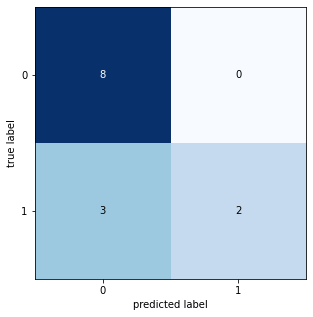

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



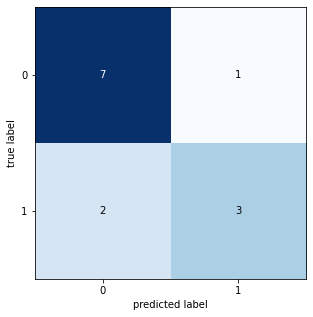

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



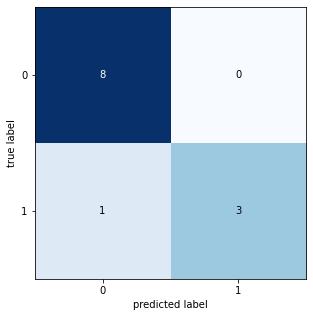

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



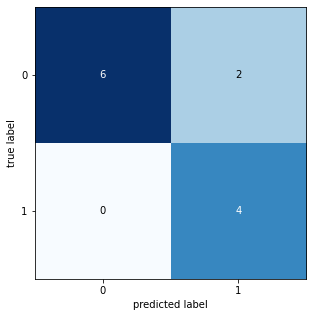

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



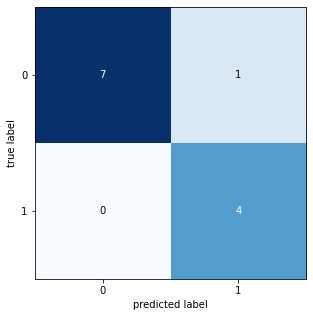

avg accuraccy Colon cancer =  0.841025641025641
avg F1_Score Colon cancer =  0.818141432011401
max accuraccy Colon cancer =  0.9166666666666666
max F1_Score Colon cancer =  0.9111111111111112
min accuraccy Colon cancer =  0.7692307692307693
min F1_Score Colon cancer =  0.7067669172932332
Running Time:  23.93526785100039


(0.841025641025641, 0.818141432011401)

In [10]:
FLNN_Classifier(Colon_IG,"Colon cancer",2)

Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.20      0.33         5

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



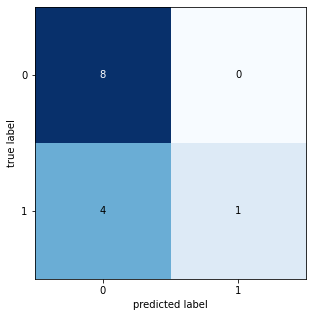

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



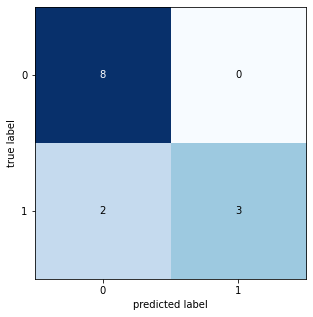

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



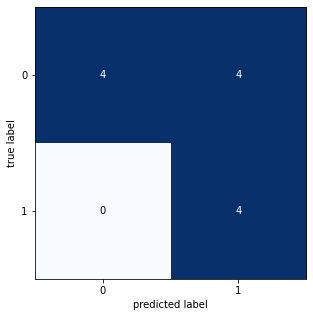

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



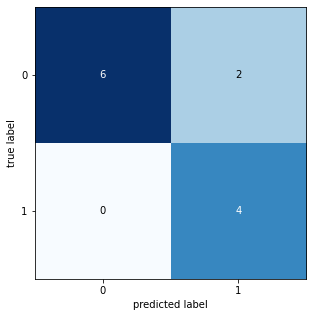

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



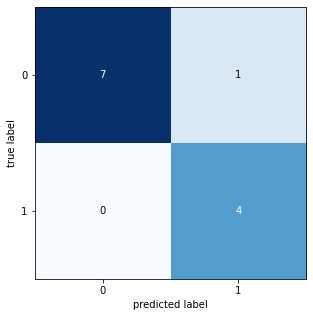

avg accuraccy Colon cancer =  0.791025641025641
avg F1_Score Colon cancer =  0.7584920634920636
max accuraccy Colon cancer =  0.9166666666666666
max F1_Score Colon cancer =  0.9111111111111112
min accuraccy Colon cancer =  0.6666666666666666
min F1_Score Colon cancer =  0.5666666666666667
Running Time:  23.752420723999876


(0.791025641025641, 0.7584920634920636)

In [11]:
FLNN_Classifier(Colon_IG,"Colon cancer",3)

Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6923076923076923
F1_Score :  0.5666666666666667
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.20      0.33         5

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



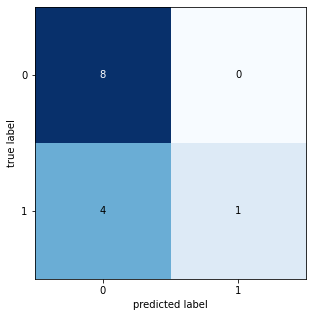

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



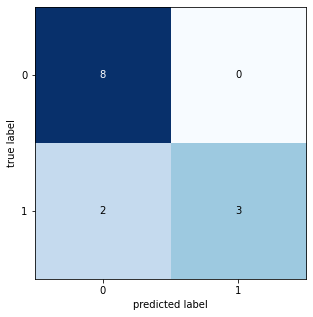

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



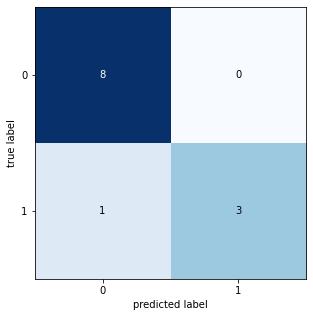

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



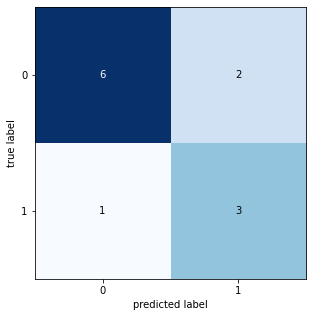

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



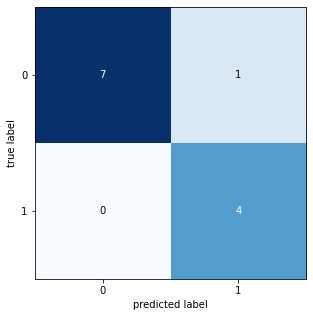

avg accuraccy Colon cancer =  0.8243589743589743
avg F1_Score Colon cancer =  0.7859430438842203
max accuraccy Colon cancer =  0.9166666666666666
max F1_Score Colon cancer =  0.9111111111111112
min accuraccy Colon cancer =  0.6923076923076923
min F1_Score Colon cancer =  0.5666666666666667
Running Time:  27.259887645000163


(0.8243589743589743, 0.7859430438842203)

In [12]:
FLNN_Classifier(Colon_IG,"Colon cancer",4)

## Colon + IG + GA

Generation : 0
gene : [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92

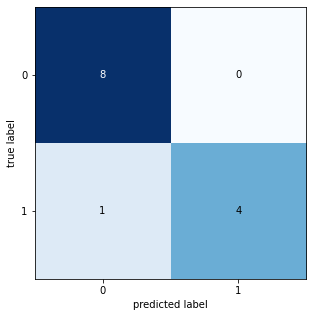

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



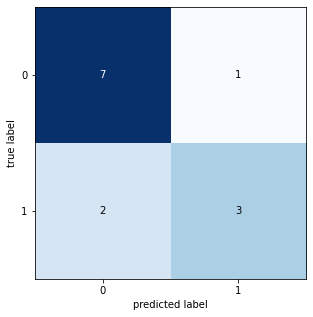

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



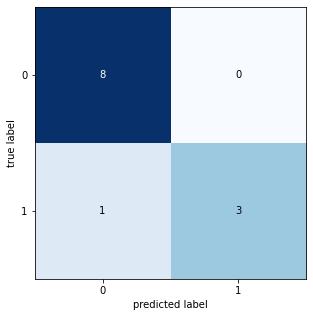

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



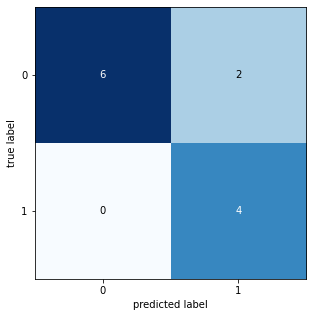

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



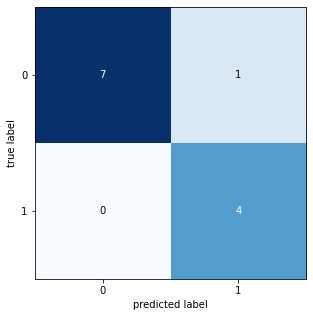

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8597945845004669
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  37.13143036300016
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


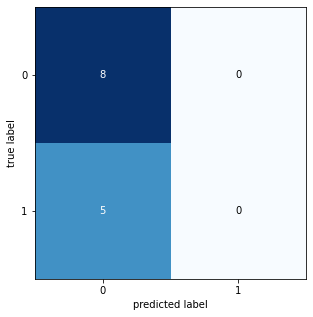

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



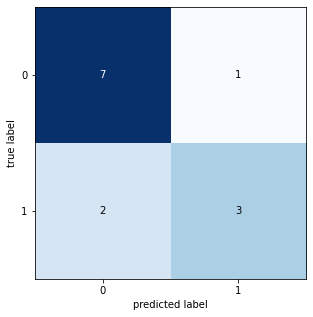

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



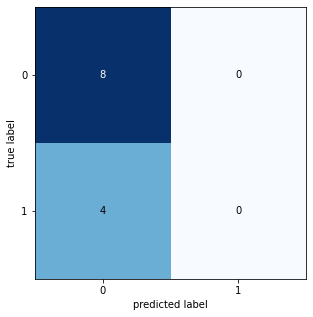

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



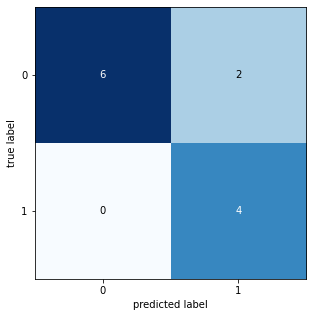

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



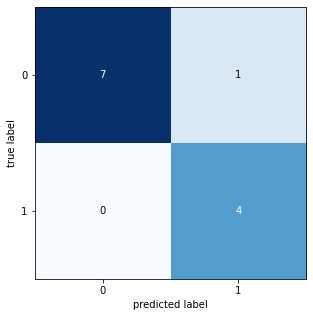

avg accuraccy Colon Cancer =  0.7602564102564102
avg F1_Score Colon Cancer =  0.6531465919701214
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  35.95906777500022
gene : [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7

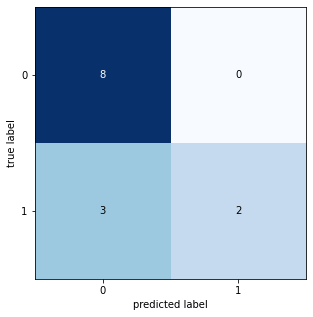

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



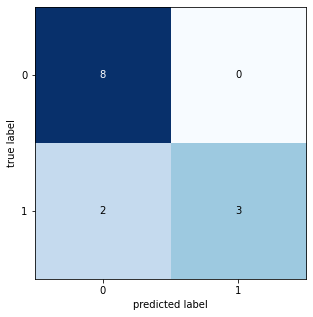

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.5833333333333334
F1_Score :  0.3684210526315789
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.00      0.00      0.00         4

    accuracy                           0.58        12
   macro avg       0.32      0.44      0.37        12
weighted avg       0.42      0.58      0.49        12



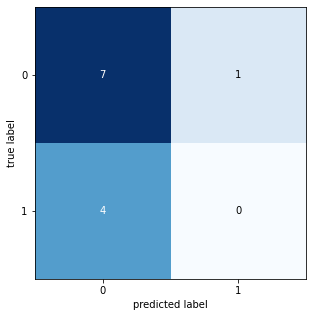

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



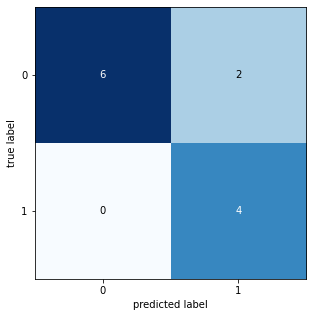

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



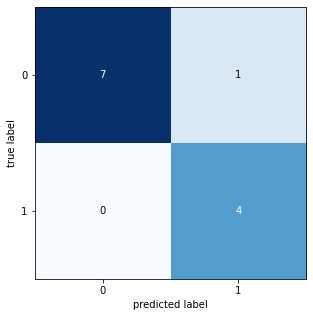

avg accuraccy Colon Cancer =  0.7897435897435898
avg F1_Score Colon Cancer =  0.7268629908103593
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.5833333333333334
min F1_Score Colon Cancer =  0.3684210526315789
Running Time:  36.08890529400014
gene : [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

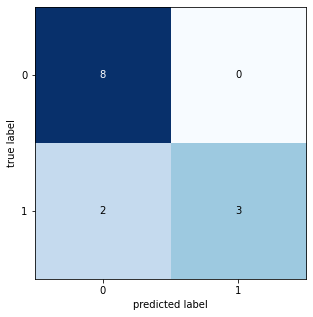

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



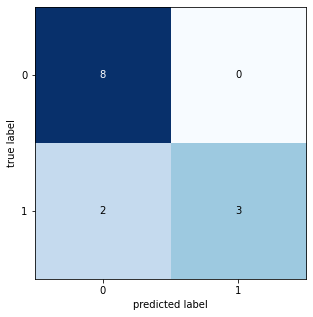

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



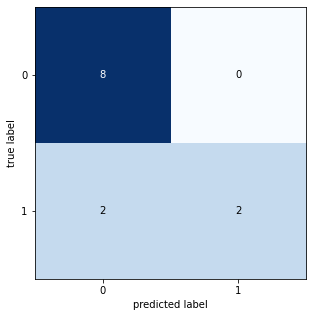

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



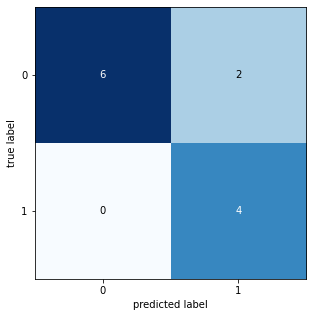

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



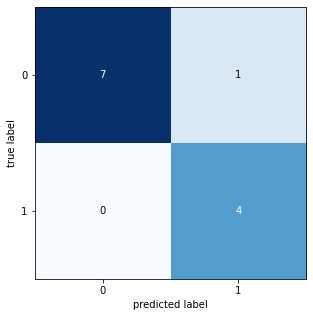

avg accuraccy Colon Cancer =  0.8551282051282051
avg F1_Score Colon Cancer =  0.8312698412698414
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.7777777777777778
Running Time:  36.46090538399994
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

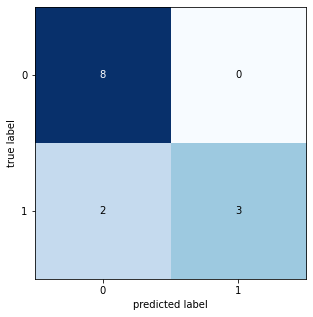

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



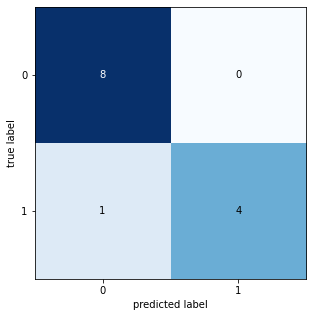

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



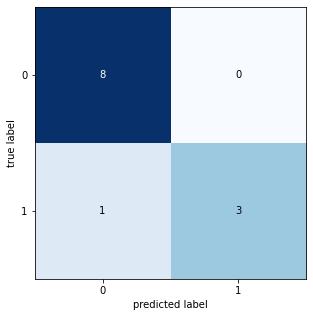

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



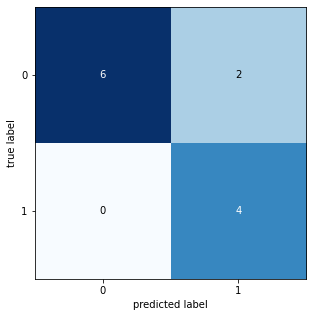

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



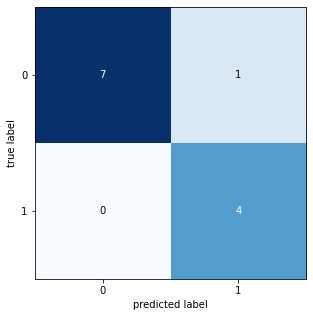

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.19912098800023
gene : [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

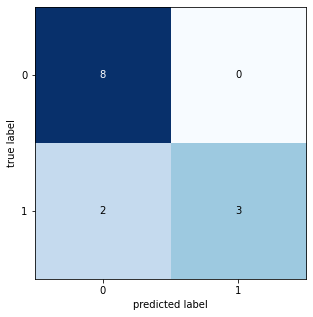

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



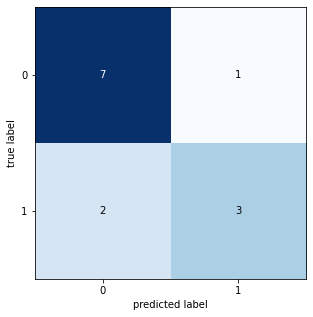

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



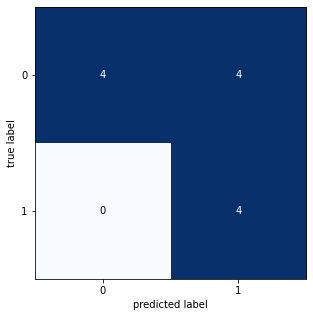

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



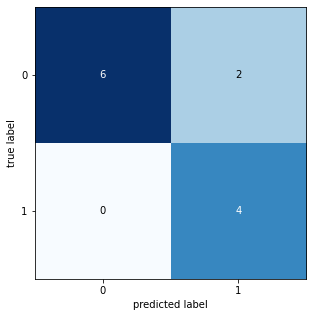

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



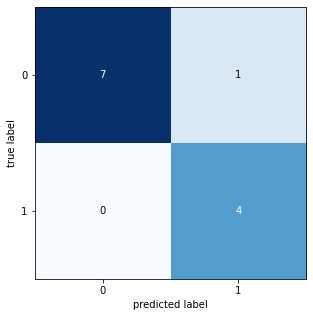

avg accuraccy Colon Cancer =  0.8064102564102564
avg F1_Score Colon Cancer =  0.7941783380018675
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  37.61400860699996
gene : [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

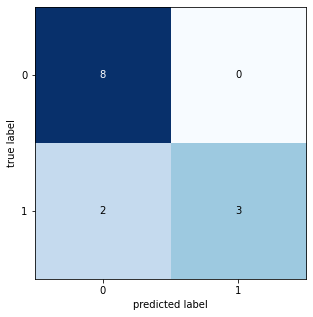

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



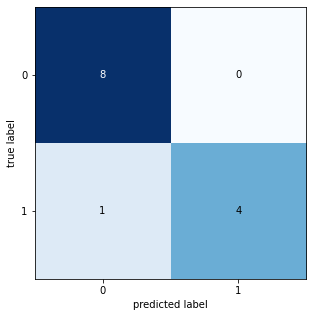

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


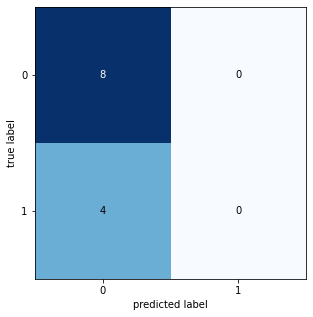

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



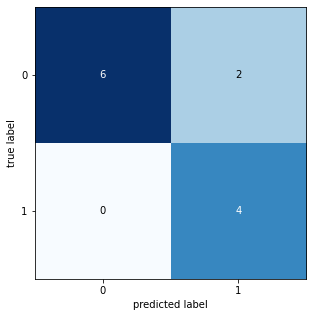

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



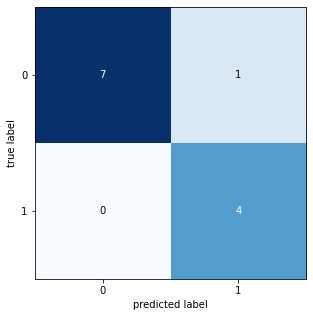

avg accuraccy Colon Cancer =  0.8371794871794872
avg F1_Score Colon Cancer =  0.7748319327731092
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  39.305988507000166
gene : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615384615384

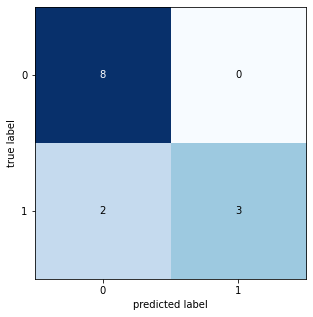

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



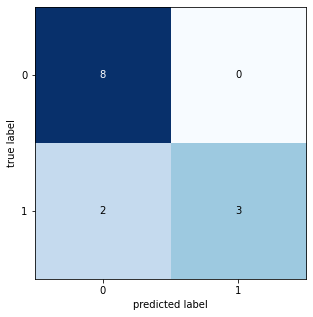

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


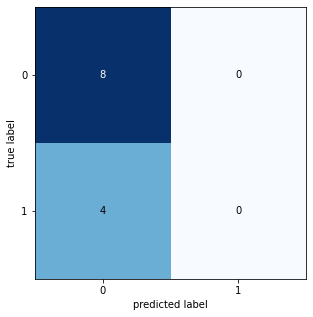

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



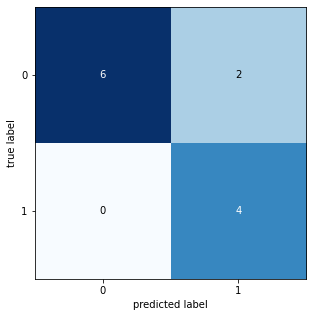

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



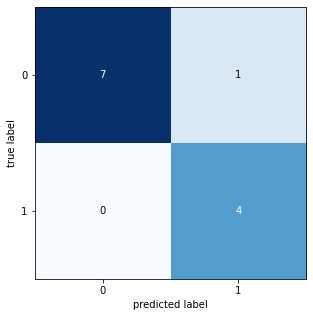

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.7557142857142857
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  35.625701128999935
gene : [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.69230769230769

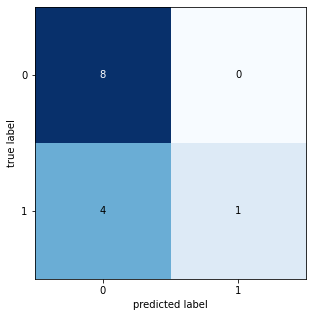

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



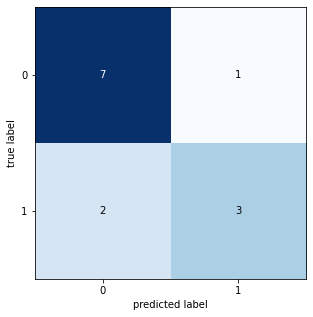

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


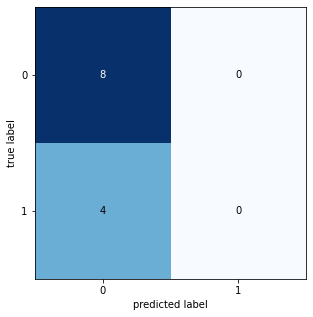

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



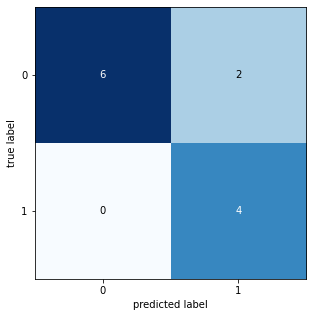

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



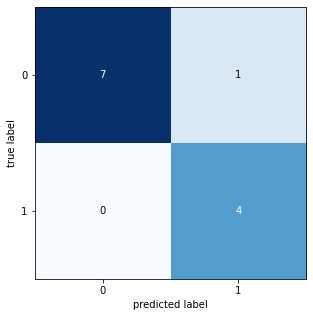

avg accuraccy Colon Cancer =  0.7756410256410257
avg F1_Score Colon Cancer =  0.6902894491129785
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  36.524614617000225
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615384615384

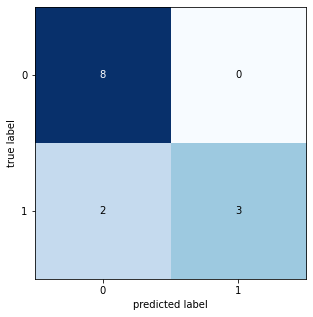

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



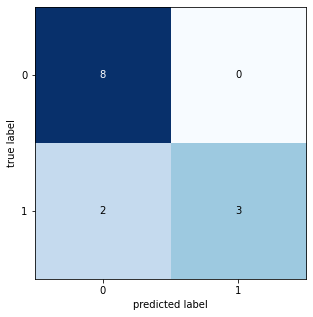

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



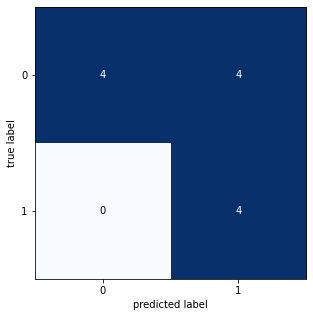

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



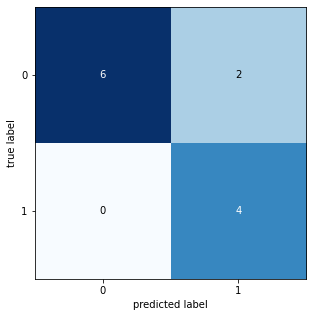

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



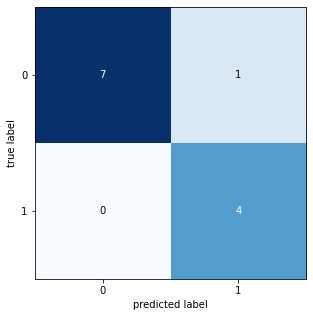

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.809047619047619
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  34.57750637700019
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.8746638655462184  || Akurasi terbaik : 0.8871794871794872  || jumlah fitur : 55

Generation : 1
gene : [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,

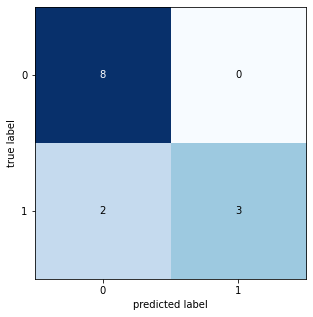

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



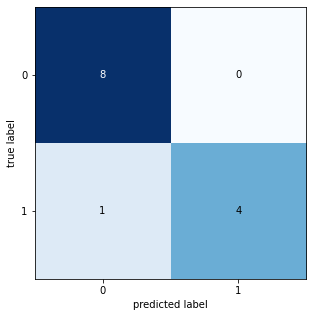

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



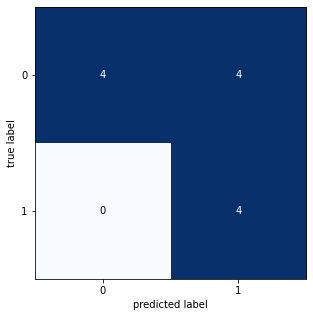

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



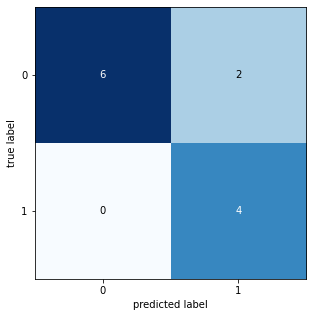

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



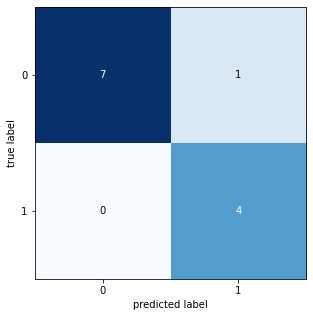

avg accuraccy Colon Cancer =  0.8371794871794872
avg F1_Score Colon Cancer =  0.8281652661064426
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  35.53628380100008
gene : [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

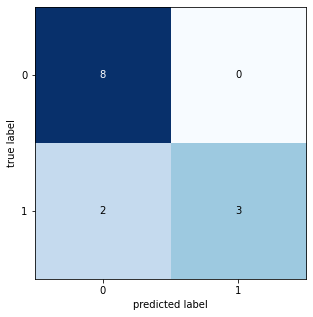

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



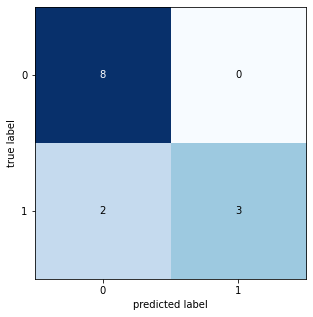

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



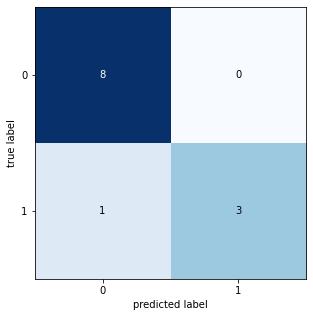

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



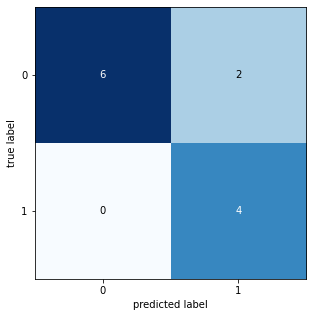

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



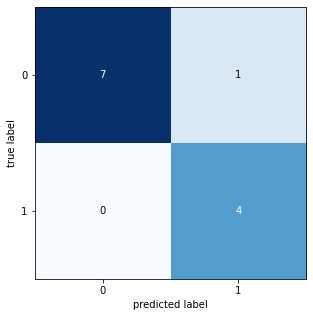

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.877366415000324
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

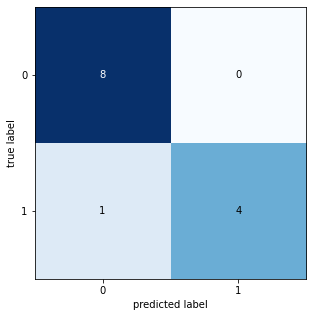

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



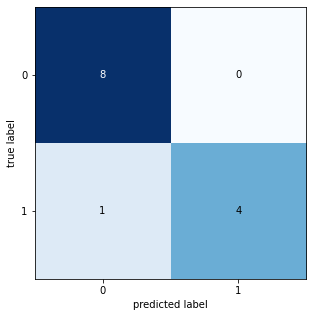

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



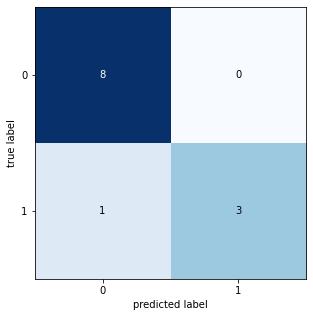

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



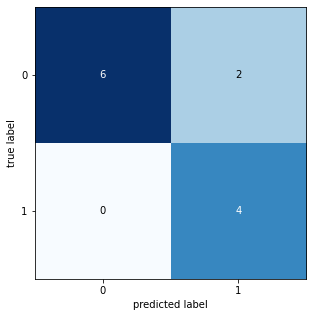

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



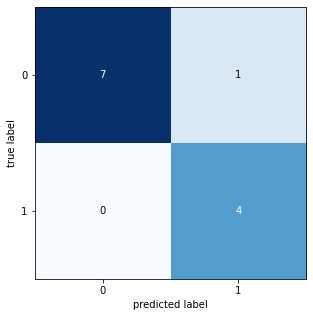

avg accuraccy Colon Cancer =  0.9025641025641026
avg F1_Score Colon Cancer =  0.893781512605042
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  36.400496255999315
gene : [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

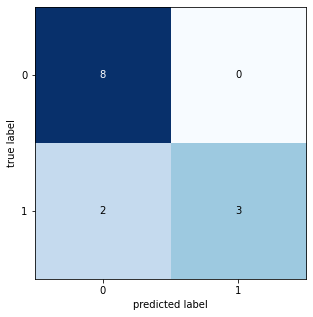

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



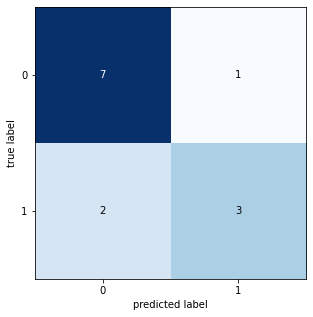

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



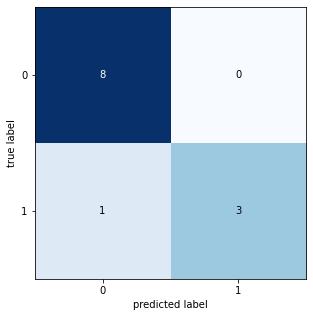

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



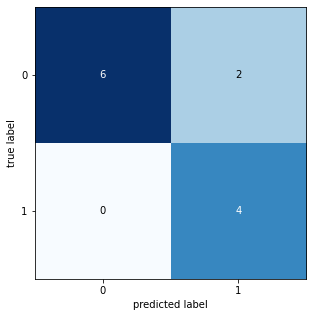

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



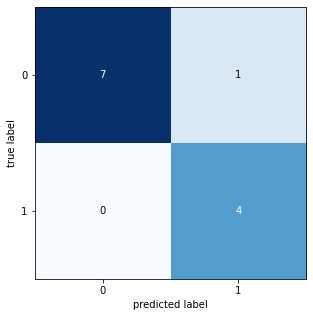

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  39.0171667679997
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

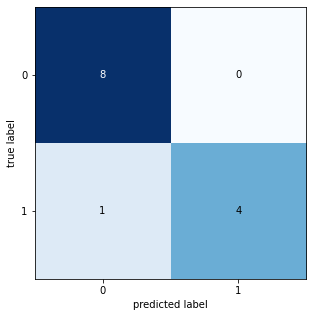

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



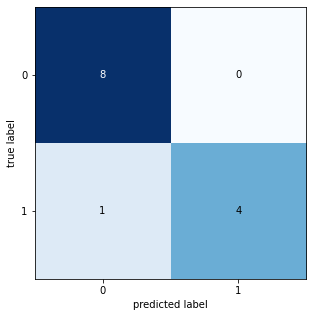

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



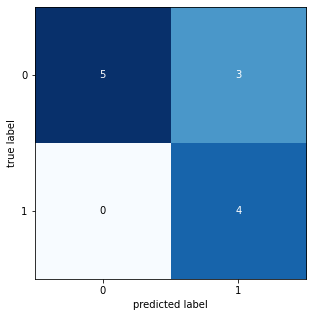

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



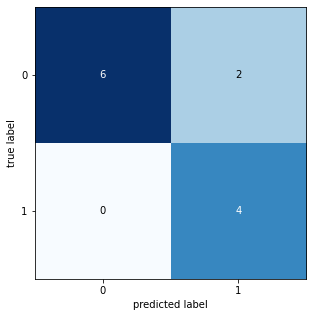

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



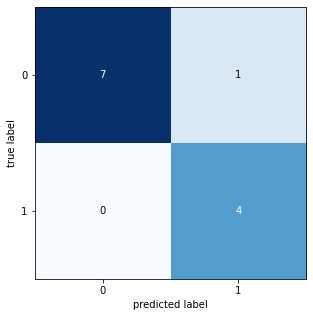

avg accuraccy Colon Cancer =  0.8692307692307694
avg F1_Score Colon Cancer =  0.8635999294822826
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7482517482517483
Running Time:  35.90727119499934
gene : [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.61538461538461

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


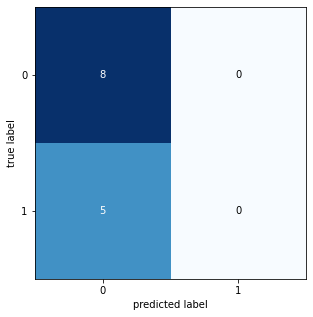

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



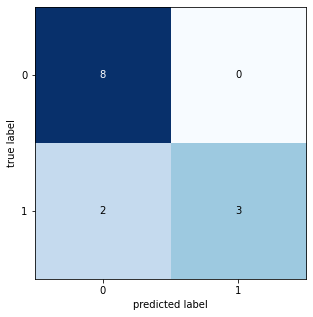

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



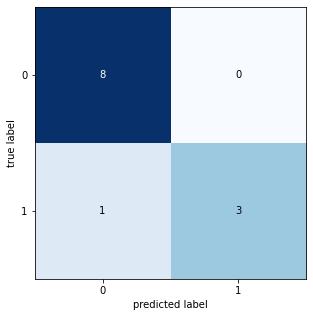

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



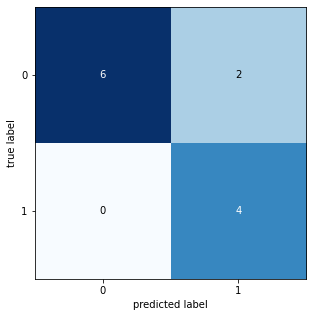

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



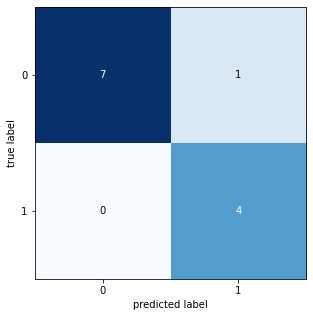

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7678478057889823
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  36.28293966000001
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6

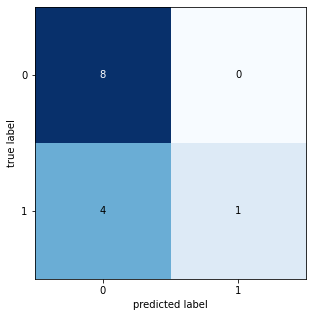

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



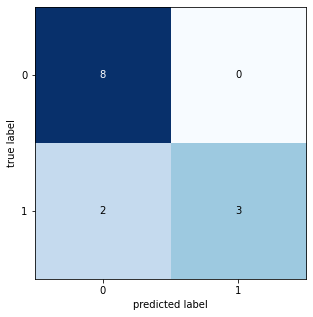

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



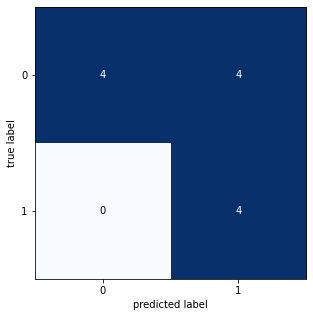

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



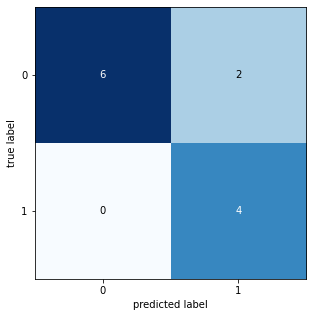

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



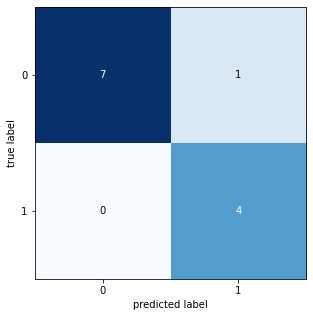

avg accuraccy Colon Cancer =  0.791025641025641
avg F1_Score Colon Cancer =  0.7584920634920636
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  34.56062079700041
gene : [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


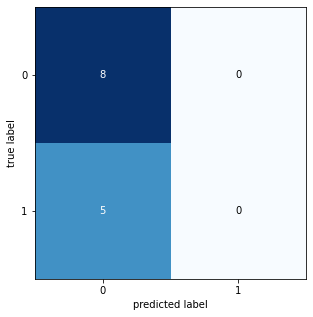

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



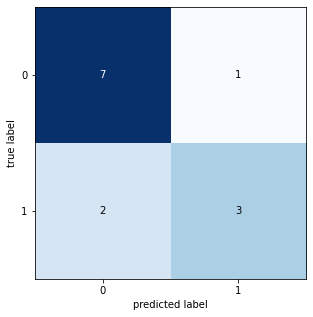

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



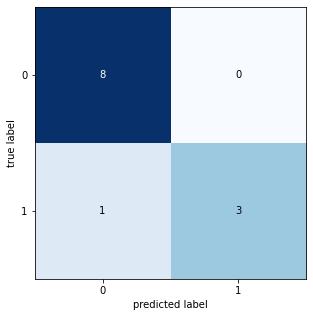

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



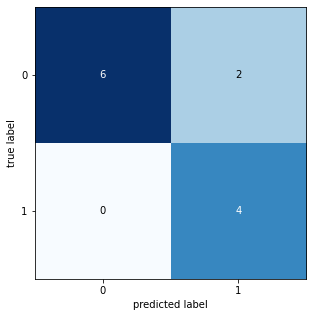

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



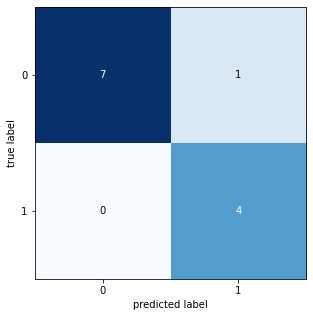

avg accuraccy Colon Cancer =  0.8102564102564103
avg F1_Score Colon Cancer =  0.7529785247432306
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  34.426549809999415
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

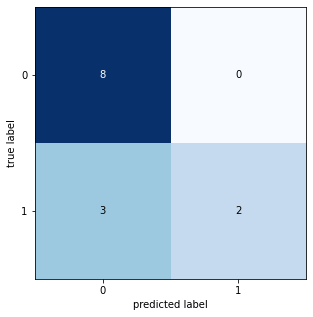

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



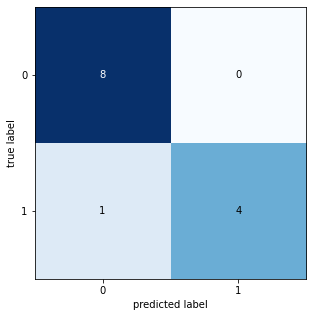

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



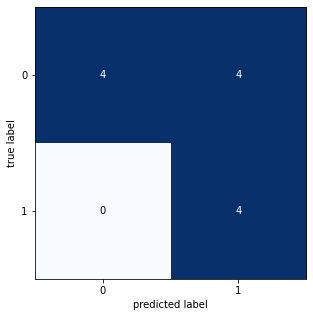

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



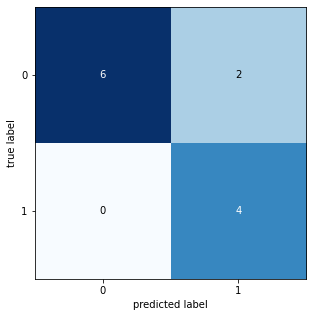

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



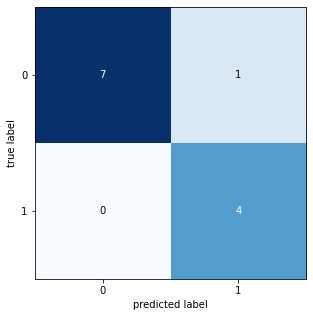

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.8056297606762003
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  37.80605368099987
gene : [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

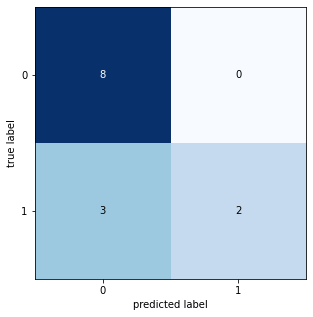

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



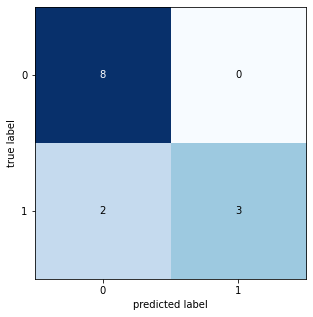

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



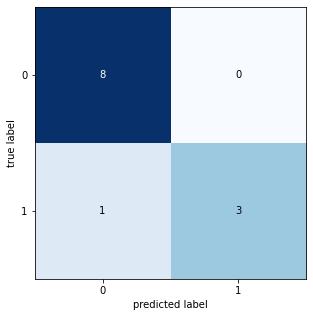

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



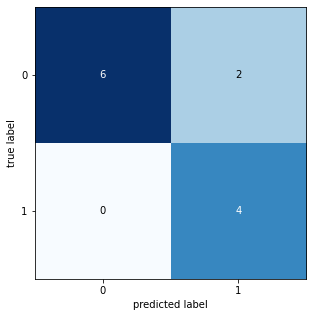

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



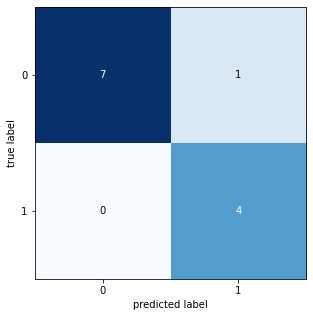

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  38.04391069099984
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.893781512605042  || Akurasi terbaik : 0.9025641025641026  || jumlah fitur : 55

Generation : 2
gene : [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

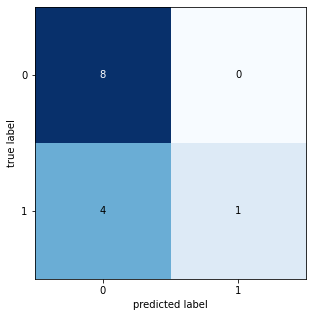

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



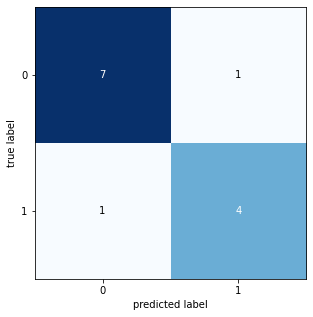

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


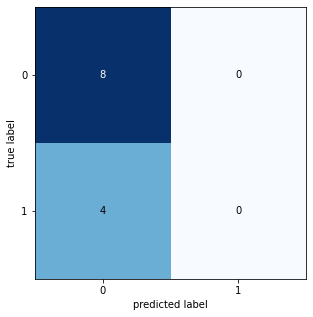

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



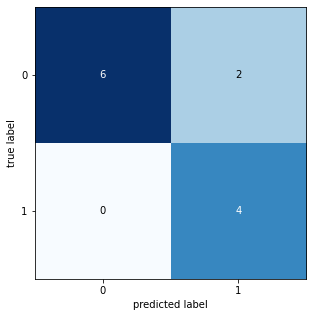

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



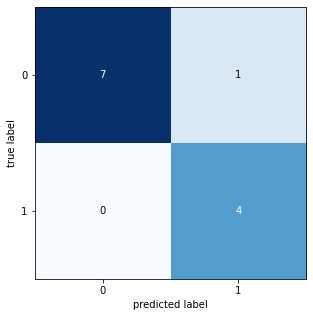

avg accuraccy Colon Cancer =  0.791025641025641
avg F1_Score Colon Cancer =  0.7087698412698413
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  35.37356803400053
gene : [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6153846153846154

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


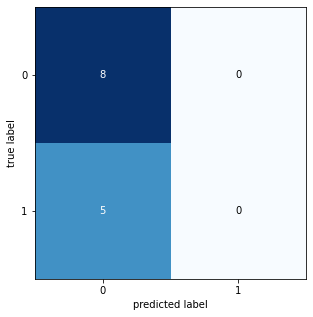

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



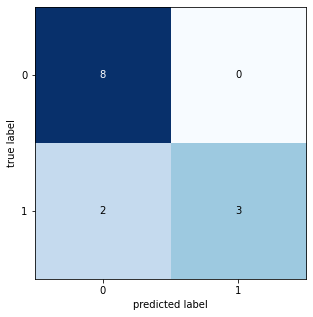

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



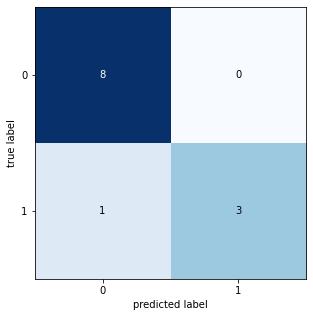

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



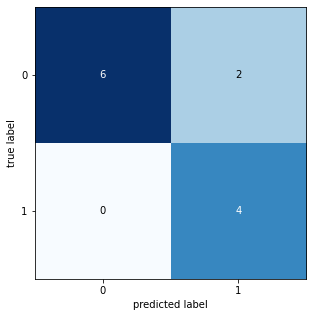

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



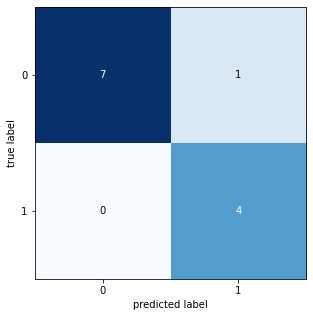

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7678478057889823
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  36.85714577699946
gene : [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

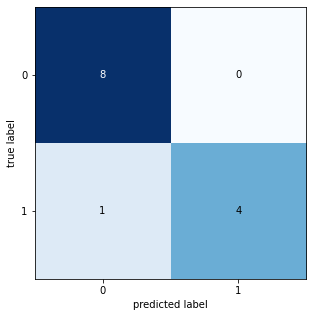

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



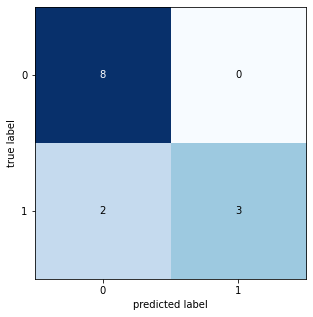

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



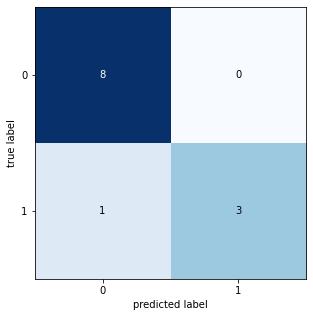

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



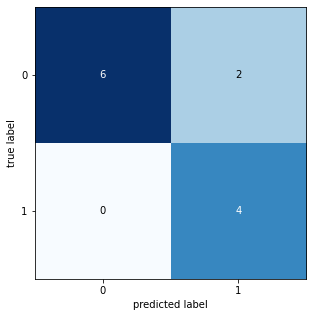

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



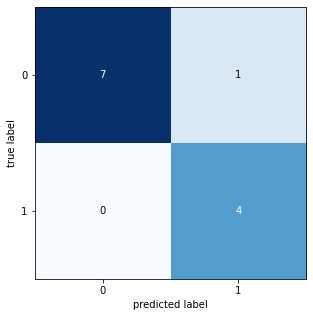

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.5311854470001
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

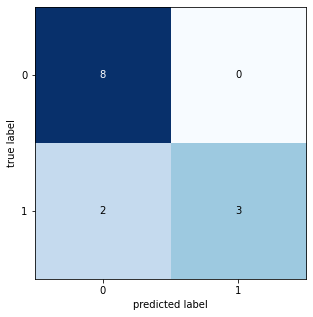

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



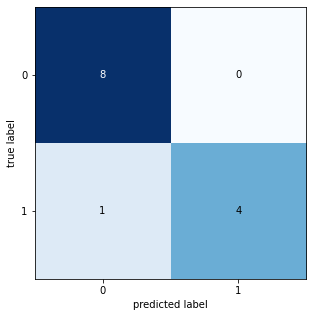

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



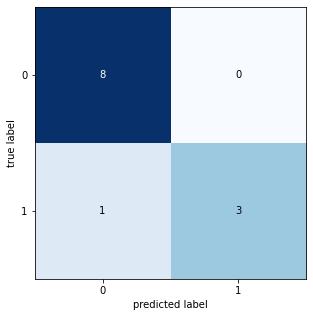

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



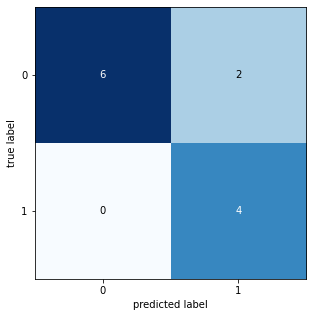

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



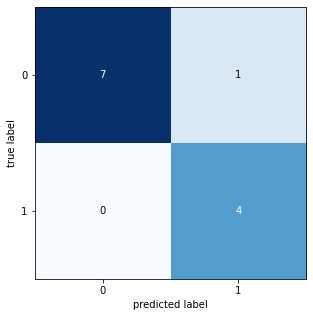

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.45264510400011
gene : [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

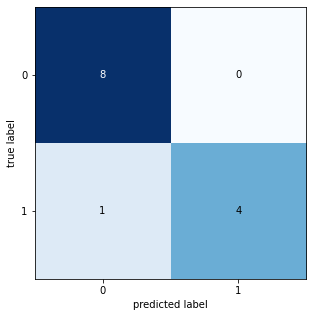

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



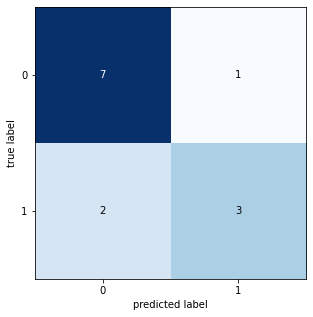

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



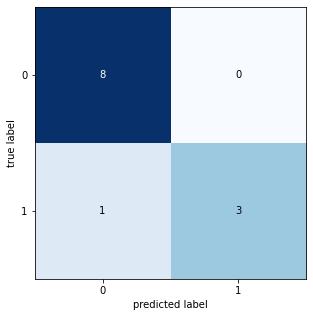

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



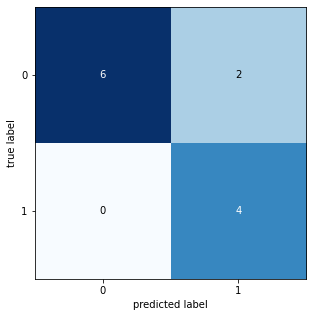

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



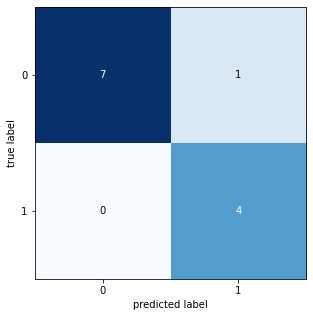

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8597945845004669
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  36.9168654820005
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

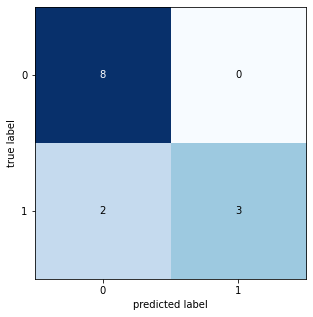

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



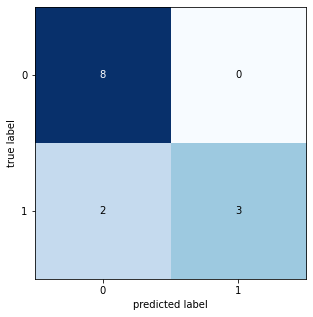

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


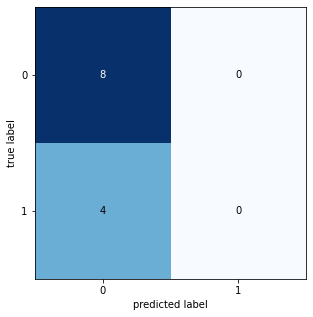

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



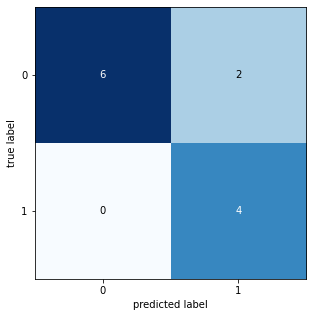

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



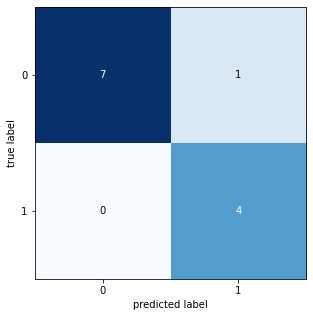

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.7557142857142857
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  37.57375733699973
gene : [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.846153846153846

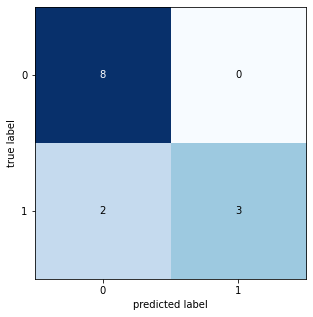

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



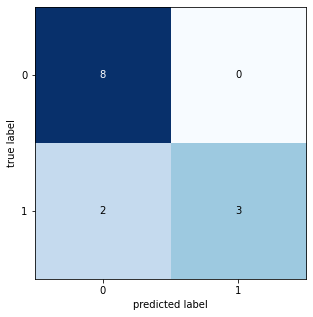

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



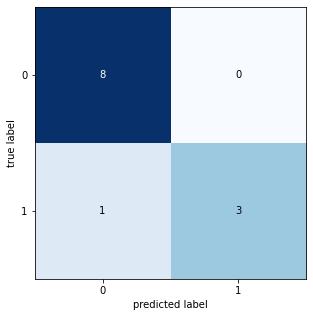

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



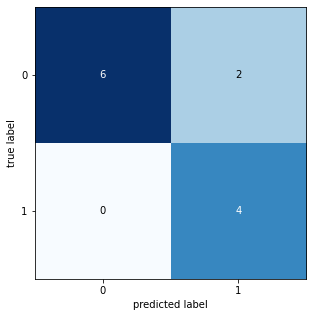

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



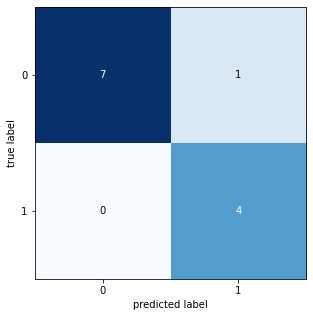

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.648828518999835
gene : [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

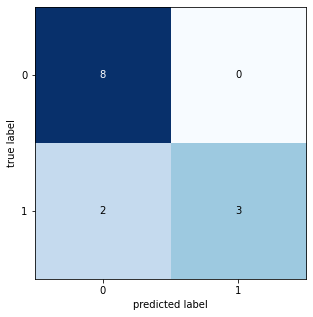

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



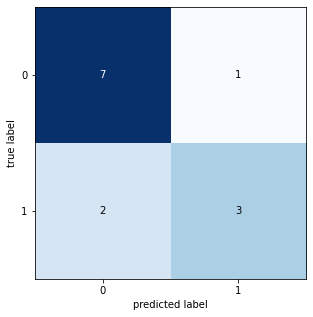

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



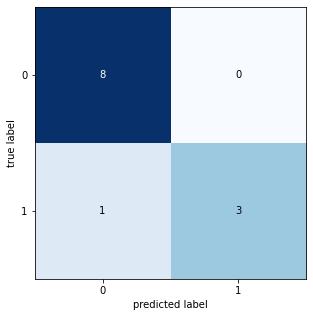

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



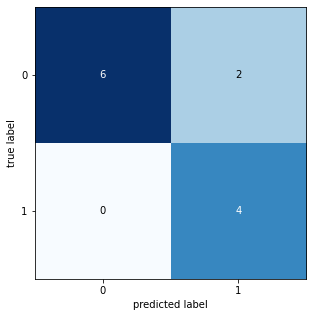

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



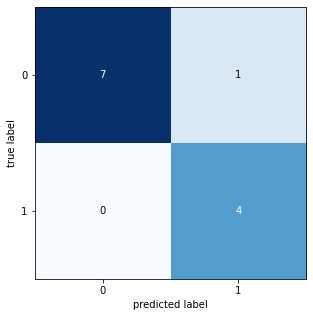

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  35.327740089000145
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

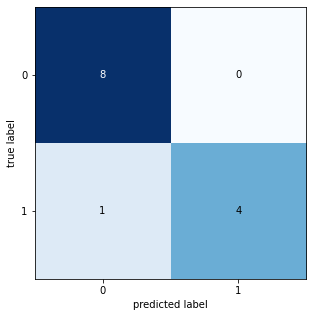

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



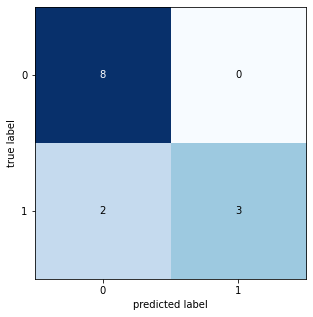

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


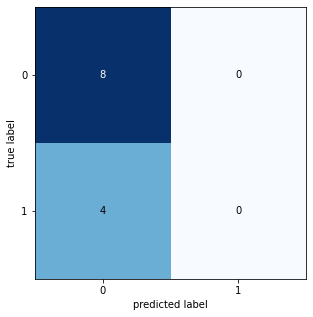

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



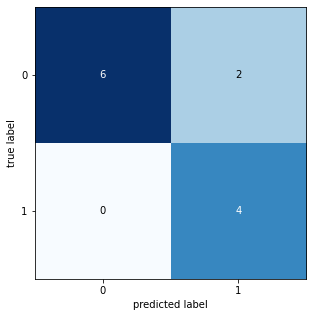

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



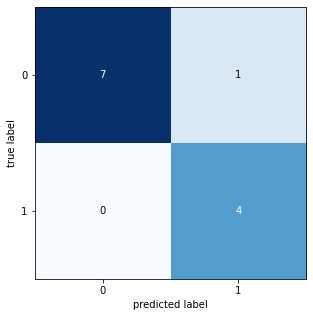

avg accuraccy Colon Cancer =  0.8371794871794872
avg F1_Score Colon Cancer =  0.7748319327731092
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  36.899015719999625
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615384615384

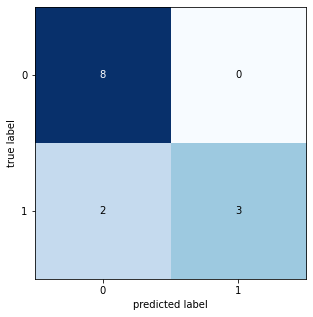

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



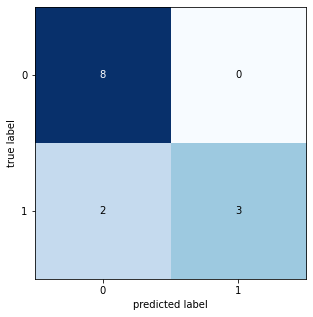

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



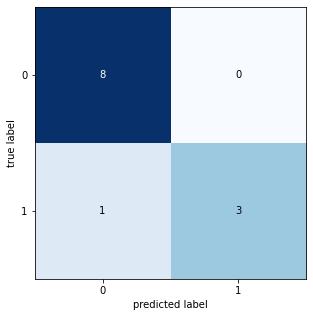

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



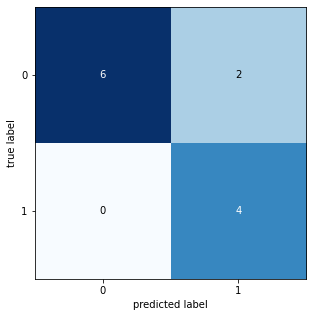

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



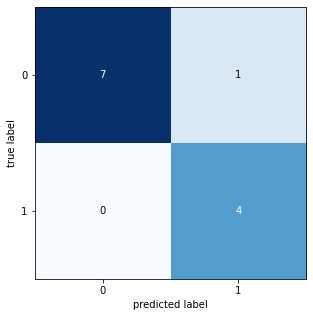

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.06555250999918
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.893781512605042  || Akurasi terbaik : 0.9025641025641026  || jumlah fitur : 55

Generation : 3
gene : [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 

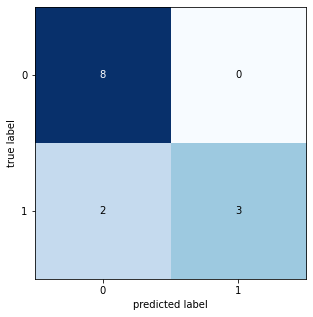

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



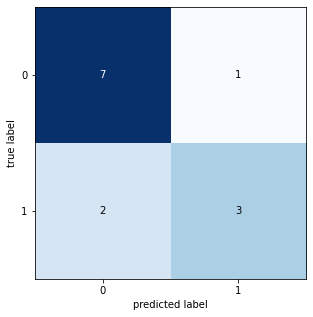

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



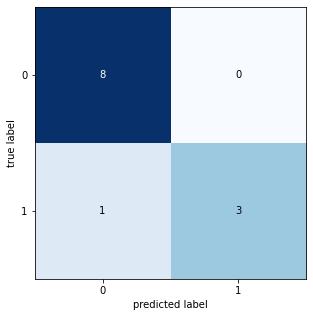

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



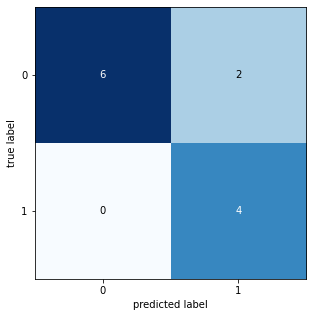

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



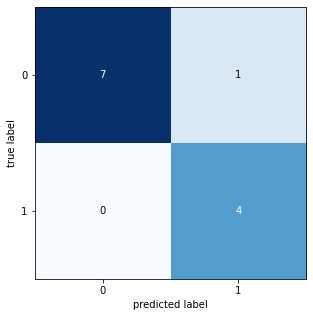

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  37.25132623299942
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


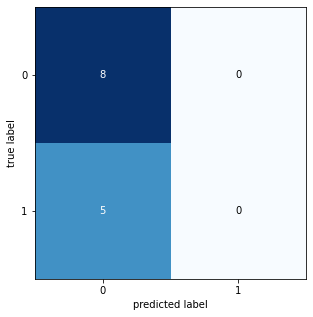

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



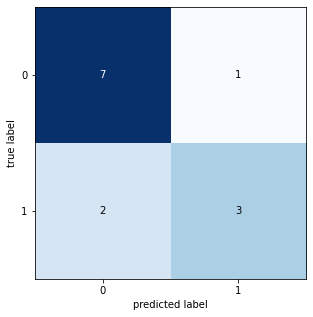

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



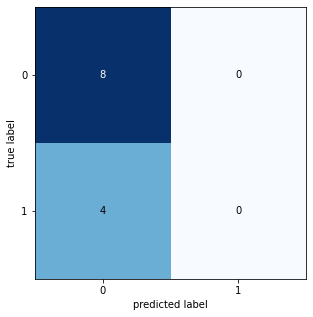

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



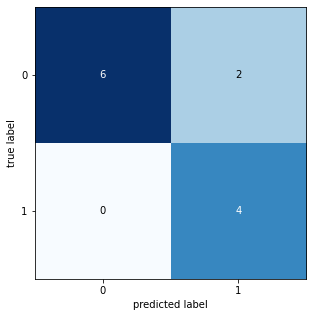

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



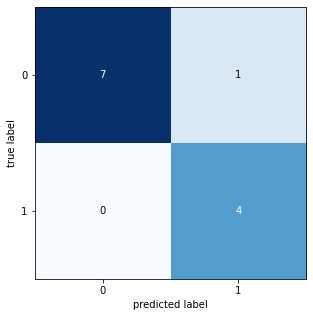

avg accuraccy Colon Cancer =  0.7602564102564102
avg F1_Score Colon Cancer =  0.6531465919701214
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  35.88933867000014
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

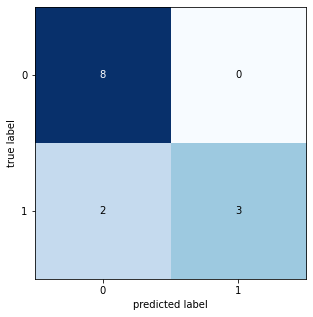

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



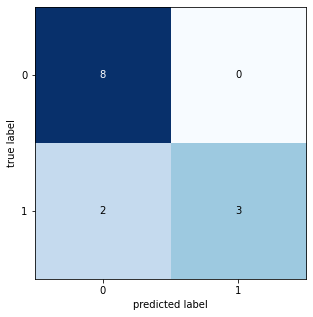

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



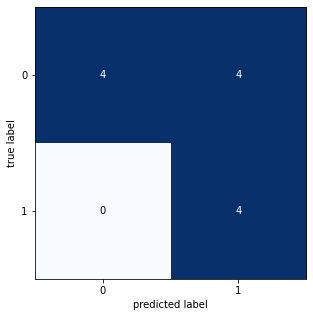

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



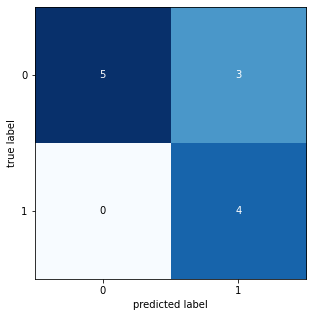

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



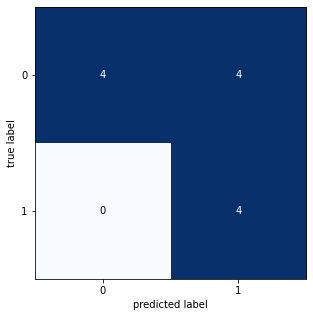

avg accuraccy Colon Cancer =  0.7551282051282051
avg F1_Score Colon Cancer =  0.7440947940947941
max accuraccy Colon Cancer =  0.8461538461538461
max F1_Score Colon Cancer =  0.8194444444444444
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  37.96532450700033
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

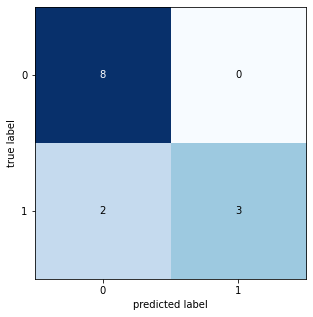

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



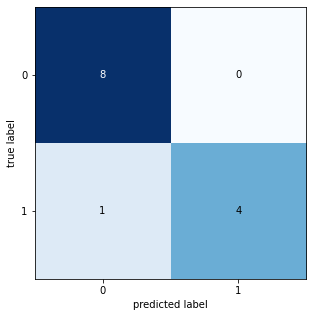

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



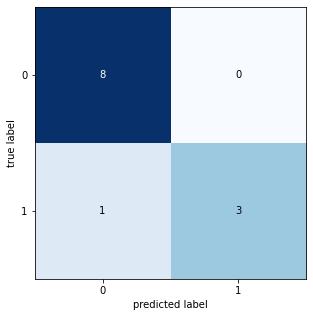

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



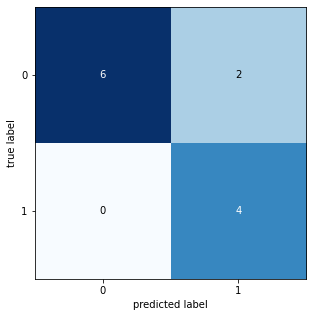

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



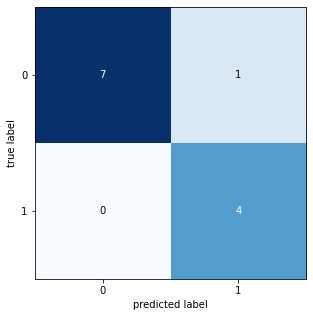

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.536044460000085
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

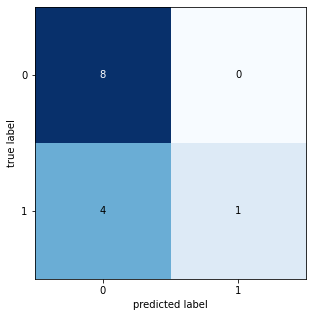

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



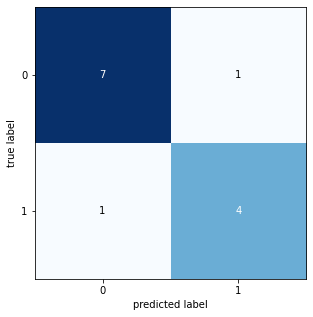

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



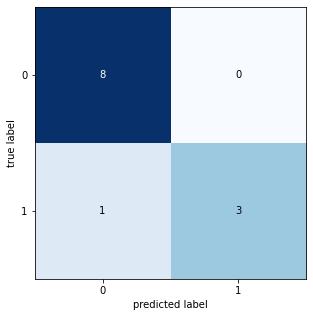

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



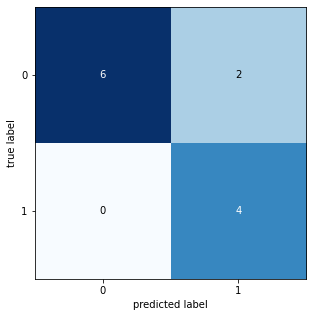

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



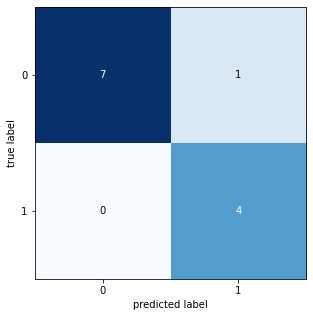

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8086017740429506
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.33911829199951
gene : [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

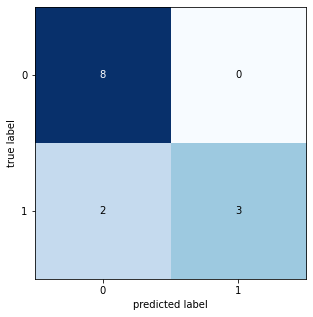

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



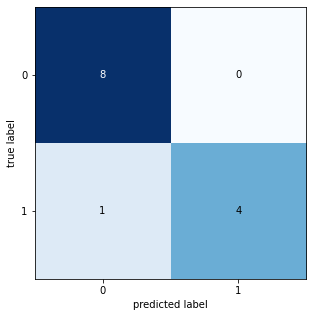

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



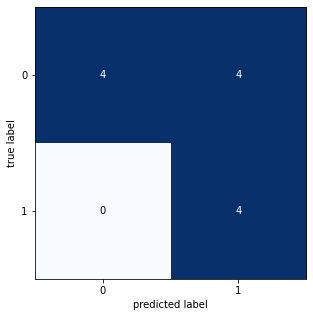

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



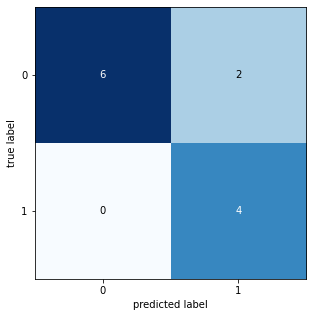

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



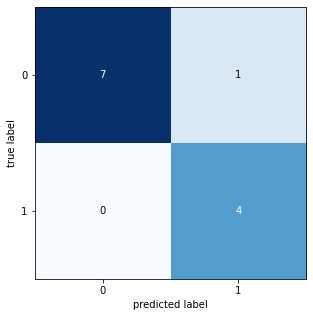

avg accuraccy Colon Cancer =  0.8371794871794872
avg F1_Score Colon Cancer =  0.8281652661064426
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  36.63273795199984
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

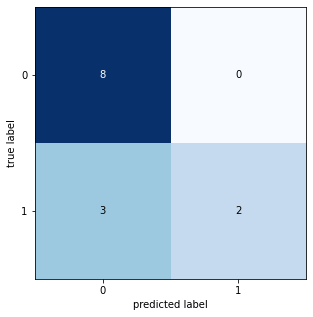

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



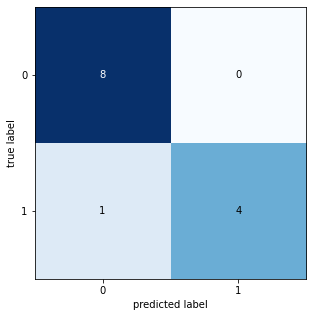

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



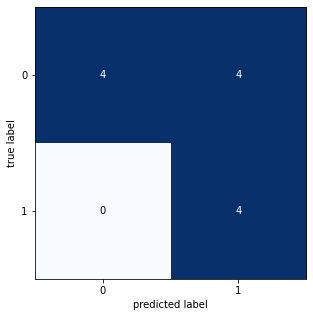

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



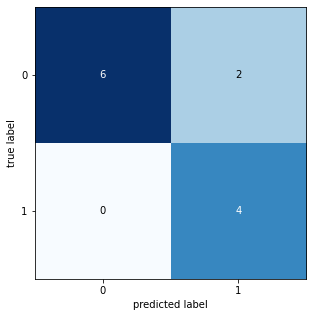

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



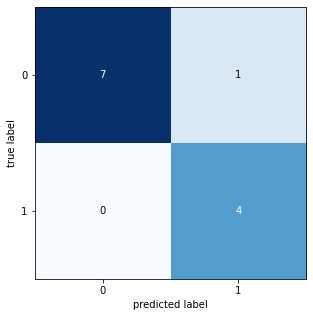

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.8056297606762003
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  38.533536959999765
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

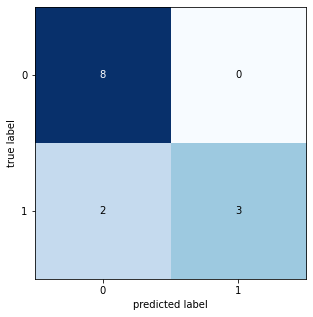

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



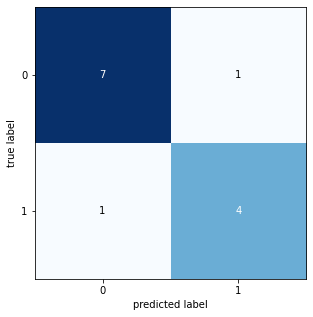

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



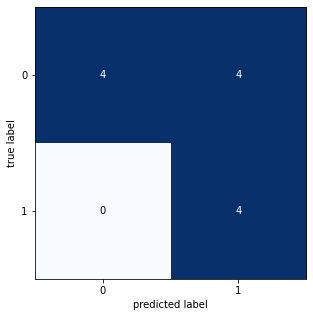

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



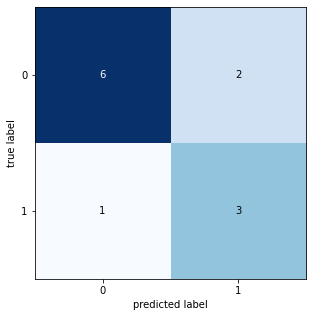

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



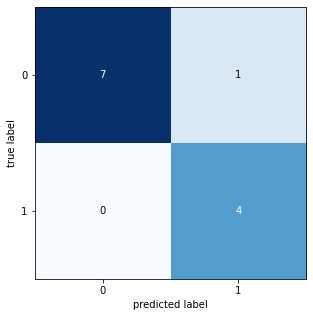

avg accuraccy Colon Cancer =  0.8051282051282052
avg F1_Score Colon Cancer =  0.7936111111111112
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  36.484126632999505
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

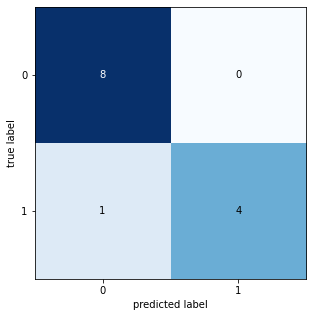

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



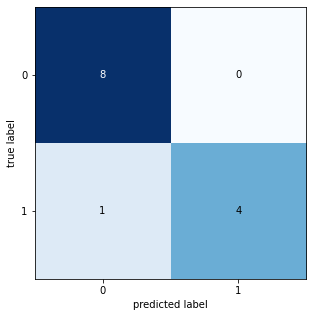

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



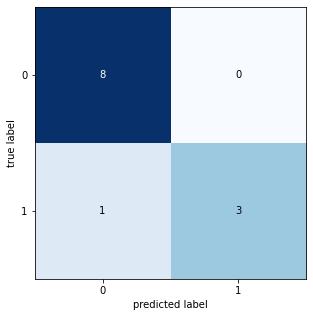

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



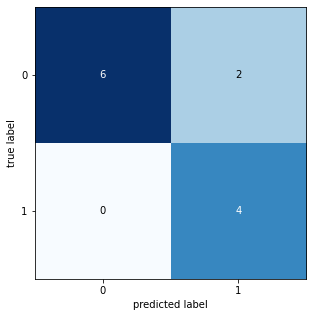

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



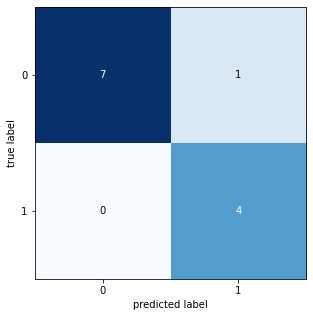

avg accuraccy Colon Cancer =  0.9025641025641026
avg F1_Score Colon Cancer =  0.893781512605042
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  38.59941761800019
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

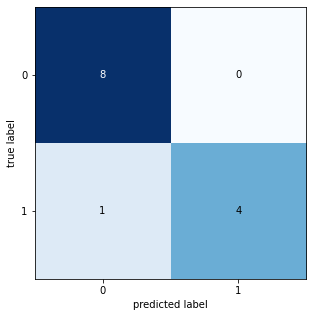

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



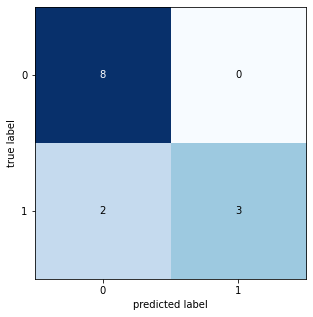

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



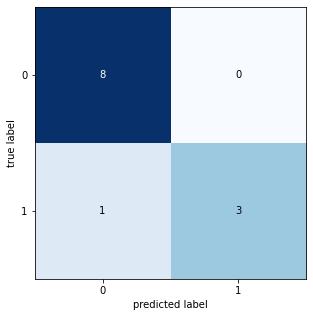

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



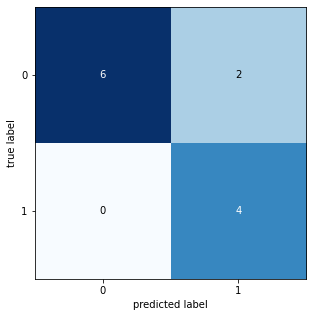

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



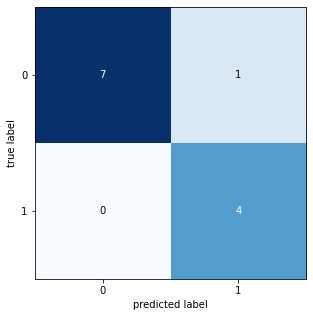

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.18381030199998
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.893781512605042  || Akurasi terbaik : 0.9025641025641026  || jumlah fitur : 55

Generation : 4
gene : [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,

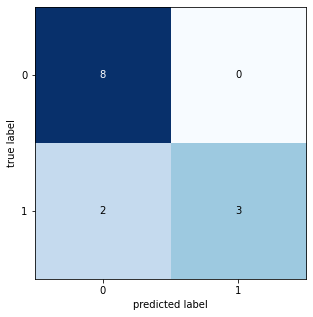

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



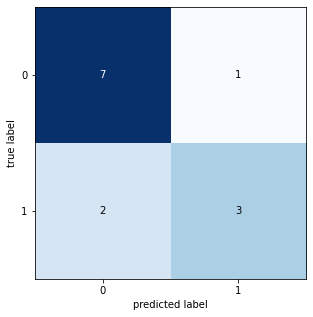

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



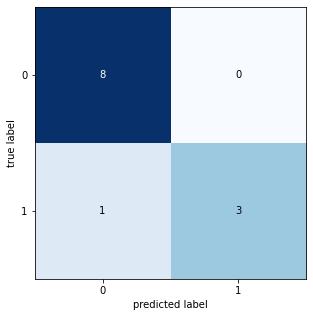

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



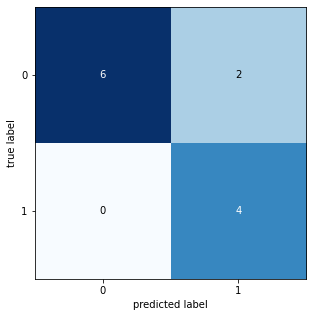

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



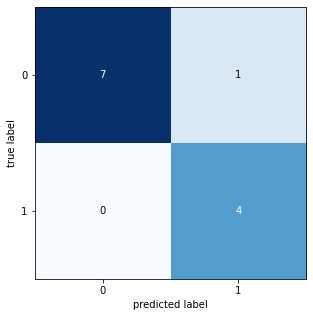

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  35.4153802689998
gene : [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

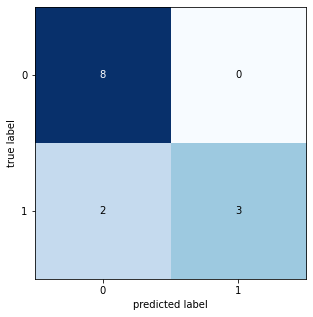

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



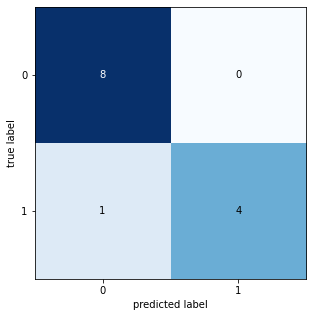

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



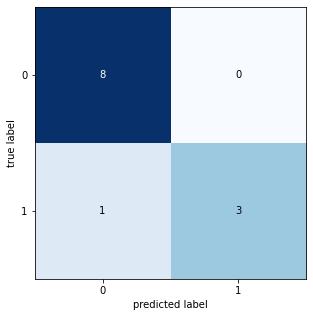

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



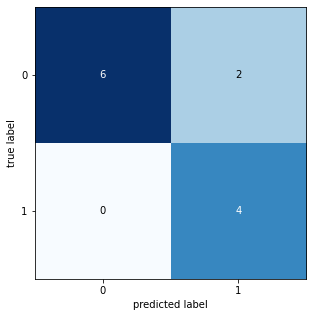

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



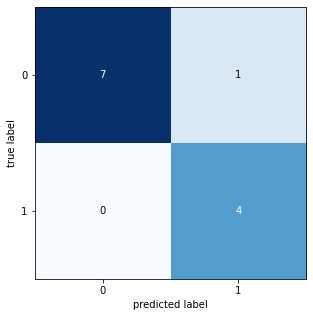

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  34.749043722999886
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

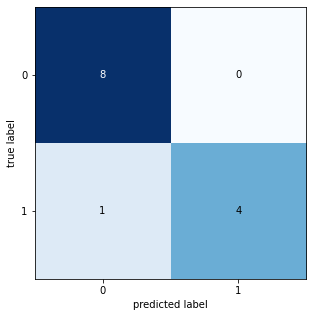

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



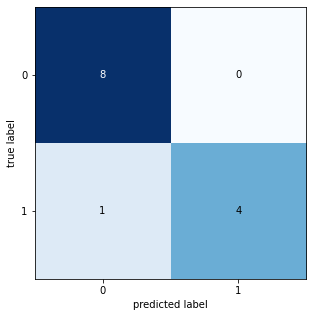

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



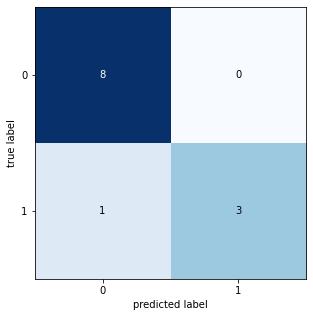

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



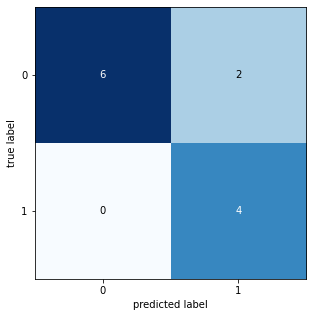

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



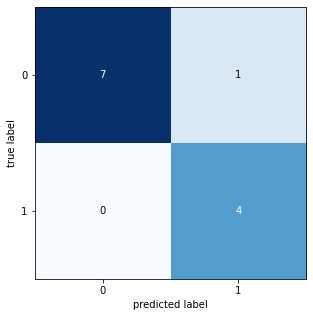

avg accuraccy Colon Cancer =  0.9025641025641026
avg F1_Score Colon Cancer =  0.893781512605042
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  36.601315371000055
gene : [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

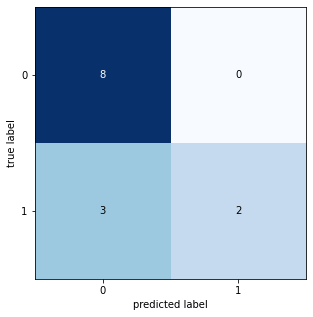

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



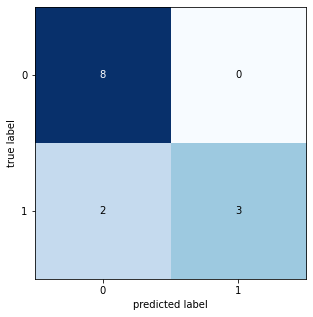

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



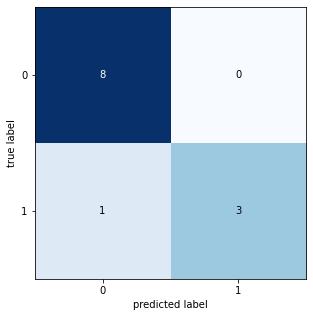

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



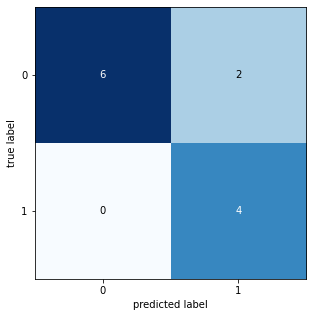

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



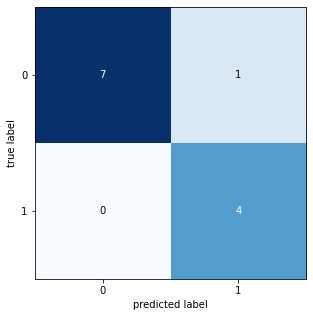

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  34.84499871099979
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

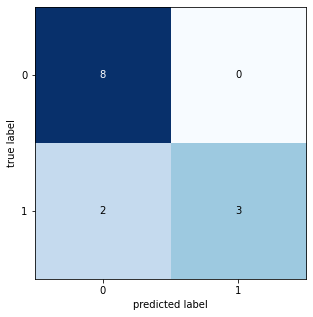

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



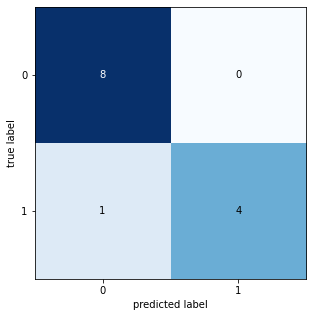

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



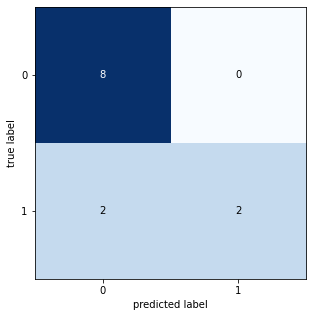

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



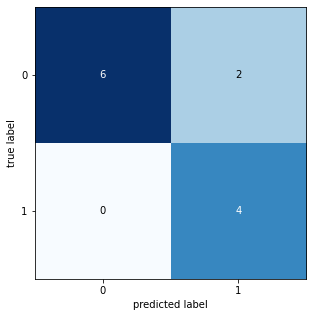

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



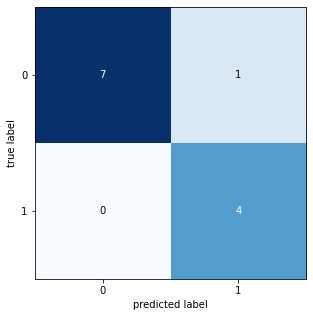

avg accuraccy Colon Cancer =  0.8705128205128206
avg F1_Score Colon Cancer =  0.8503874883286648
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.7777777777777778
Running Time:  36.974422027999935
gene : [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


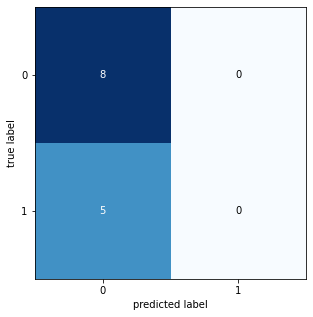

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



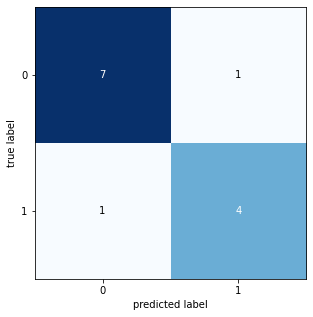

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



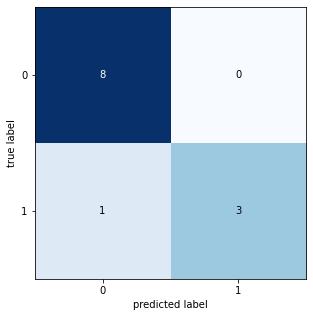

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



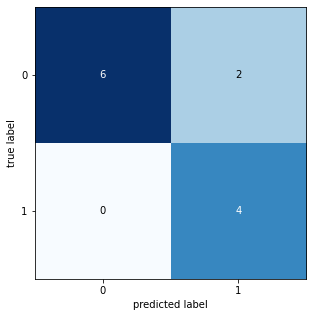

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



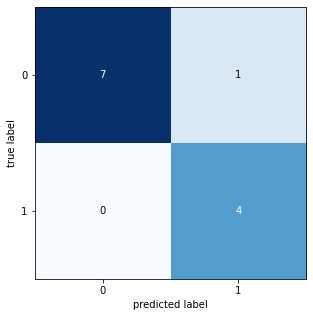

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7714589169000934
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  34.522256478999225
gene : [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

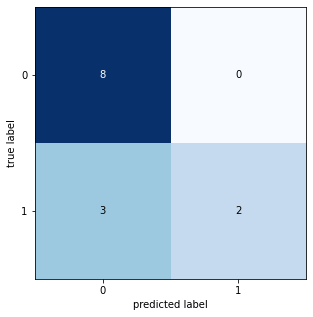

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



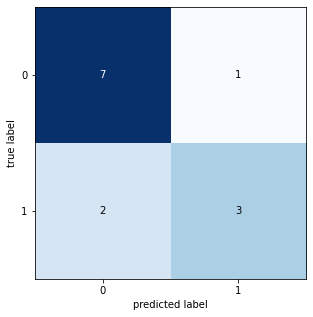

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



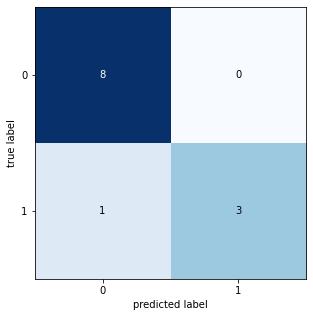

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



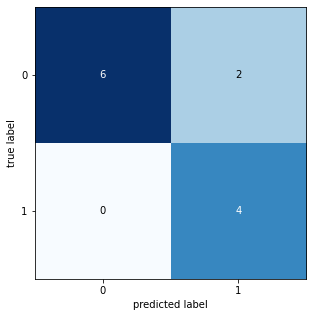

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



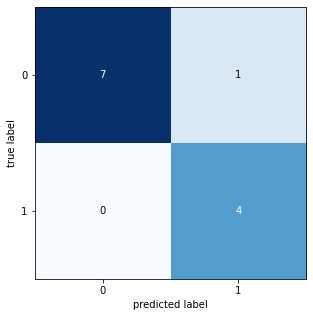

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.818141432011401
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  38.17033677099971
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92

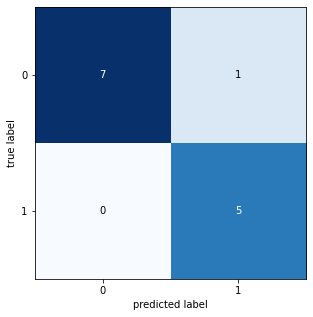

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



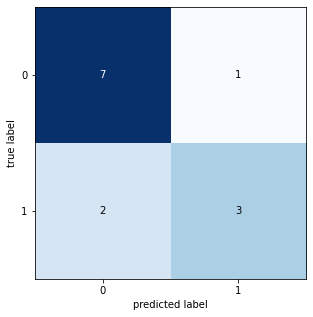

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


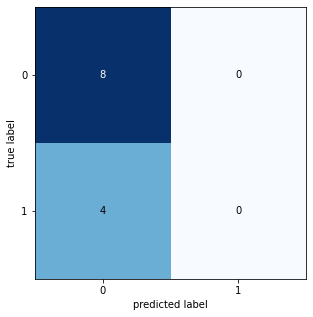

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



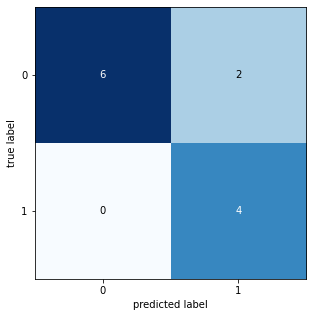

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



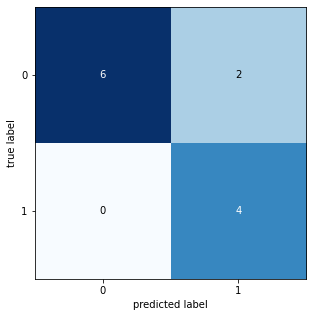

avg accuraccy Colon Cancer =  0.8051282051282052
avg F1_Score Colon Cancer =  0.7446906035141329
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9212121212121211
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  38.257888522999565
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92307692307692

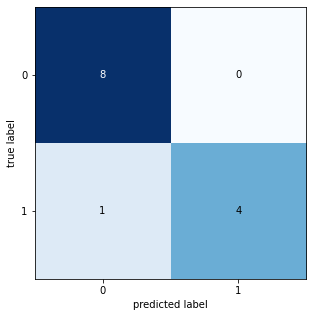

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



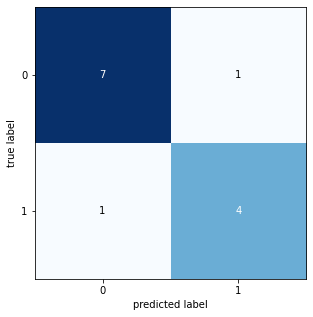

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



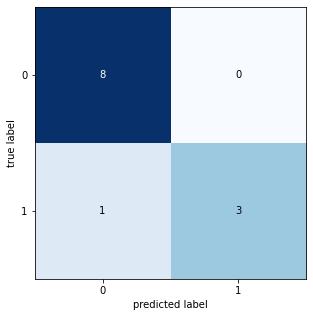

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



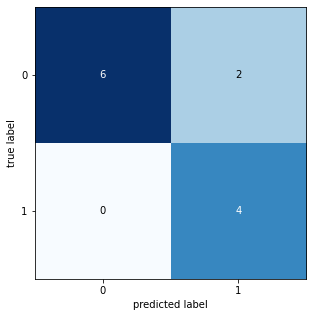

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



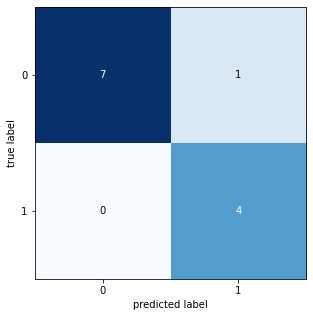

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8782749766573297
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  37.31585349299985
gene : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

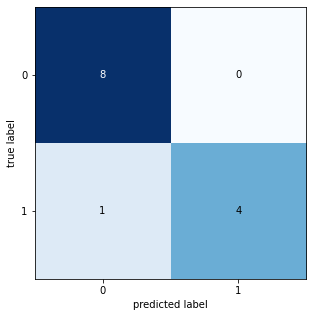

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



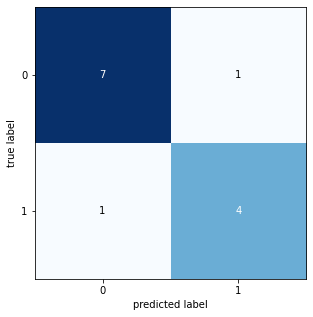

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



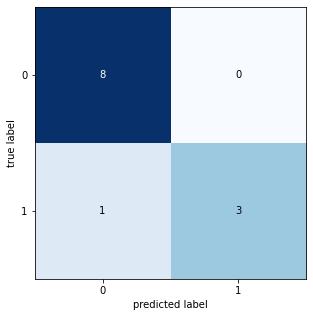

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



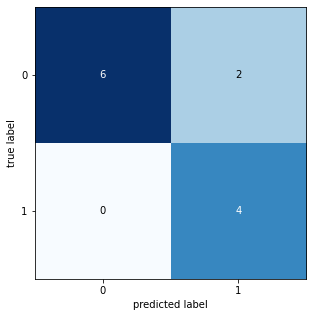

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



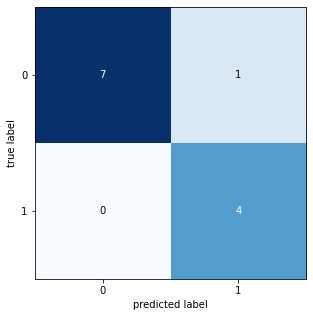

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8782749766573297
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  38.33703292199971
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
F-1 Score terbaik : 0.893781512605042  || Akurasi terbaik : 0.9025641025641026  || jumlah fitur : 49

Running Time:  1833.4874422189996


In [13]:
Colon_IG_GA = GeneticAlgorithm(Colon_IG, 2)

Generation : 0
gene : [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92

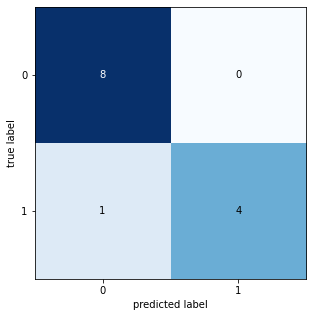

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.40      0.57         5

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



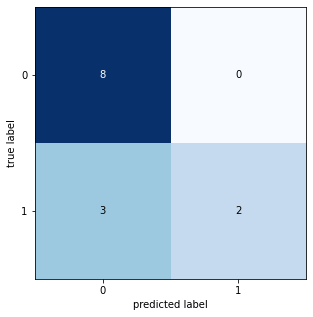

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



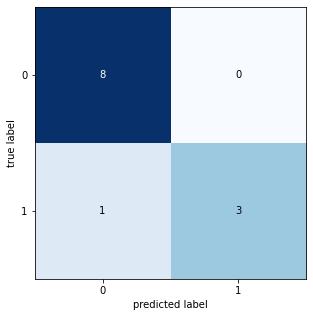

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



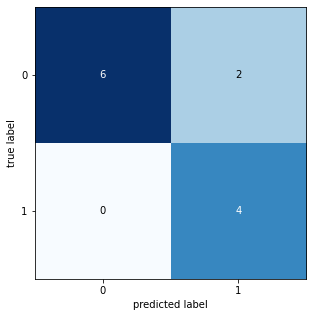

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



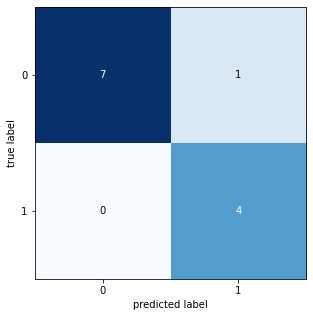

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8521283601159763
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  38.340529544000674
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

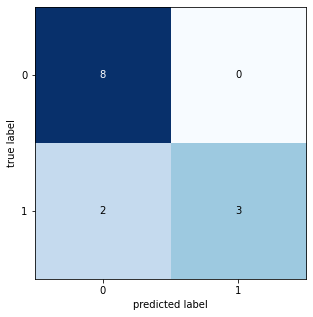

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



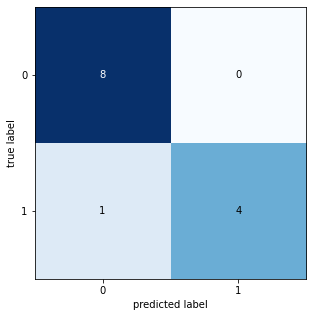

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



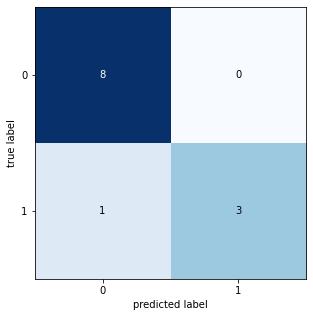

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



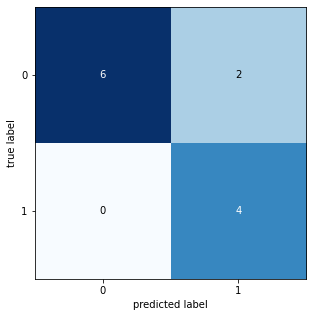

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



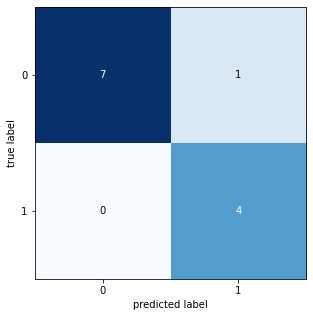

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.54622135200043
gene : [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

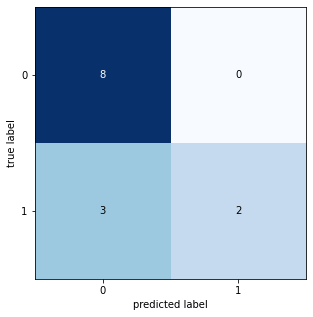

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



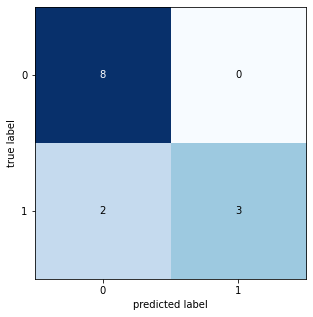

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



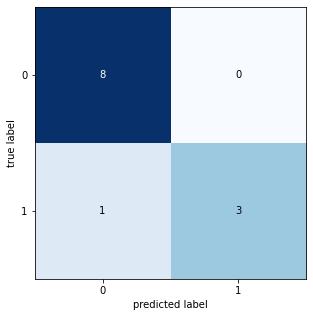

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



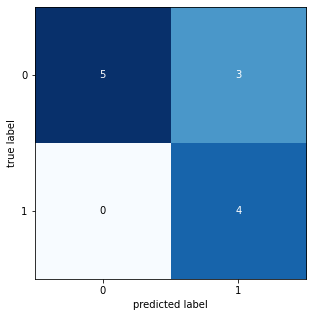

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



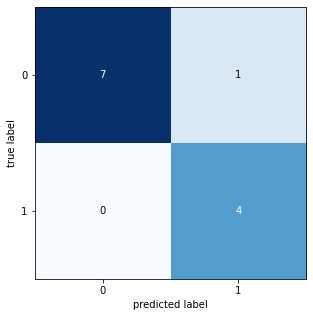

avg accuraccy Colon Cancer =  0.8397435897435898
avg F1_Score Colon Cancer =  0.8169467769932167
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.360700395000094
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8461538461538

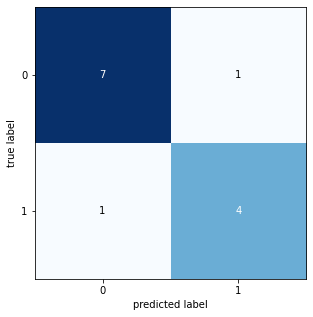

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



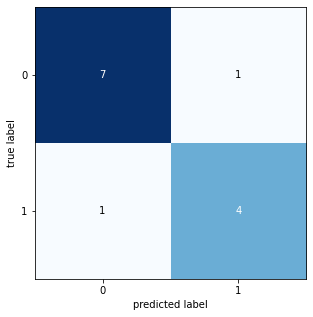

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


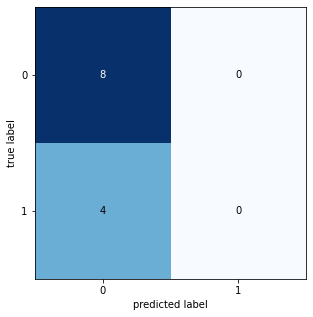

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



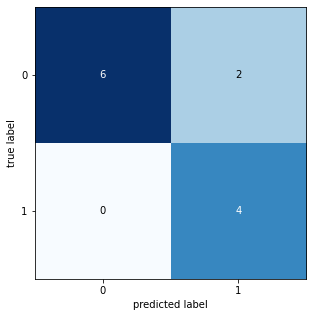

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



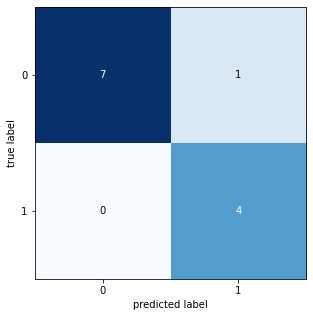

avg accuraccy Colon Cancer =  0.8217948717948719
avg F1_Score Colon Cancer =  0.762936507936508
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  37.91894382499959
gene : [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8461538461538461

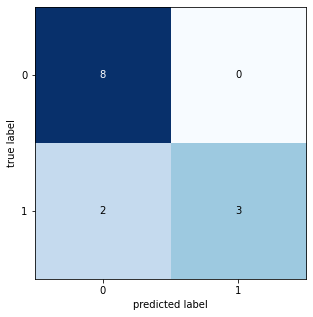

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



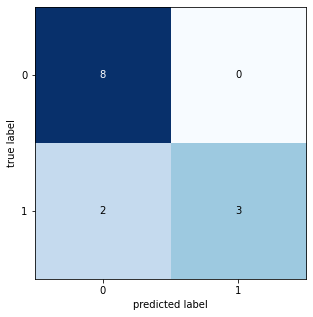

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



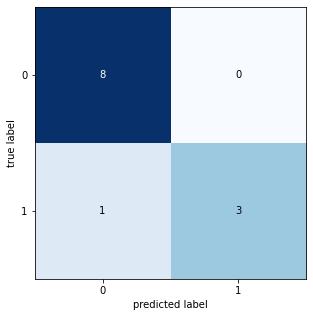

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



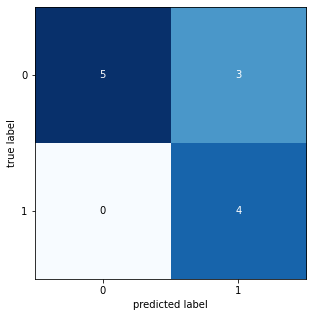

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



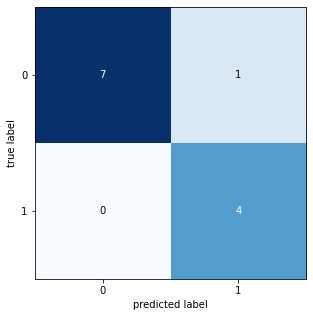

avg accuraccy Colon Cancer =  0.8551282051282051
avg F1_Score Colon Cancer =  0.8394822824234589
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7482517482517483
Running Time:  36.398195617000056
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9230769230769

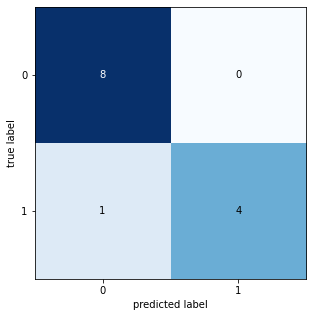

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



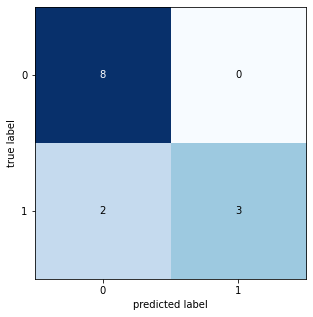

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



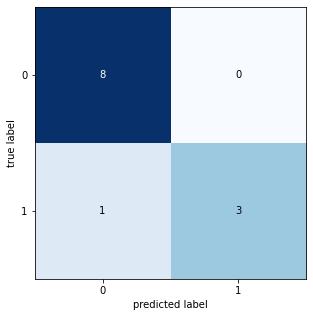

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



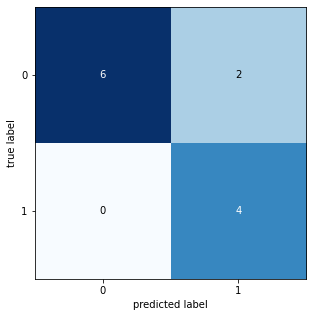

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



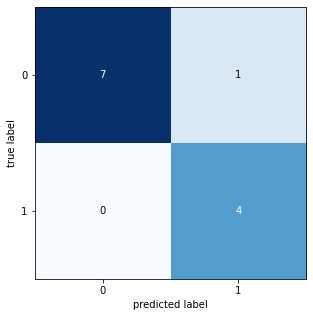

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.64897011999983
gene : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

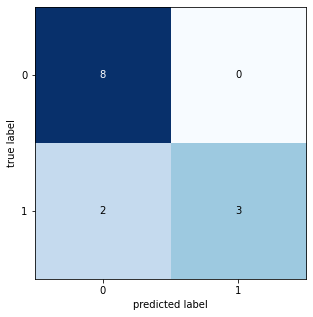

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



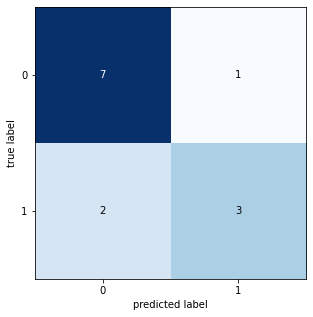

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



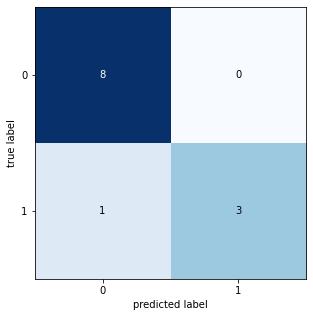

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



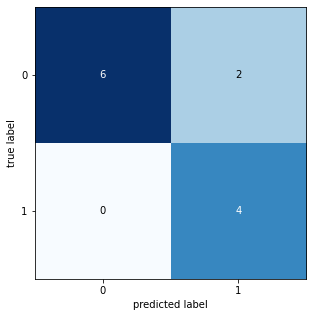

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



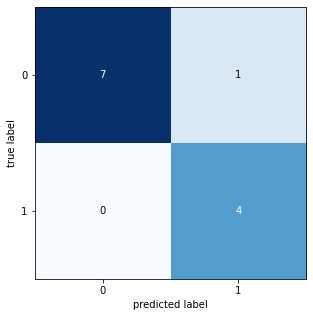

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  37.59479864599962
gene : [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

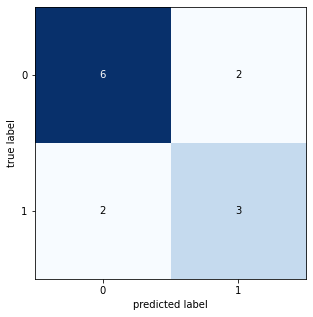

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



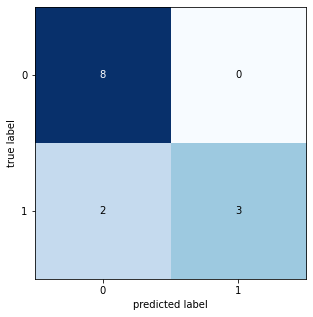

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



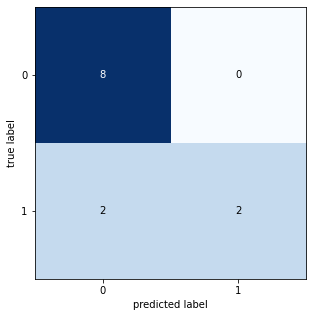

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



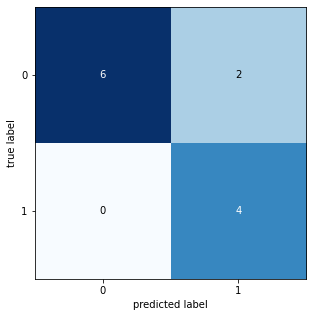

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



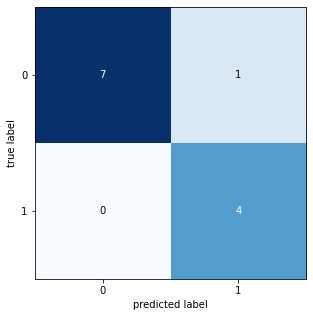

avg accuraccy Colon Cancer =  0.8243589743589744
avg F1_Score Colon Cancer =  0.8023809523809524
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.675
Running Time:  36.1656942339996
gene : [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92307692307692

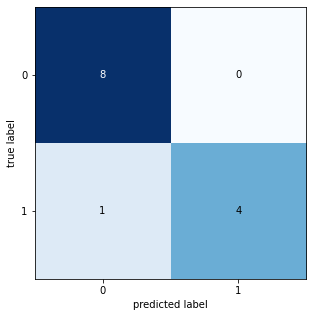

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



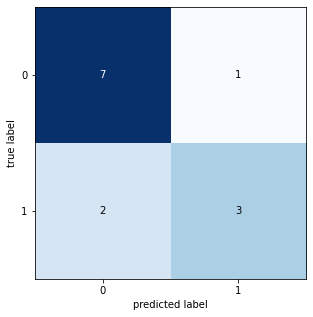

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



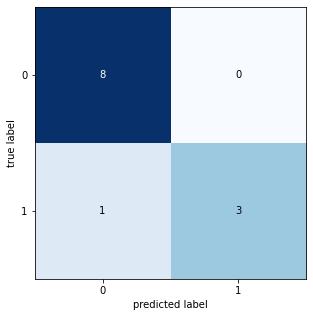

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



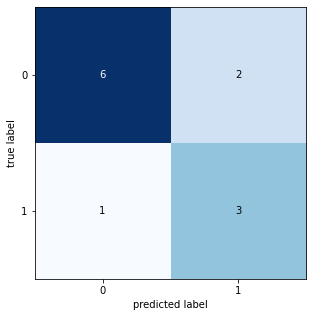

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



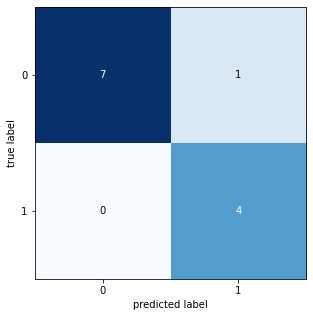

avg accuraccy Colon Cancer =  0.8551282051282051
avg F1_Score Colon Cancer =  0.8407469654528479
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7333333333333332
Running Time:  37.14191239699994
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615384615384

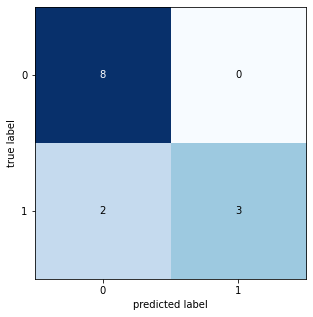

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.40      0.57         5

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



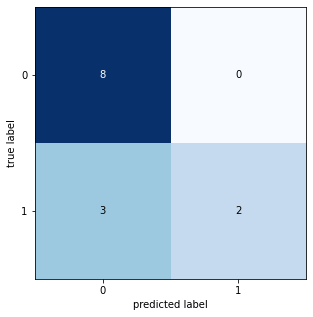

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



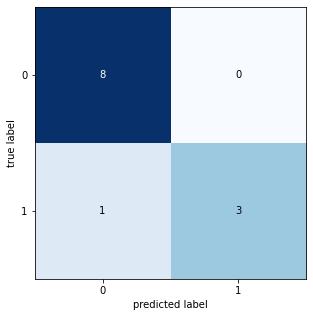

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



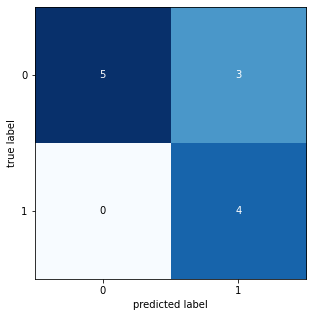

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



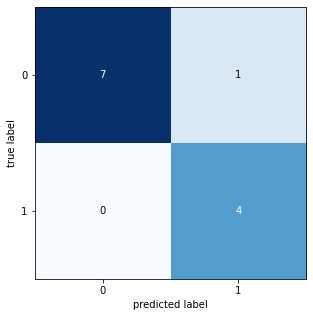

avg accuraccy Colon Cancer =  0.8397435897435898
avg F1_Score Colon Cancer =  0.8169467769932167
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.5531797980002
gen terbaik : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.8746638655462184  || Akurasi terbaik : 0.8871794871794872  || jumlah fitur : 47

Generation : 1
gene : [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0

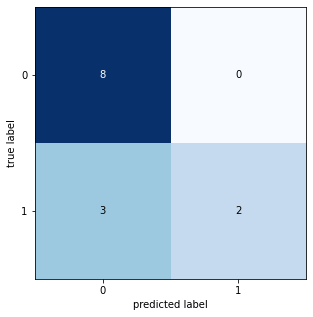

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



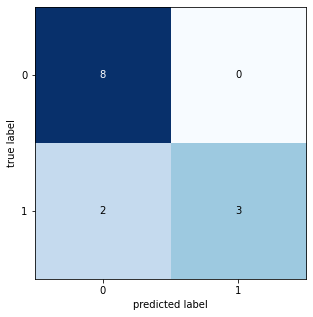

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



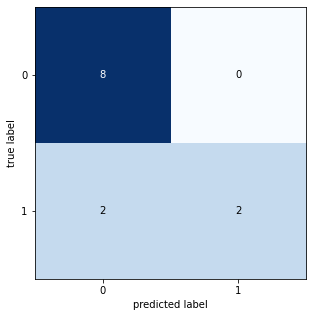

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



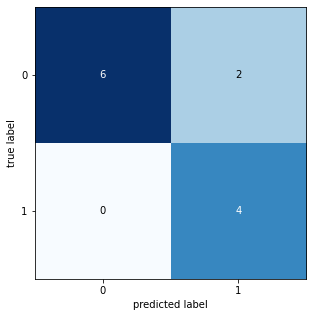

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



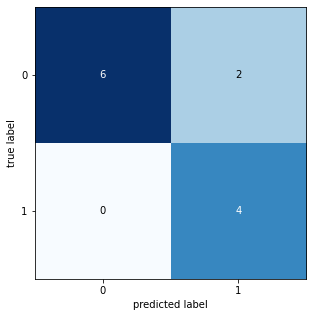

avg accuraccy Colon Cancer =  0.8230769230769232
avg F1_Score Colon Cancer =  0.7922263993316625
max accuraccy Colon Cancer =  0.8461538461538461
max F1_Score Colon Cancer =  0.8285714285714285
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  35.708820810999896
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

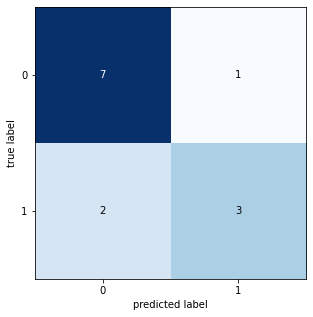

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



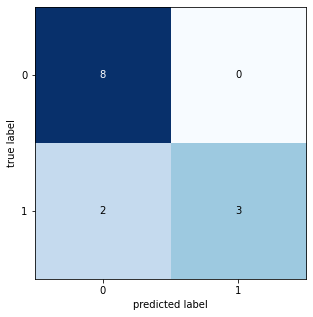

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



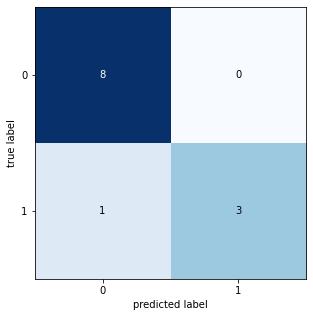

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



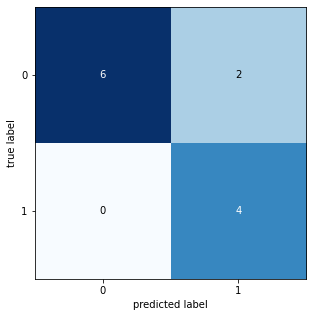

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



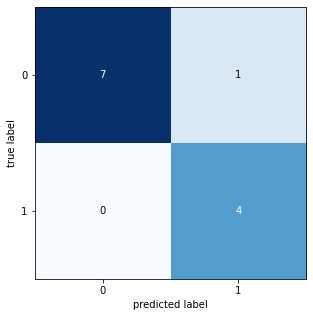

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  38.2450840169995
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

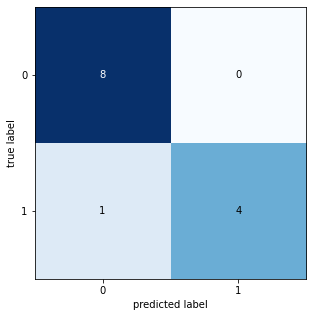

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



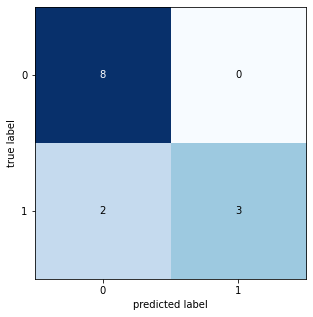

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



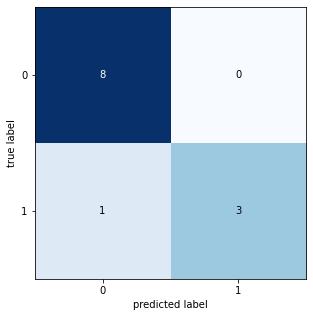

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



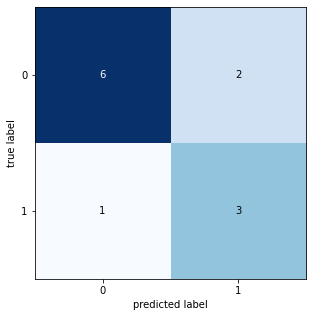

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



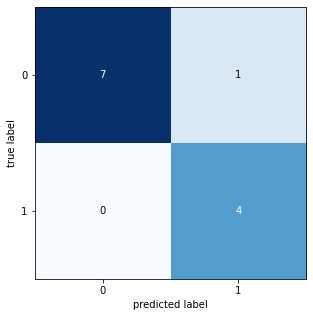

avg accuraccy Colon Cancer =  0.8705128205128204
avg F1_Score Colon Cancer =  0.8556162464985995
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7333333333333332
Running Time:  34.58361937599966
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.61538461538461

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


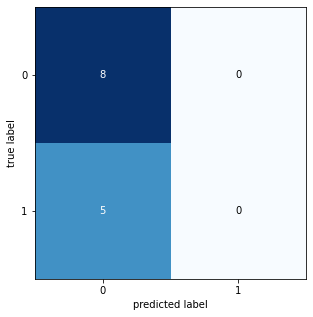

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



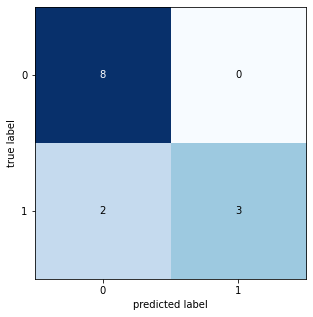

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



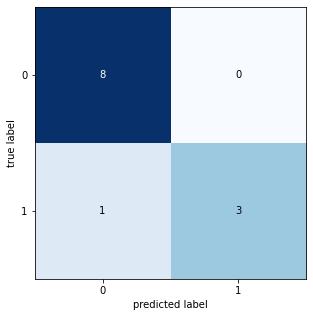

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.6571428571428571
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.50      0.75      0.60         4

    accuracy                           0.67        12
   macro avg       0.67      0.69      0.66        12
weighted avg       0.72      0.67      0.68        12



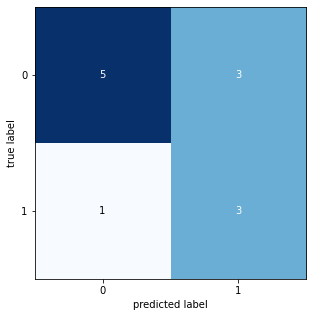

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



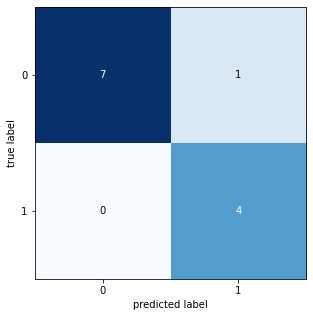

avg accuraccy Colon Cancer =  0.7923076923076923
avg F1_Score Colon Cancer =  0.7335620915032679
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  36.796478390999255
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

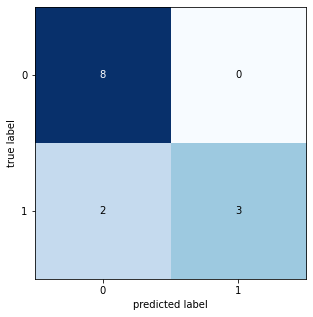

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



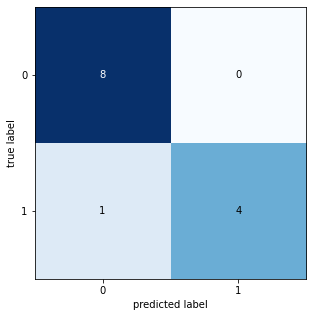

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



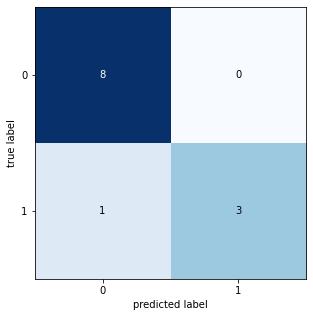

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



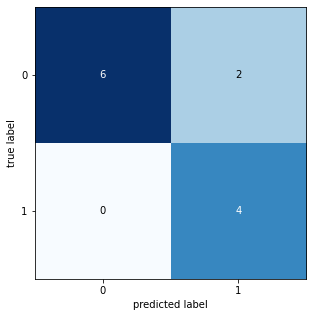

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



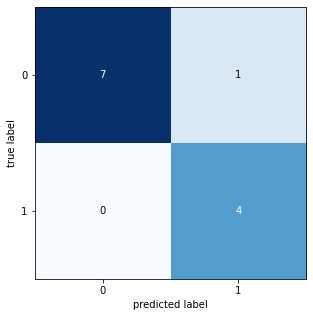

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.795665402999475
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

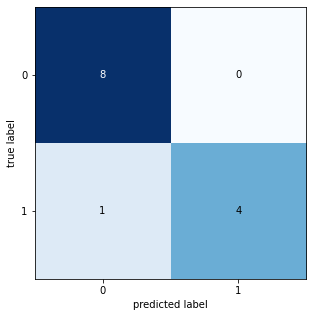

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



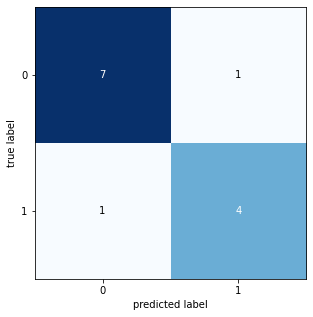

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



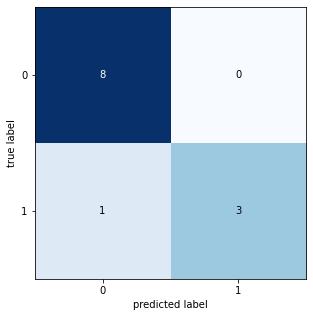

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



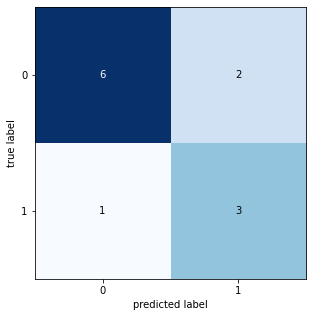

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



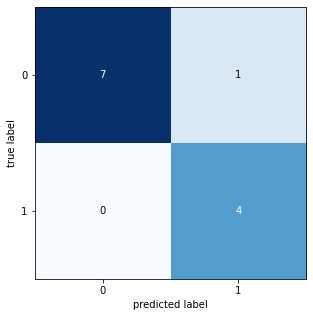

avg accuraccy Colon Cancer =  0.8705128205128204
avg F1_Score Colon Cancer =  0.8592273576097107
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7333333333333332
Running Time:  37.55889260399999
gene : [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92307692307692

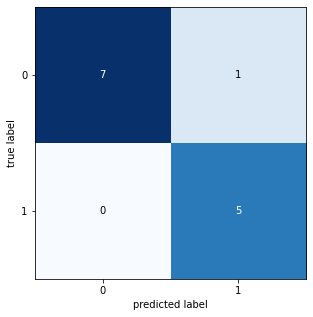

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



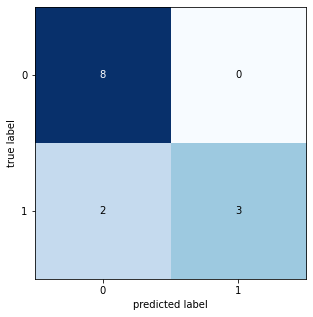

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



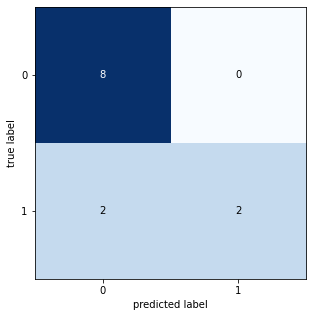

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



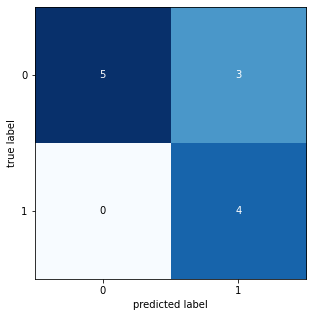

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



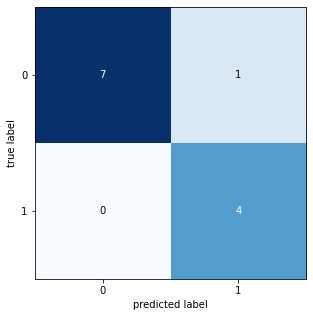

avg accuraccy Colon Cancer =  0.8538461538461538
avg F1_Score Colon Cancer =  0.8355594405594406
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9212121212121211
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7482517482517483
Running Time:  35.159702961999756
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8461538461538

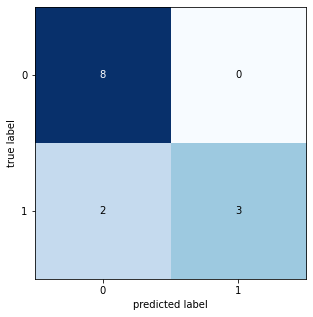

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



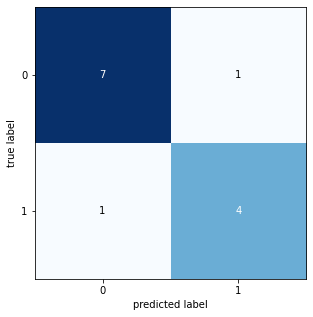

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



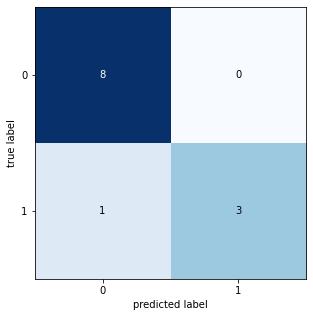

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



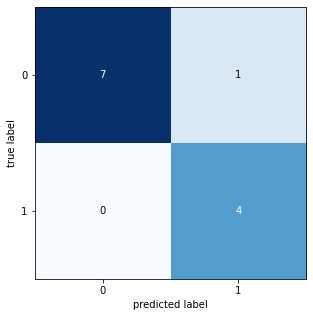

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



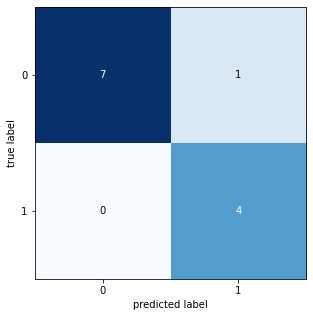

avg accuraccy Colon Cancer =  0.8884615384615385
avg F1_Score Colon Cancer =  0.8756652661064427
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8461538461538461
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.69741974699991
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

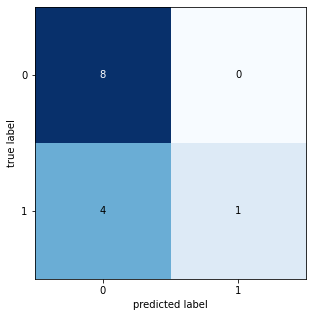

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



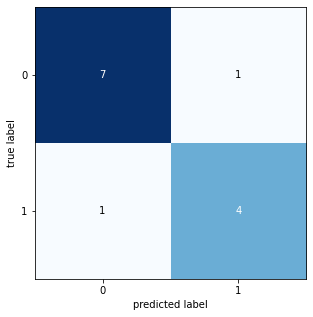

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



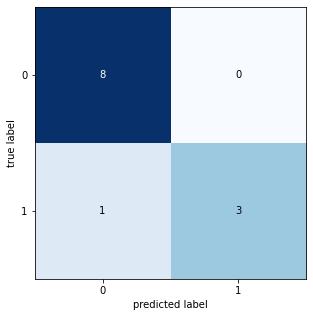

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



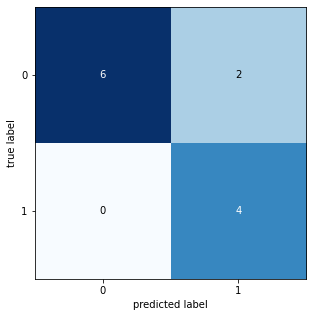

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



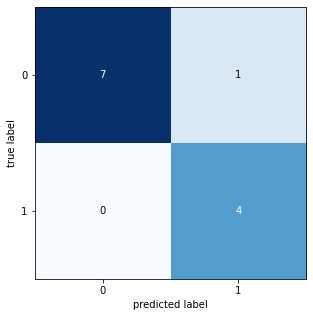

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8086017740429506
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.7672210439996
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92

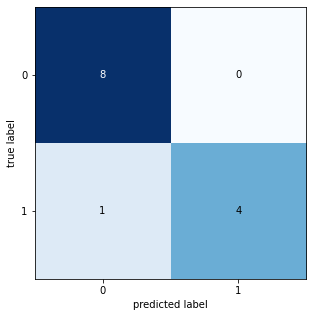

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



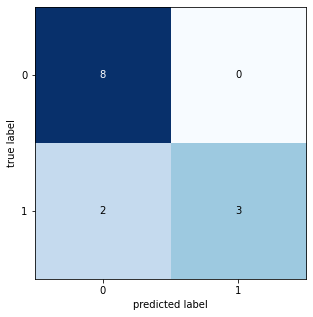

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



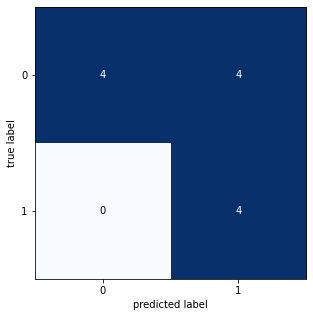

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.6571428571428571
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.50      0.75      0.60         4

    accuracy                           0.67        12
   macro avg       0.67      0.69      0.66        12
weighted avg       0.72      0.67      0.68        12



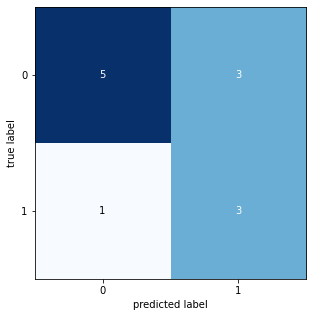

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



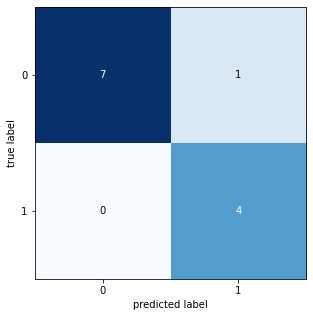

avg accuraccy Colon Cancer =  0.8038461538461539
avg F1_Score Colon Cancer =  0.7938795518207282
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6571428571428571
Running Time:  37.0433116130007
gen terbaik : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.8756652661064427  || Akurasi terbaik : 0.8884615384615385  || jumlah fitur : 43

Generation : 2
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,

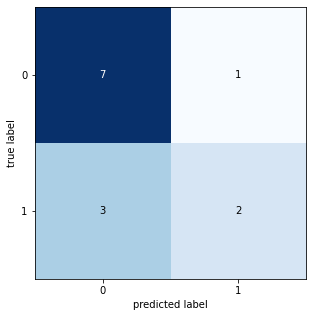

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



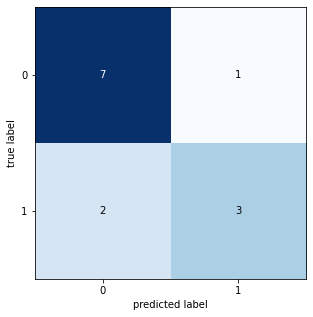

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



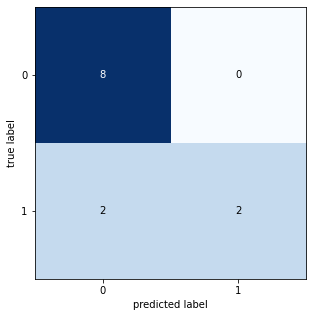

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



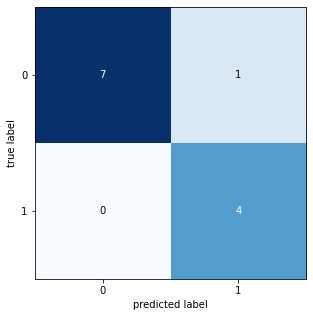

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



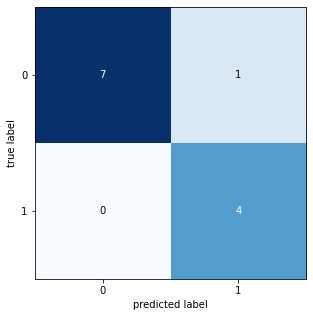

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7967973856209151
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.6388888888888888
Running Time:  37.622965427000054
gene : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

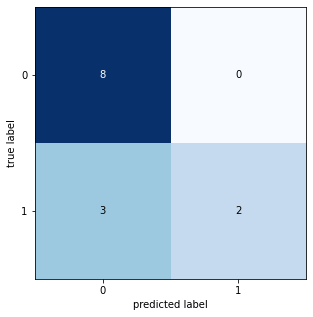

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



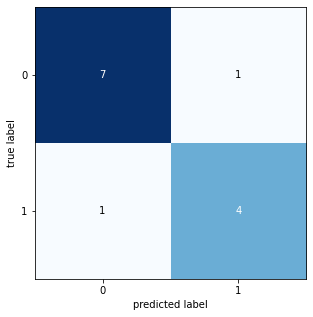

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



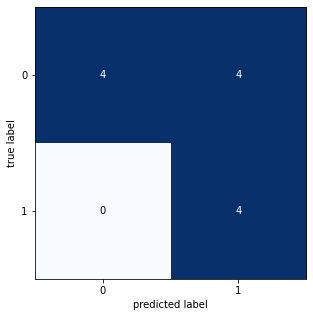

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



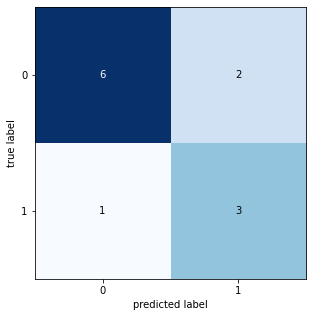

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



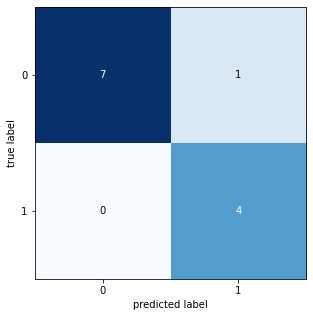

avg accuraccy Colon Cancer =  0.7897435897435897
avg F1_Score Colon Cancer =  0.771075605680869
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.6666666666666666
Running Time:  37.39363936799964
gene : [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

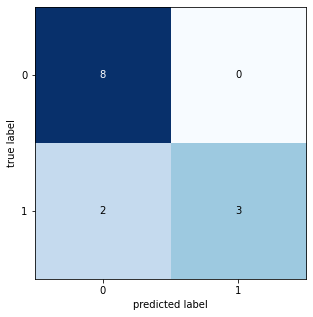

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



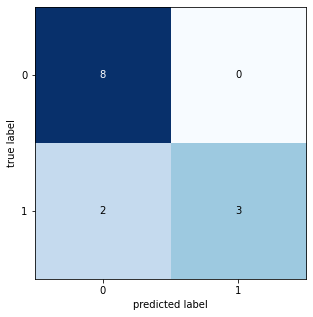

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



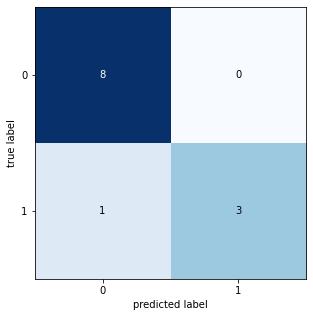

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



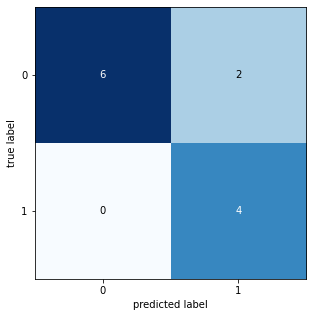

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



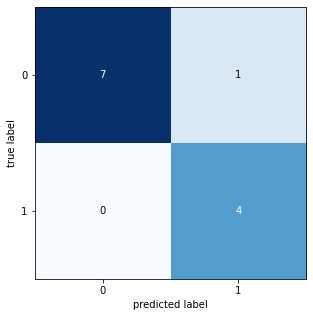

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.52313461799986
gene : [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

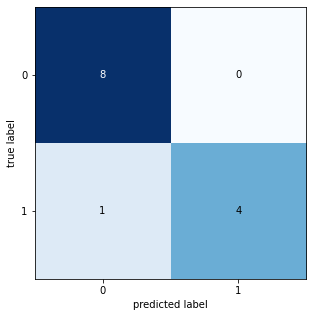

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



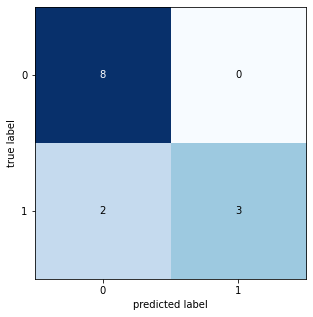

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



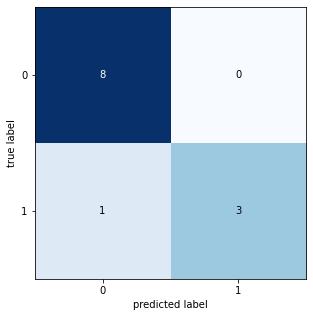

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



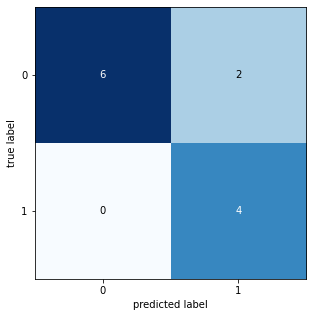

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



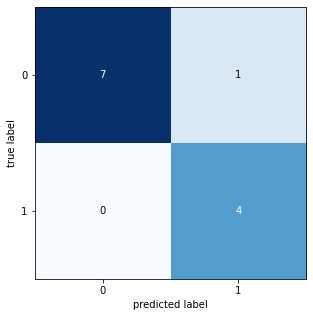

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.15924137099955
gene : [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


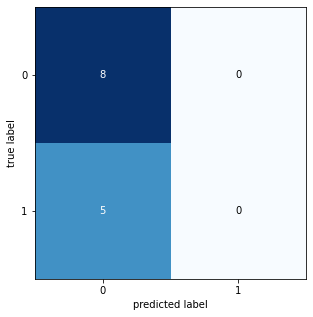

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



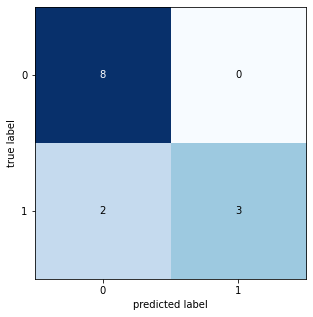

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



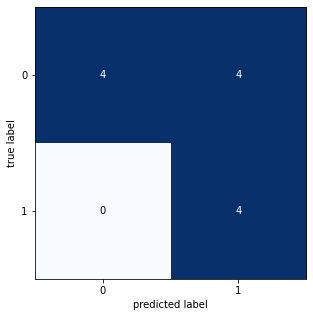

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



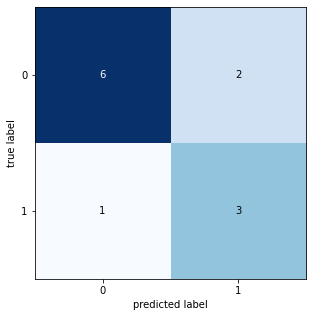

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



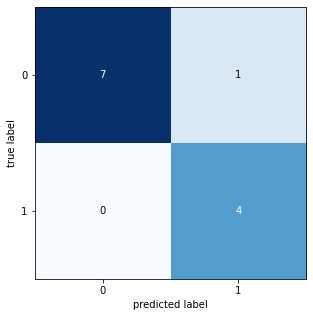

avg accuraccy Colon Cancer =  0.7589743589743589
avg F1_Score Colon Cancer =  0.7023015873015874
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  38.28039724399969
gene : [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

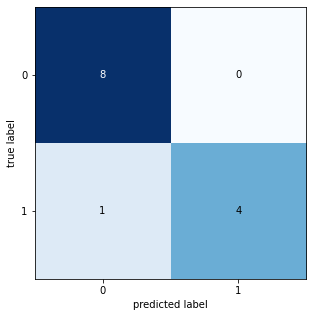

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



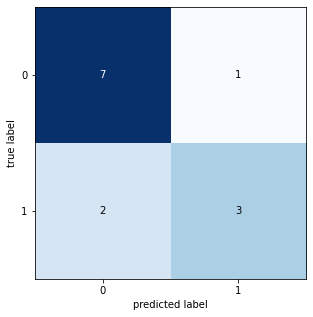

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



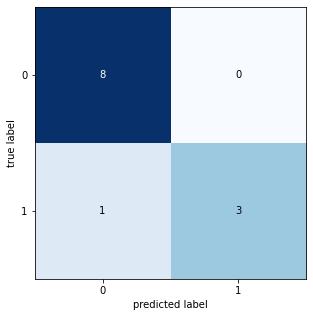

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



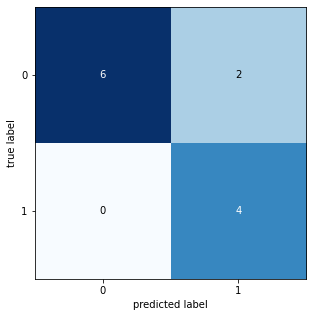

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



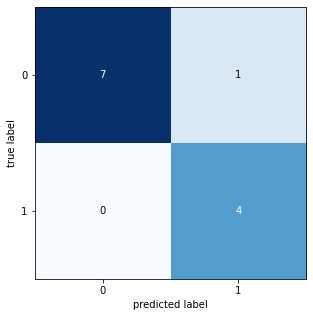

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8597945845004669
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  37.0931543050001
gene : [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8

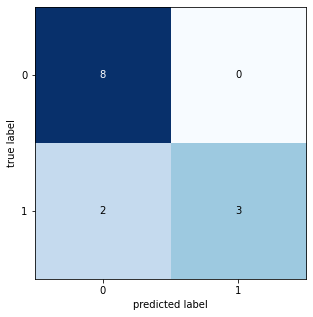

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



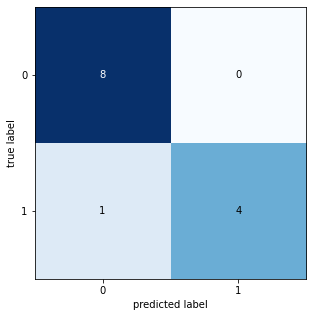

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



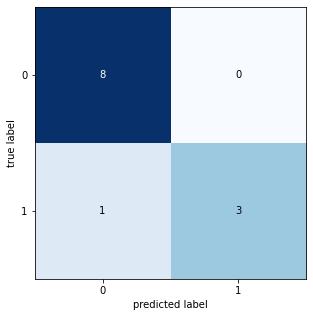

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



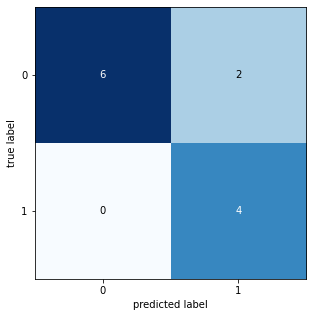

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



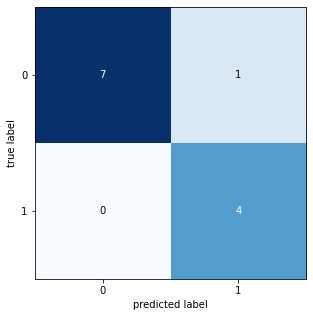

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.54298374099926
gene : [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

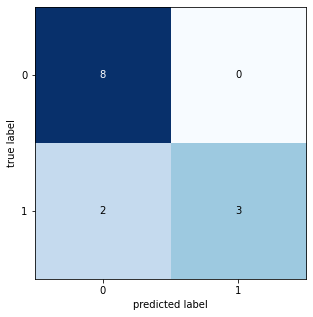

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



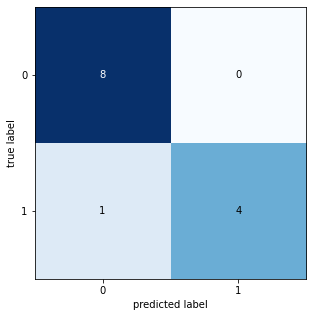

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



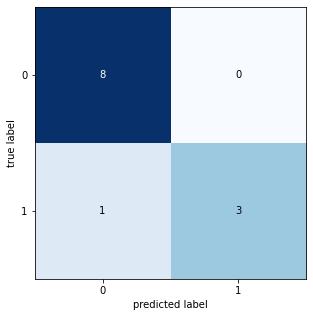

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



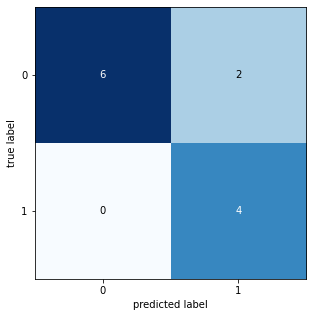

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



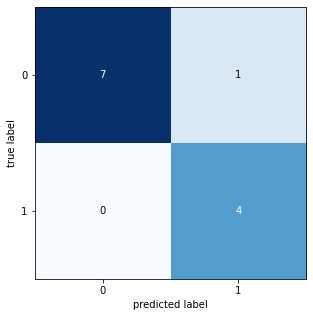

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.544675039999674
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

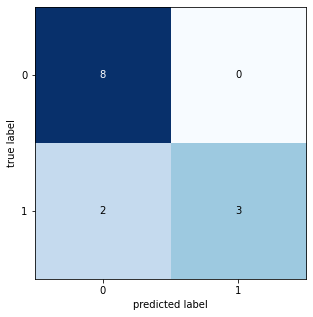

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



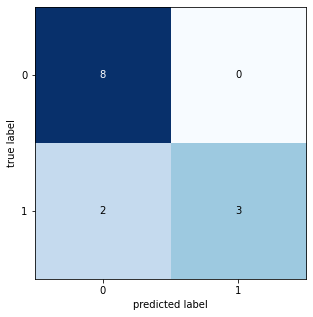

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



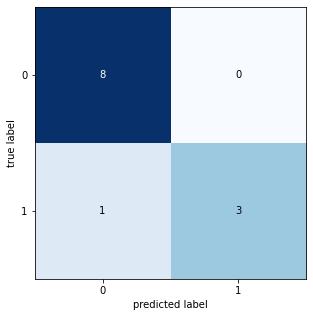

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



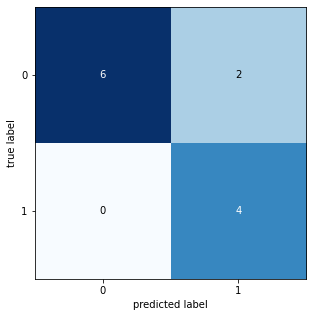

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



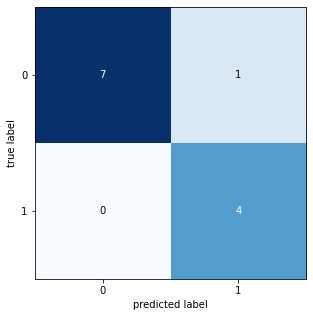

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.106294272000014
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

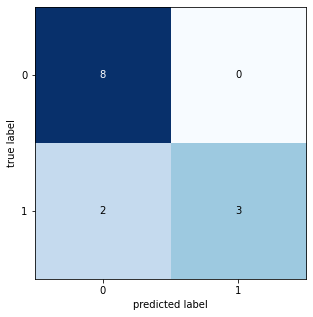

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



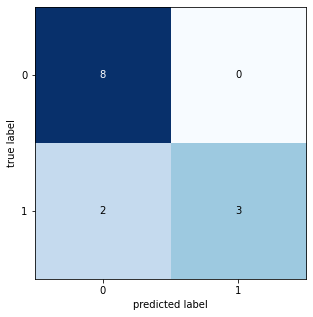

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



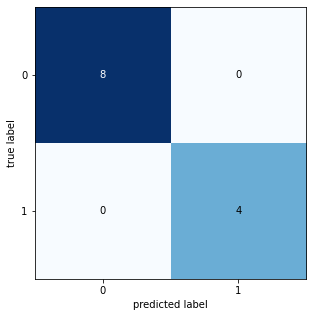

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



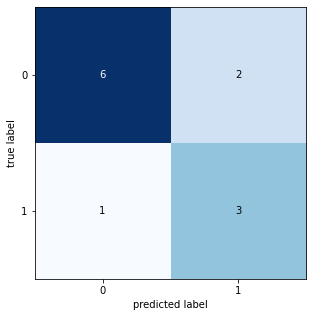

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



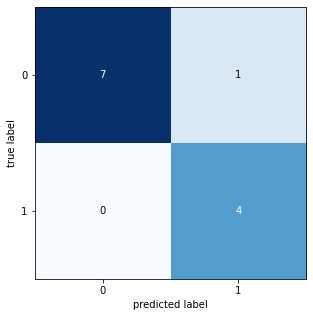

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8566666666666667
max accuraccy Colon Cancer =  1.0
max F1_Score Colon Cancer =  1.0
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7333333333333332
Running Time:  37.339597405999484
gen terbaik : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
F-1 Score terbaik : 0.8756652661064427  || Akurasi terbaik : 0.8884615384615385  || jumlah fitur : 43

Generation : 3
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,

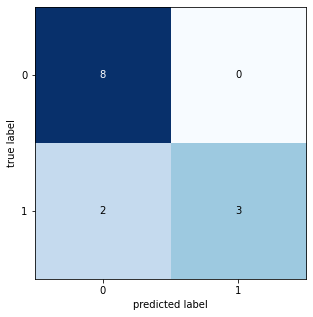

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



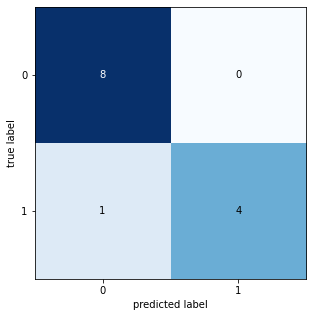

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



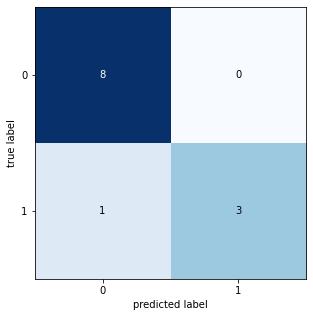

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



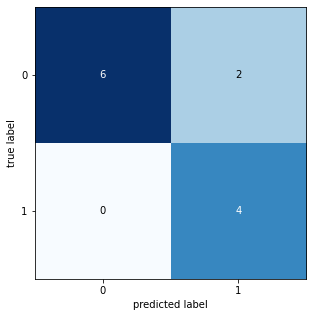

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



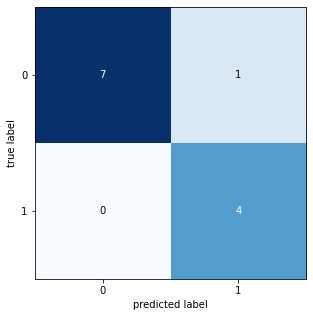

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.255066146999525
gene : [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

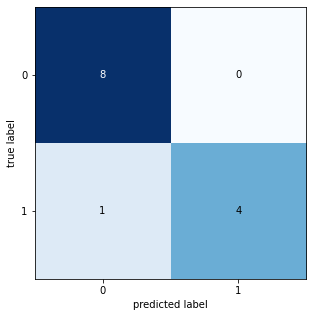

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



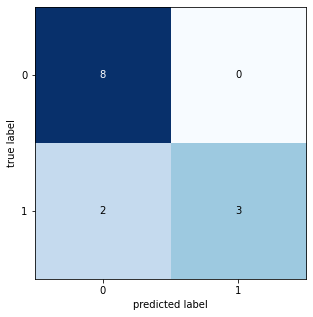

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



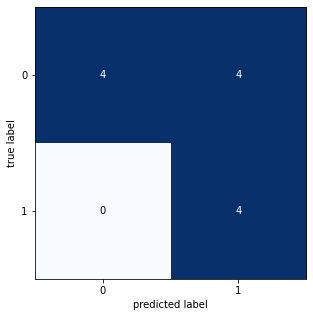

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.5
F1_Score :  0.48571428571428577
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.40      1.00      0.57         4

    accuracy                           0.50        12
   macro avg       0.70      0.62      0.49        12
weighted avg       0.80      0.50      0.46        12



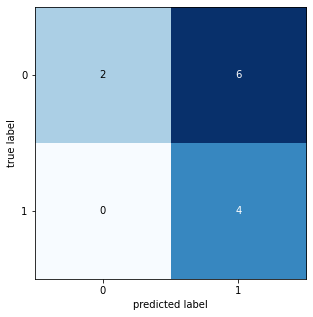

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



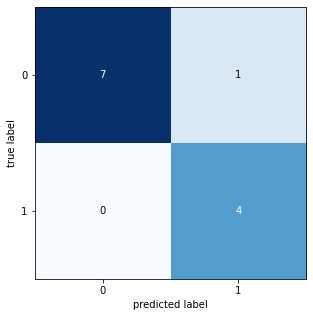

avg accuraccy Colon Cancer =  0.7705128205128204
avg F1_Score Colon Cancer =  0.7595938375350141
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.5
min F1_Score Colon Cancer =  0.48571428571428577
Running Time:  36.09680767100053
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.92307692307692

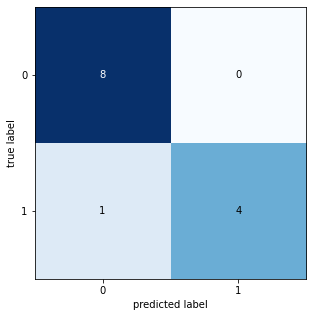

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



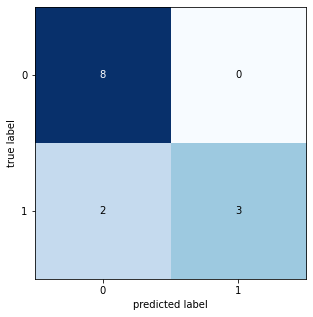

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



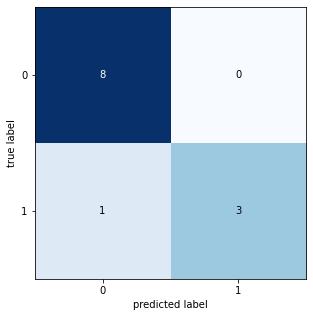

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



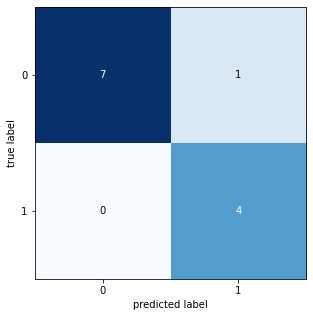

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



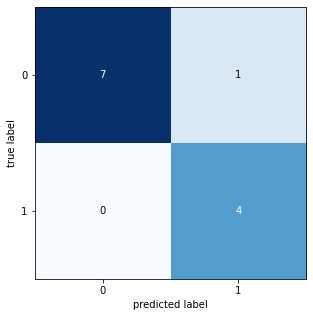

avg accuraccy Colon Cancer =  0.9038461538461539
avg F1_Score Colon Cancer =  0.8911718020541551
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8461538461538461
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  36.652142244999595
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

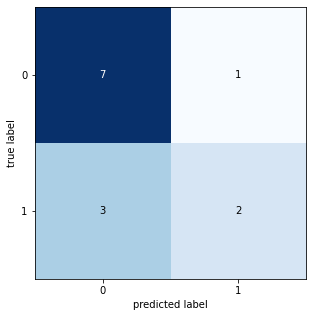

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



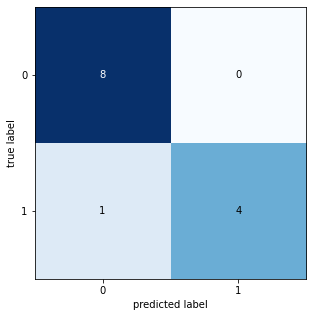

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



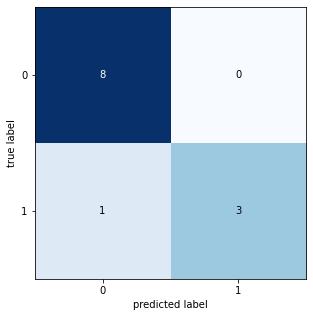

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



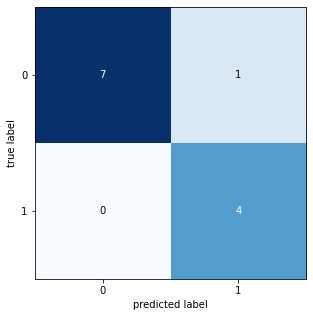

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



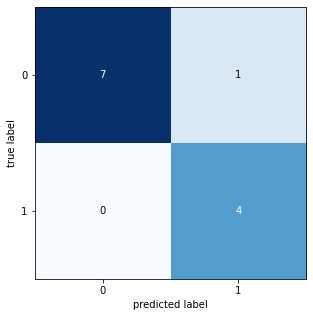

avg accuraccy Colon Cancer =  0.873076923076923
avg F1_Score Colon Cancer =  0.855060690943044
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.6388888888888888
Running Time:  38.83772181800032
gene : [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84

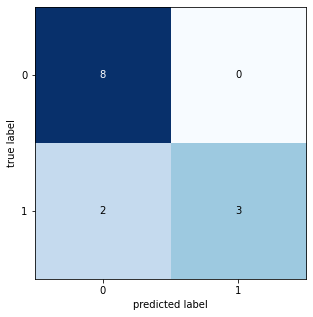

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



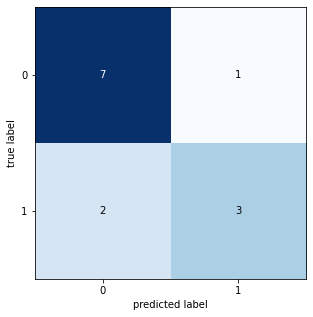

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



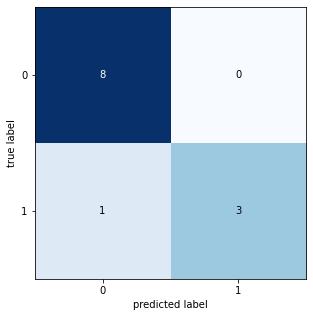

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



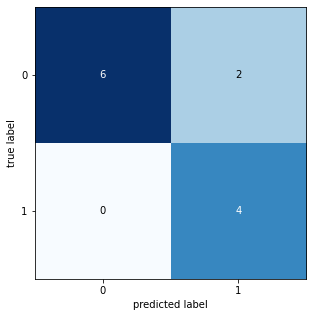

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



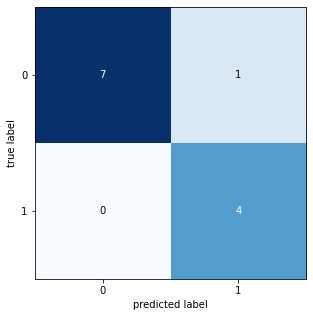

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  37.141074160000244
gene : [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

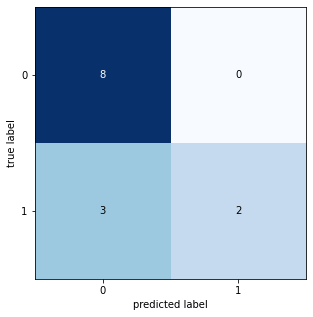

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



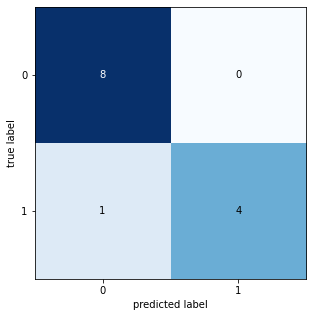

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



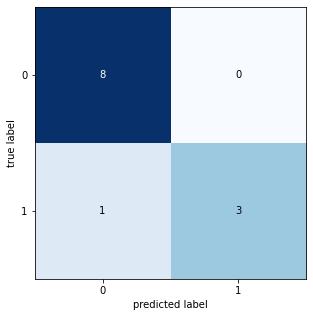

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



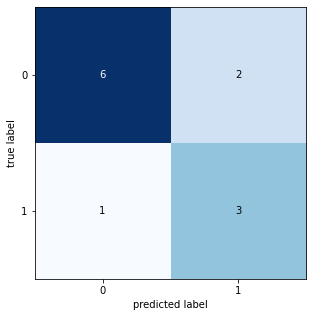

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



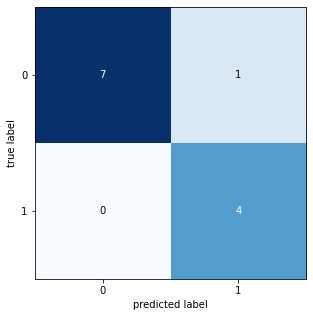

avg accuraccy Colon Cancer =  0.8551282051282051
avg F1_Score Colon Cancer =  0.8330807410683573
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.75
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  38.601753865999854
gene : [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8461538461538

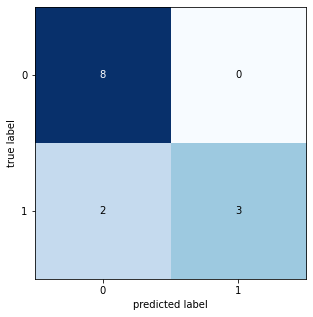

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



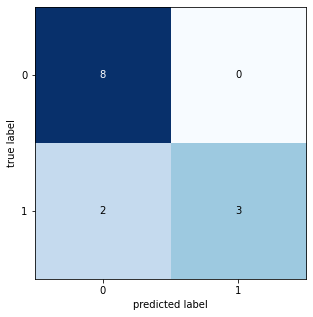

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



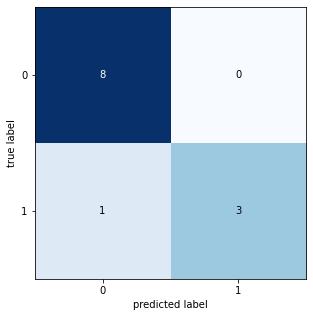

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



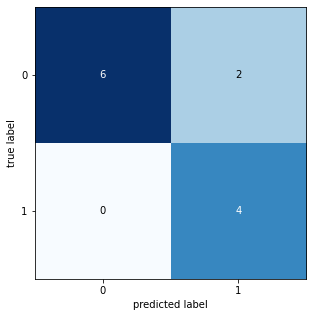

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



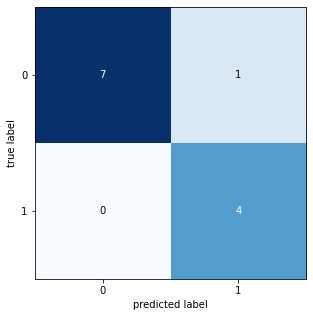

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.32844545500029
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7

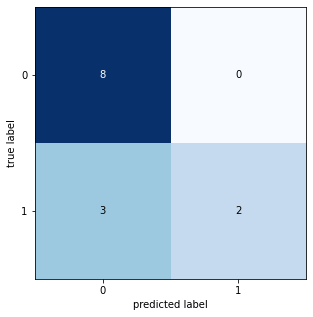

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



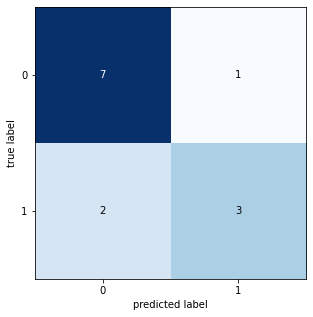

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


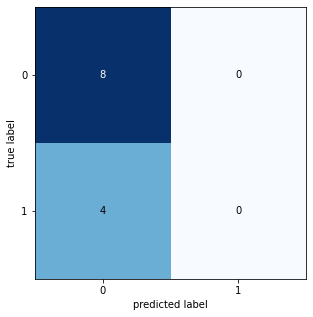

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



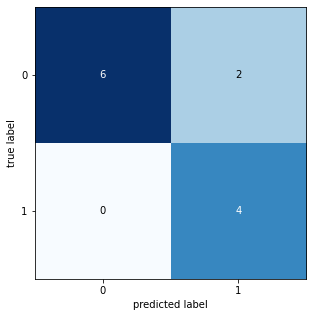

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



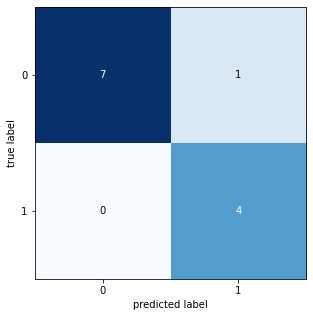

avg accuraccy Colon Cancer =  0.7910256410256411
avg F1_Score Colon Cancer =  0.7183094992382919
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  36.64755569299996
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.615384615384615

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


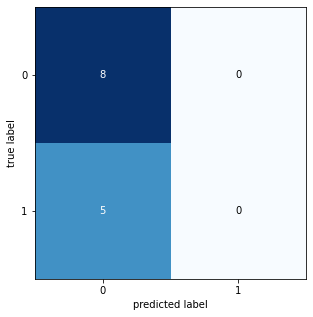

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



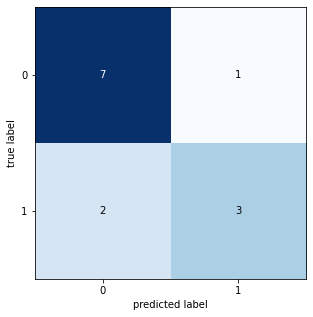

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



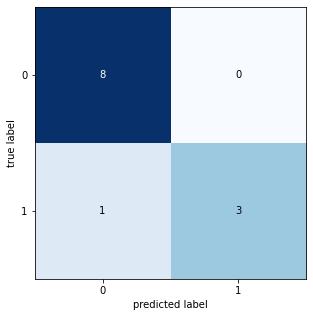

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



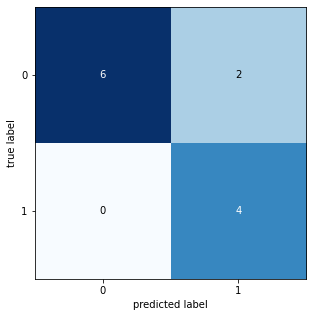

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



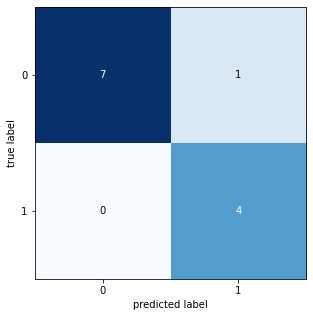

avg accuraccy Colon Cancer =  0.8102564102564103
avg F1_Score Colon Cancer =  0.7529785247432306
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  40.037132126999495
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

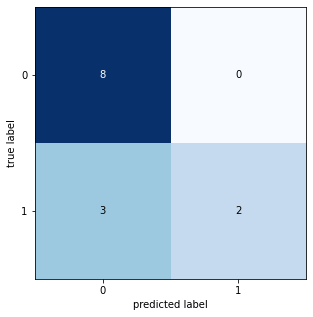

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



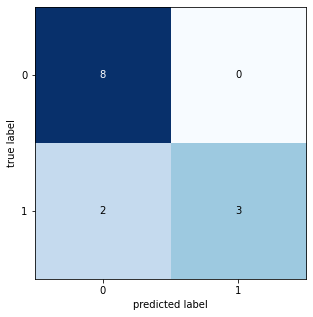

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.5833333333333334
F1_Score :  0.5804195804195804
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.44      1.00      0.62         4

    accuracy                           0.58        12
   macro avg       0.72      0.69      0.58        12
weighted avg       0.81      0.58      0.57        12



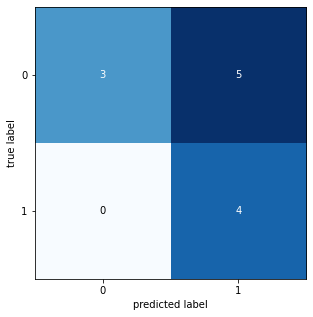

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



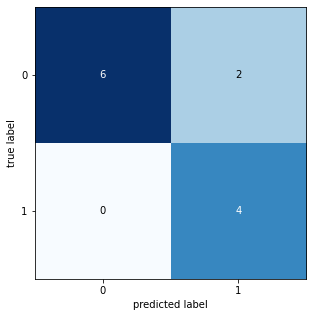

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



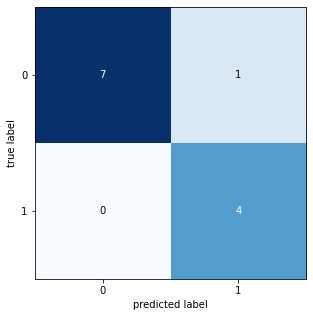

avg accuraccy Colon Cancer =  0.7897435897435898
avg F1_Score Colon Cancer =  0.7692626963679595
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.5833333333333334
min F1_Score Colon Cancer =  0.5804195804195804
Running Time:  37.40908020200004
gen terbaik : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.8911718020541551  || Akurasi terbaik : 0.9038461538461539  || jumlah fitur : 44

Generation : 4
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0

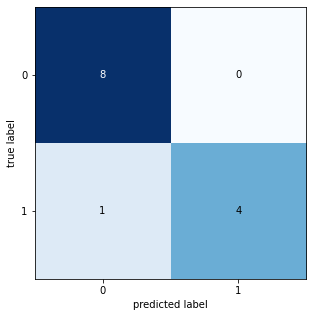

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



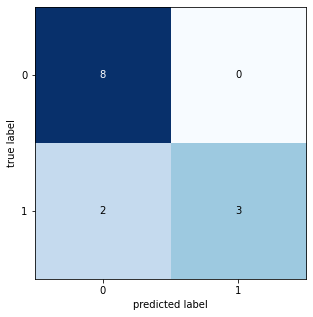

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



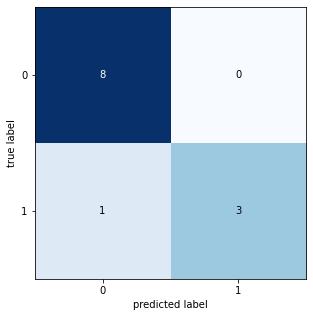

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



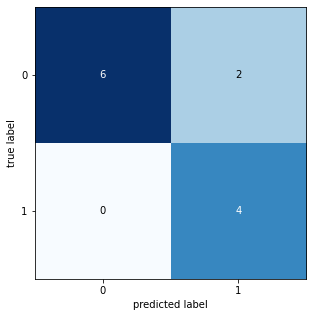

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



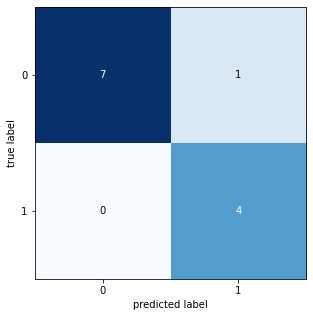

avg accuraccy Colon Cancer =  0.8871794871794872
avg F1_Score Colon Cancer =  0.8746638655462184
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.339411427000414
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

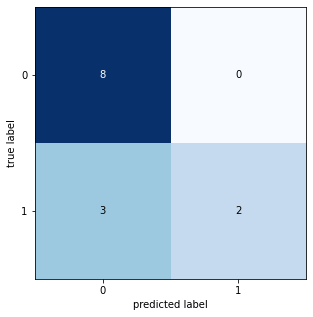

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



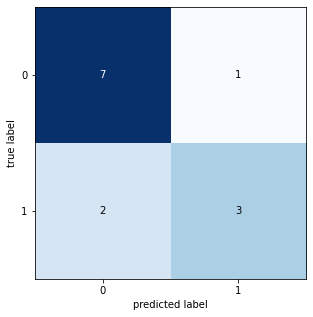

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


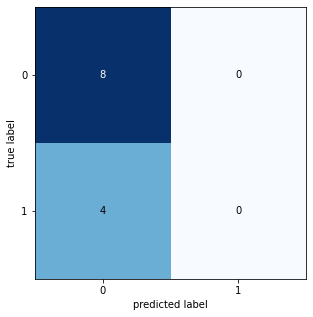

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7482517482517483
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.79      0.81      0.75        12
weighted avg       0.86      0.75      0.76        12



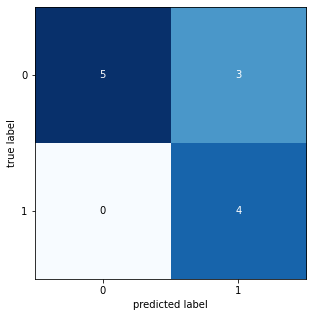

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



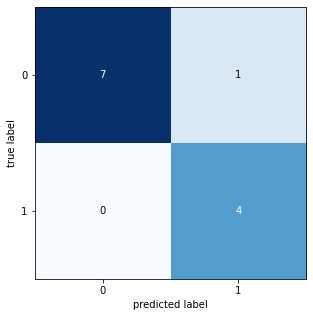

avg accuraccy Colon Cancer =  0.7743589743589744
avg F1_Score Colon Cancer =  0.7022455631743558
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  37.475637374000144
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615384615384

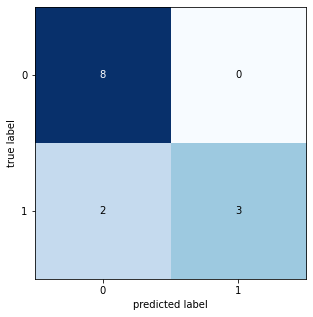

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



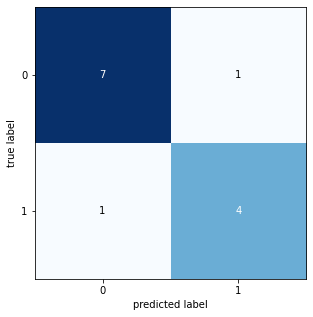

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



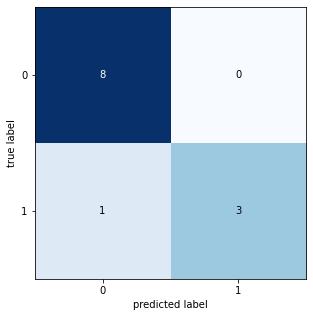

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



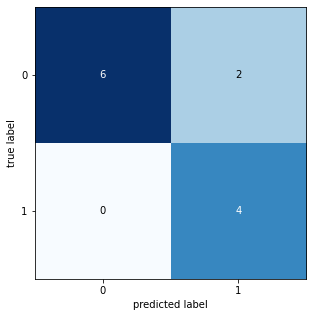

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



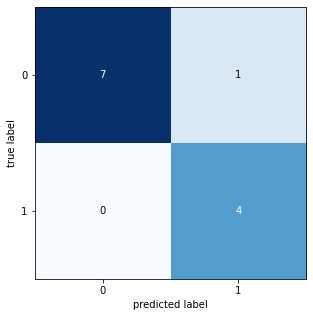

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8591573295985061
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  37.513488435
gene : [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.84615

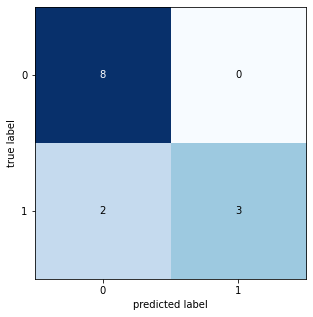

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



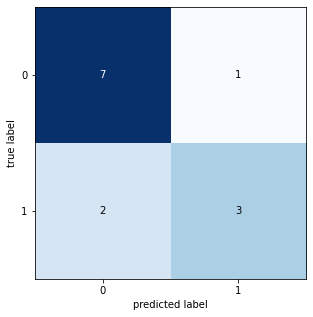

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



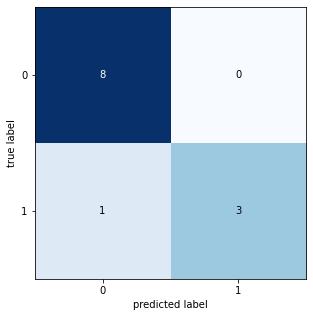

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



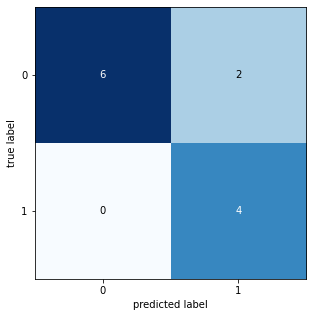

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



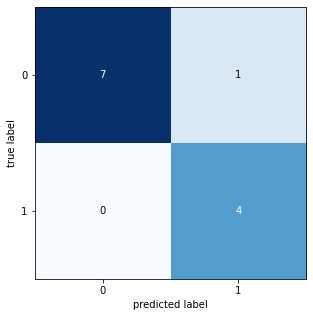

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8406769374416433
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7450980392156863
Running Time:  39.08430283799953
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

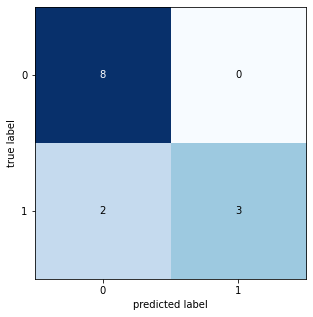

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



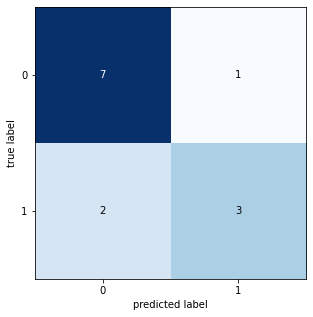

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.5833333333333334
F1_Score :  0.5804195804195804
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.43      0.75      0.55         4

    accuracy                           0.58        12
   macro avg       0.61      0.62      0.58        12
weighted avg       0.68      0.58      0.59        12



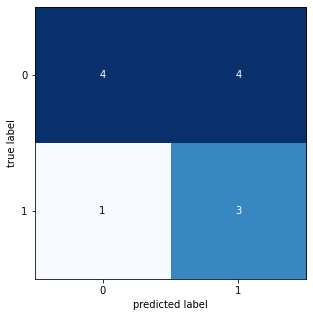

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



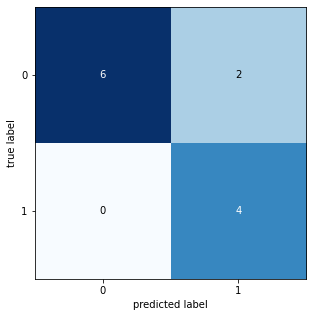

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



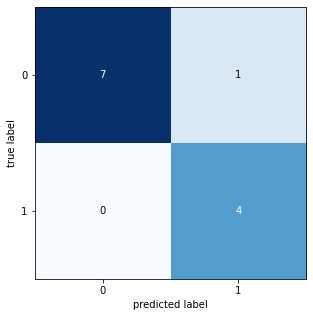

avg accuraccy Colon Cancer =  0.7897435897435898
avg F1_Score Colon Cancer =  0.7769289207524501
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.5833333333333334
min F1_Score Colon Cancer =  0.5804195804195804
Running Time:  37.87443122099921
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

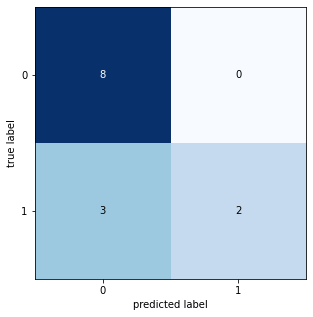

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



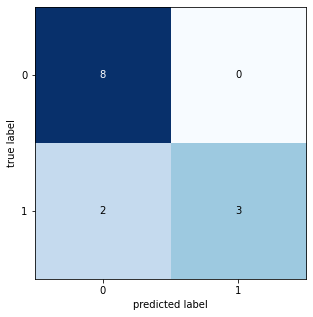

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



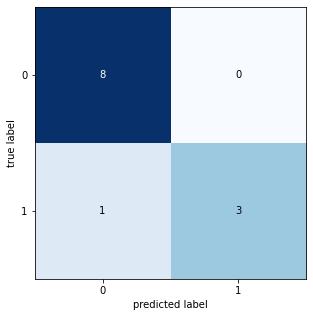

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



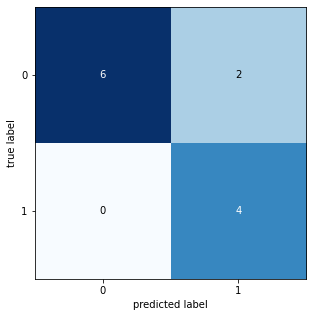

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



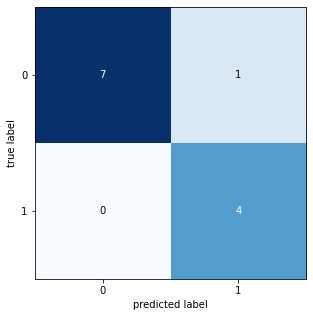

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.3887406570002
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6

/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


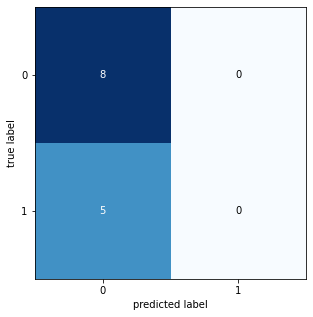

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



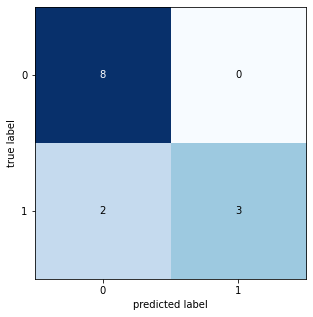

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



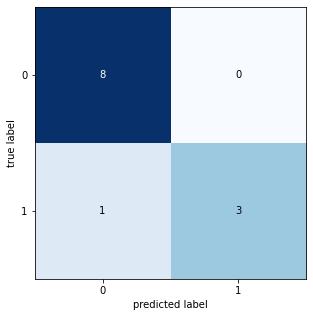

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



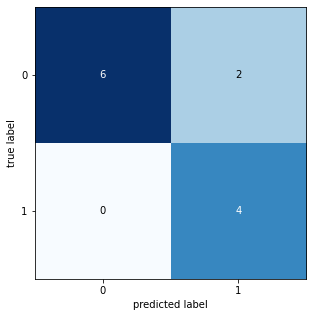

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



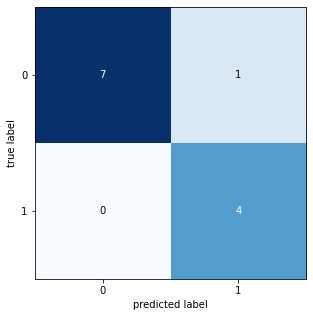

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7678478057889823
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.380952380952381
Running Time:  38.66840869999942
gene : [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7

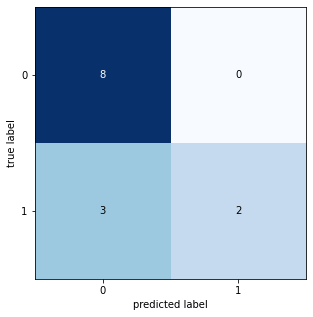

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



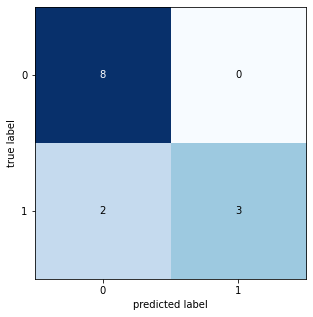

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8125
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.75      0.75      0.75         4

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12



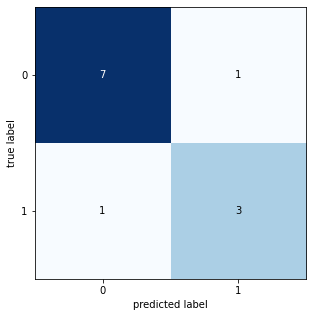

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



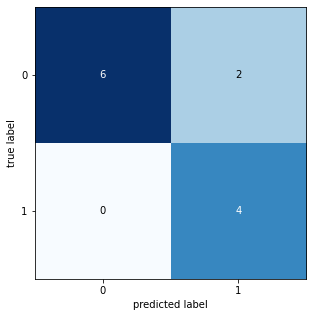

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



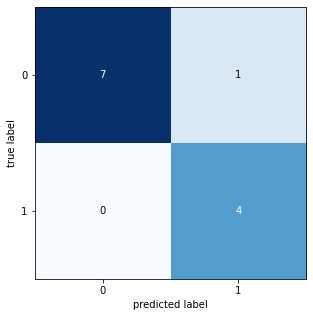

avg accuraccy Colon Cancer =  0.8397435897435898
avg F1_Score Colon Cancer =  0.8156787802840435
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.7942585589999
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.9

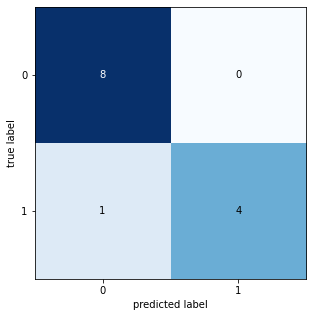

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



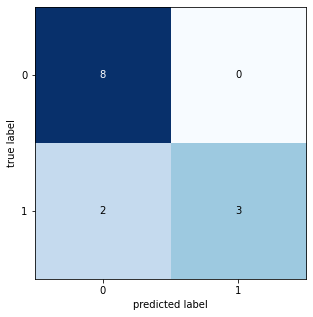

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



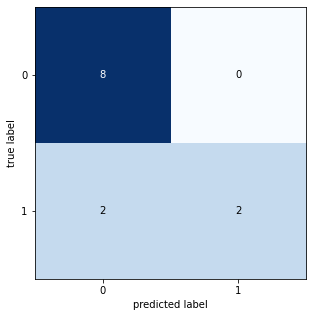

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



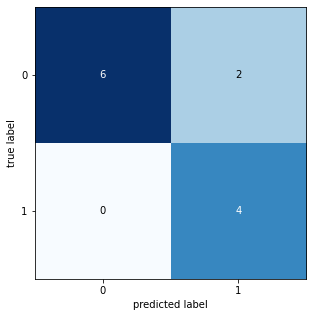

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



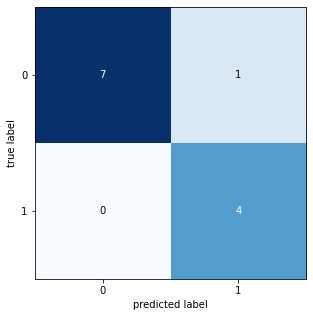

avg accuraccy Colon Cancer =  0.8705128205128206
avg F1_Score Colon Cancer =  0.8503874883286648
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.7777777777777778
Running Time:  37.219759503000205
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

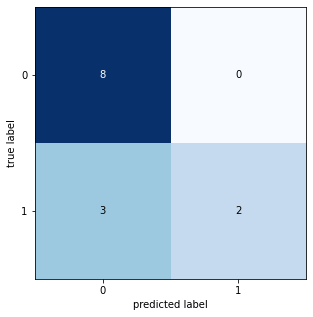

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



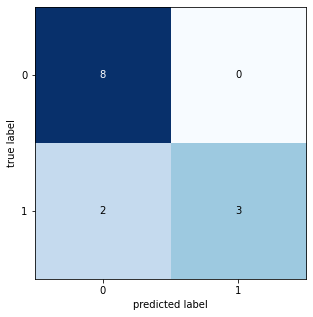

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



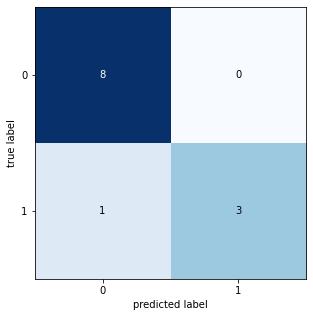

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



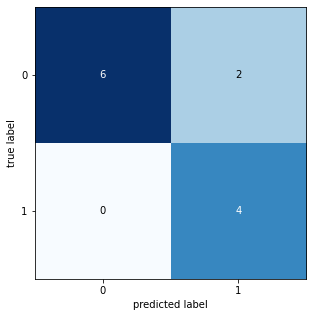

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



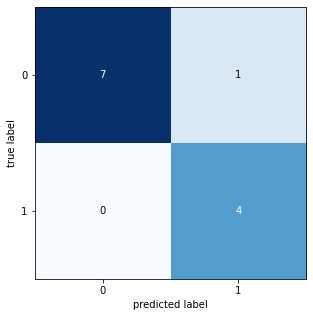

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.76505413199993
gen terbaik : [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.8911718020541551  || Akurasi terbaik : 0.9038461538461539  || jumlah fitur : 44

Running Time:  1876.5741909520002


In [14]:
Colon_IG_GA = GeneticAlgorithm(Colon_IG, 3)

Generation : 0
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.40      0.57         5

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71

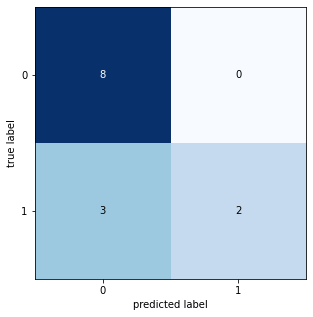

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



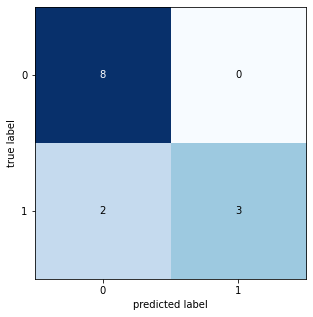

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



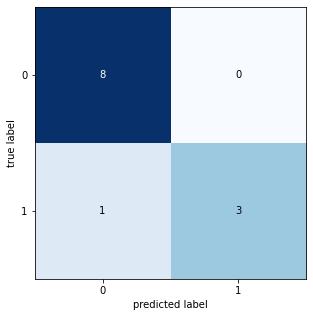

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



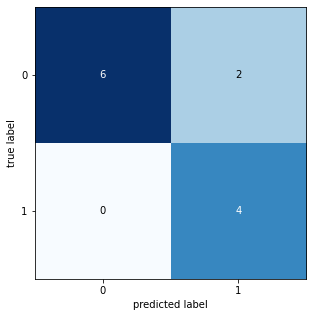

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



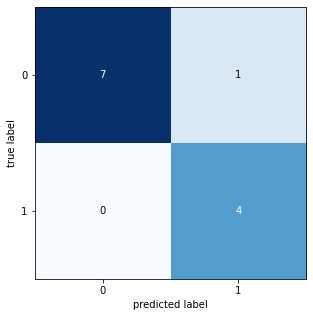

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  36.963611850000234
gene : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

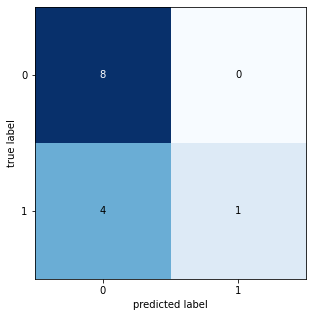

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



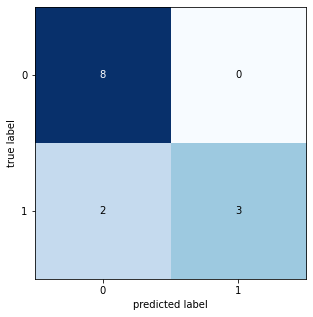

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



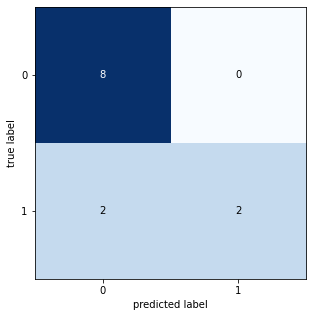

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



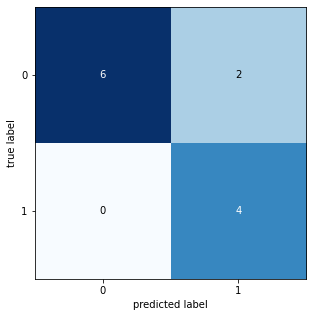

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



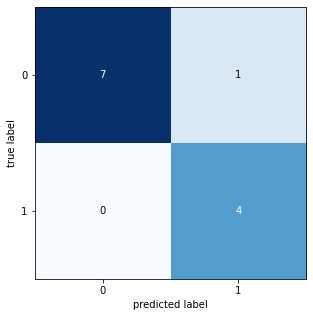

avg accuraccy Colon Cancer =  0.8243589743589744
avg F1_Score Colon Cancer =  0.7807142857142857
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  35.49318839699936
gene : [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

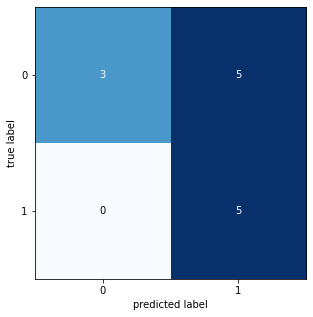

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



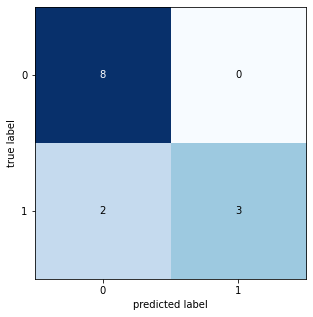

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



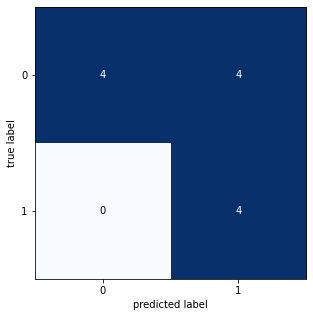

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



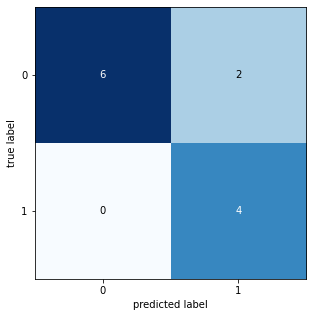

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



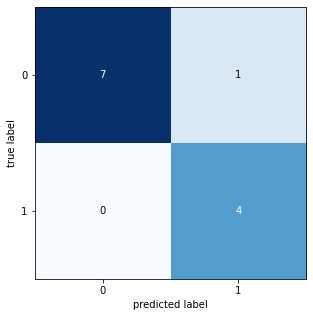

avg accuraccy Colon Cancer =  0.7756410256410257
avg F1_Score Colon Cancer =  0.7663708513708514
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6153846153846154
min F1_Score Colon Cancer =  0.606060606060606
Running Time:  38.187737101000494
gene : [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

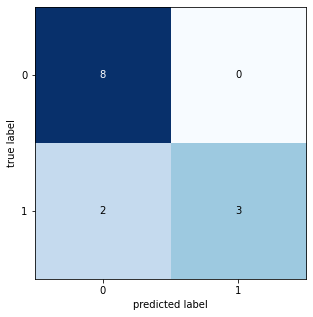

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



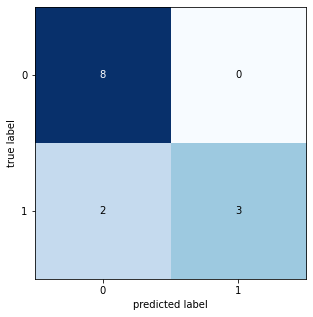

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



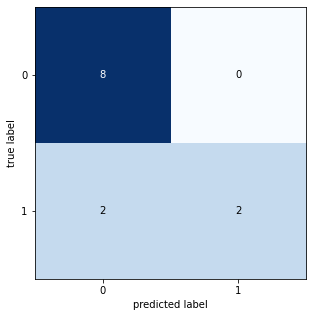

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



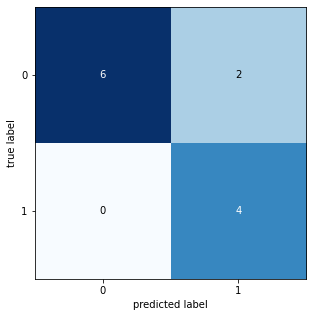

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



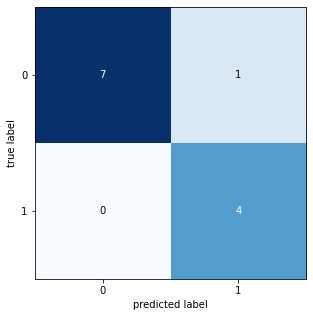

avg accuraccy Colon Cancer =  0.8551282051282051
avg F1_Score Colon Cancer =  0.8312698412698414
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.7777777777777778
Running Time:  37.02998648399989
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

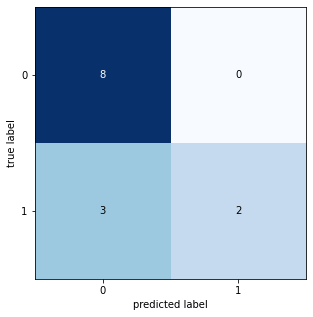

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



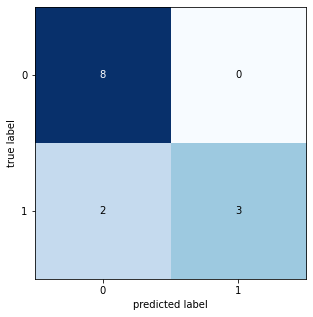

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



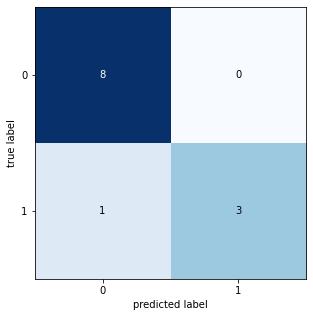

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



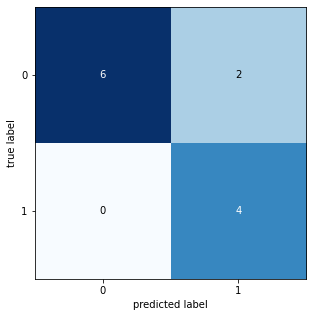

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



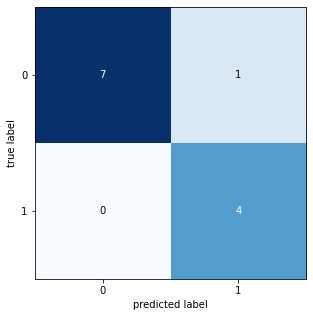

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  35.95828072200038
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

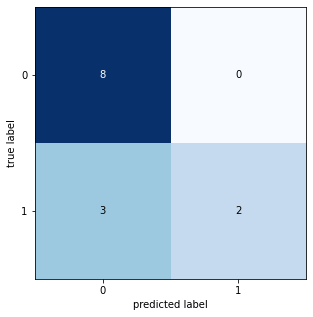

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



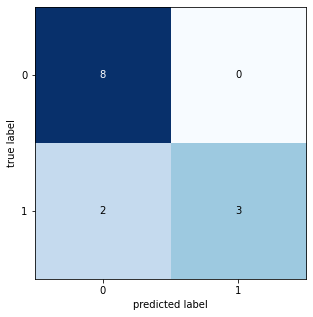

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



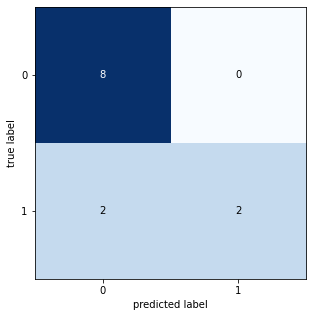

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



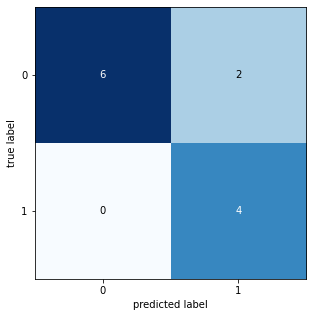

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



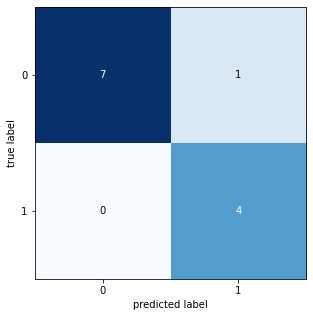

avg accuraccy Colon Cancer =  0.8397435897435898
avg F1_Score Colon Cancer =  0.8087343358395991
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  38.00913324500016
gene : [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

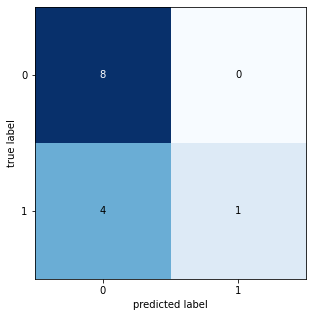

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



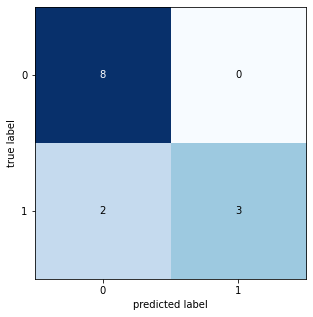

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



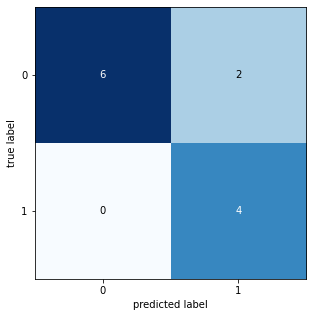

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



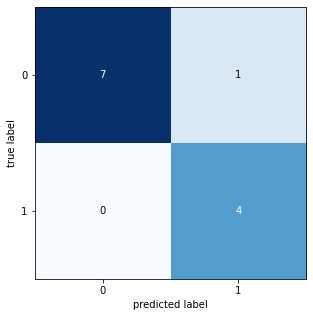

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



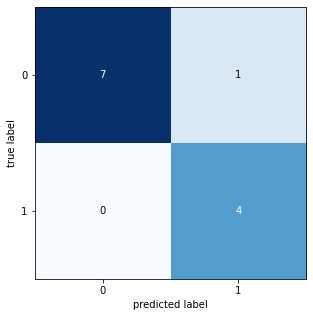

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8073809523809524
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  39.47412144199916
gene : [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6

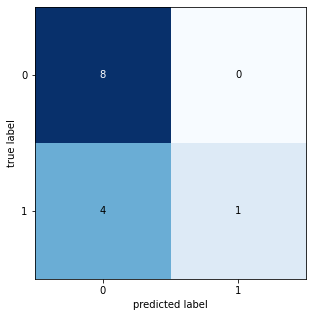

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



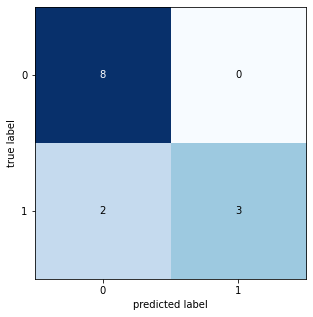

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



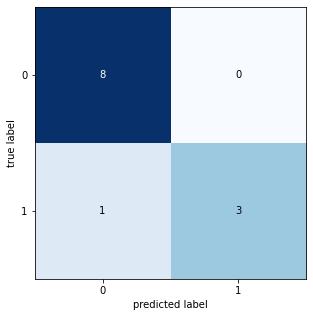

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



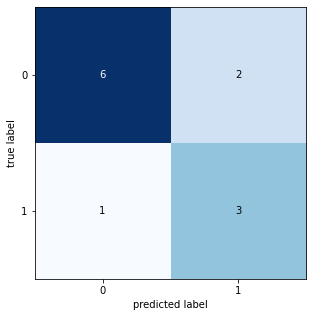

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



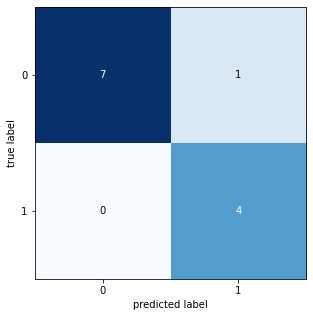

avg accuraccy Colon Cancer =  0.8243589743589743
avg F1_Score Colon Cancer =  0.7859430438842203
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  38.50710682499994
gene : [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

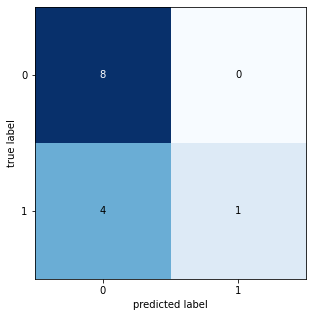

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



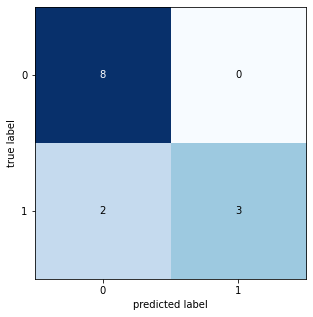

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



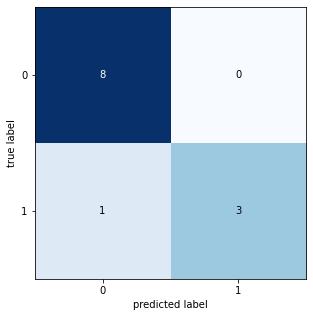

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



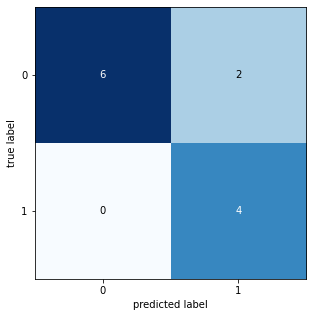

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



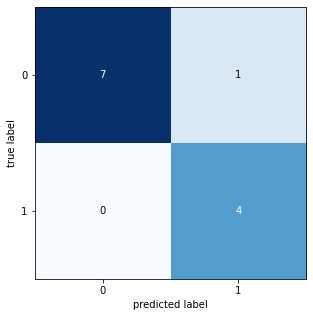

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8049906629318395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  36.859581726000215
gene : [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

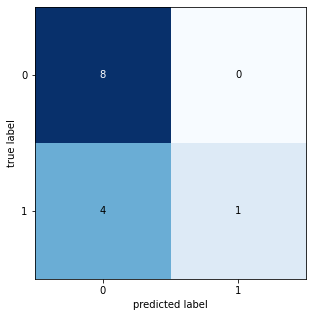

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



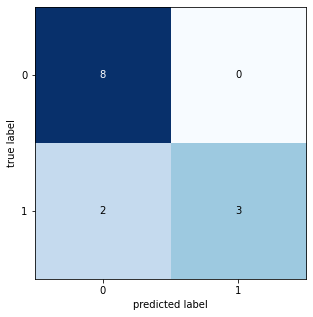

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



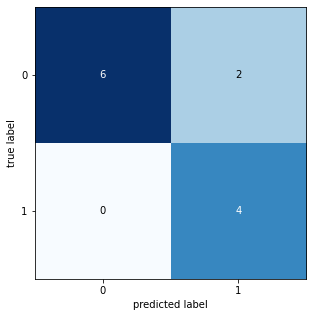

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



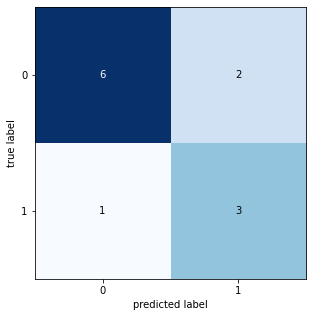

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



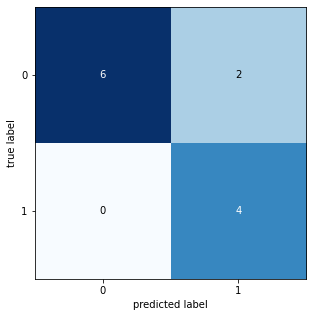

avg accuraccy Colon Cancer =  0.7910256410256411
avg F1_Score Colon Cancer =  0.7553174603174602
max accuraccy Colon Cancer =  0.8461538461538461
max F1_Score Colon Cancer =  0.8285714285714285
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.68040276300053
gen terbaik : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.8330107130571527  || Akurasi terbaik : 0.8564102564102564  || jumlah fitur : 47

Generation : 1
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0

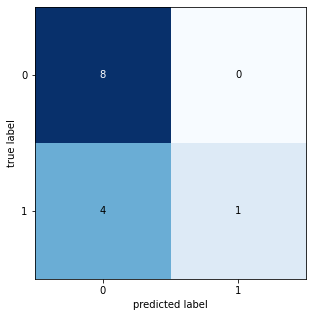

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



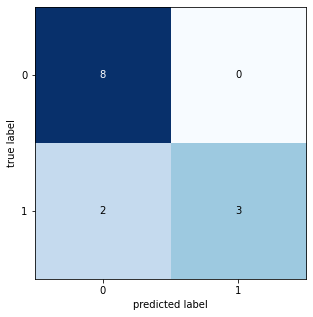

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



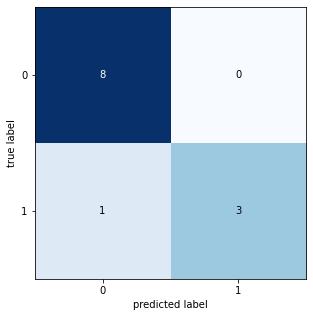

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333332
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



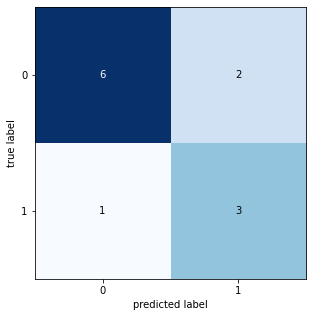

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



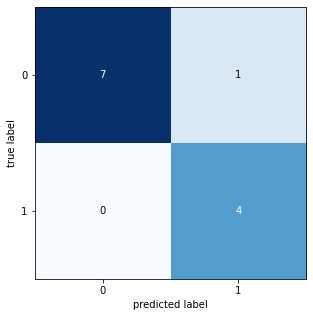

avg accuraccy Colon Cancer =  0.8243589743589743
avg F1_Score Colon Cancer =  0.7859430438842203
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  39.415358973000366
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

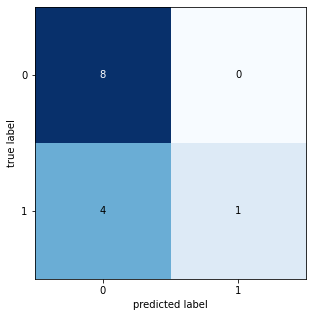

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



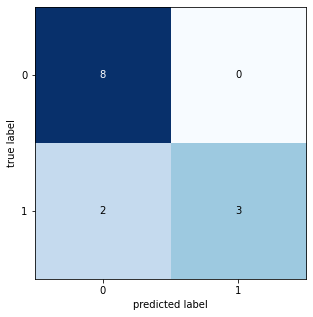

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



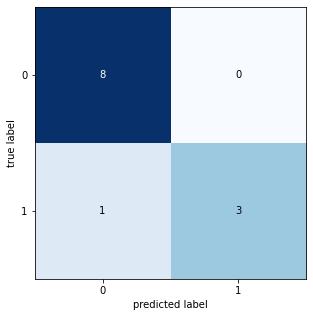

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



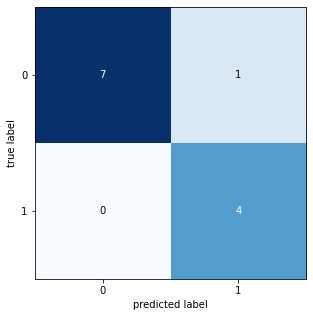

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



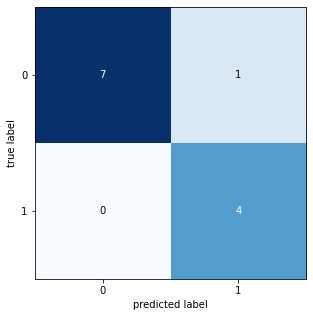

avg accuraccy Colon Cancer =  0.8576923076923076
avg F1_Score Colon Cancer =  0.8214985994397759
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  38.00415867799984
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

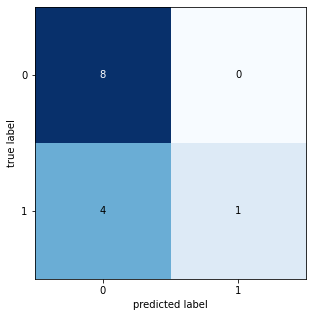

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



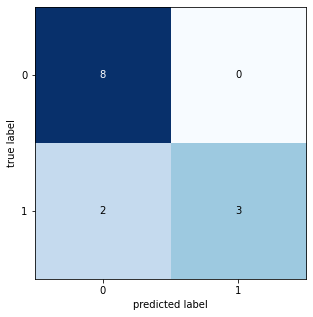

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



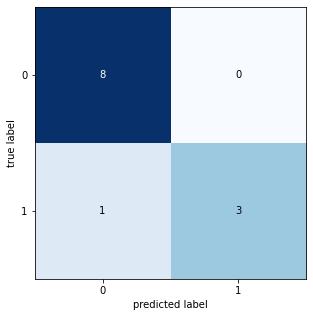

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



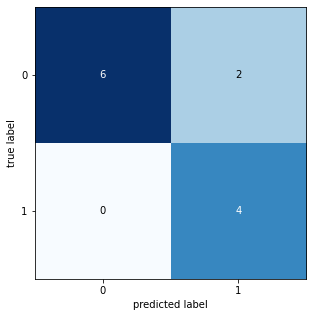

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



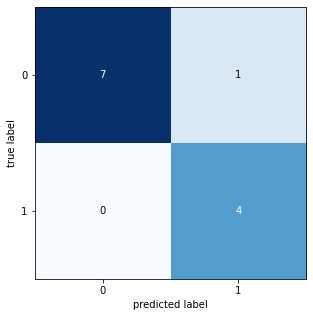

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8049906629318395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  35.856292112999654
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

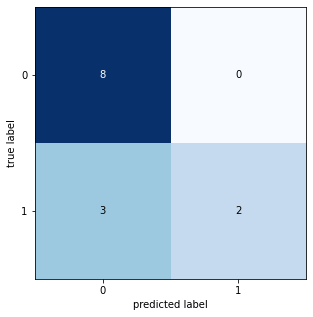

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



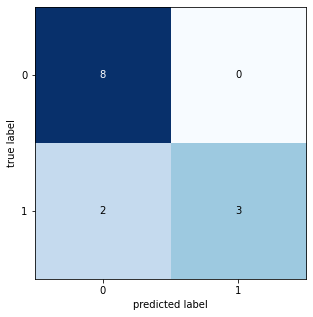

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



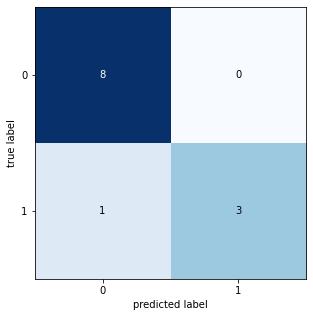

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



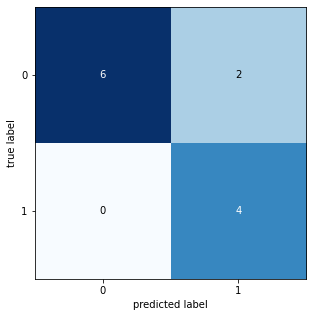

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



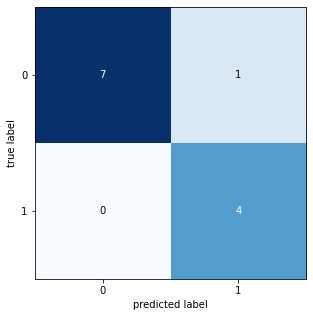

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  39.119632568999805
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

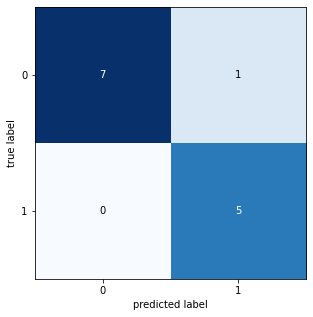

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



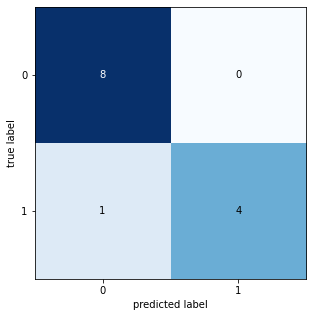

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



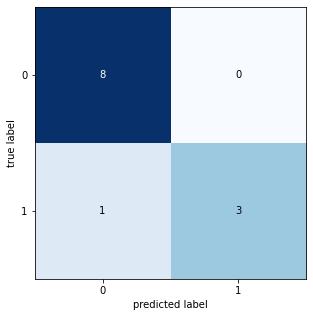

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



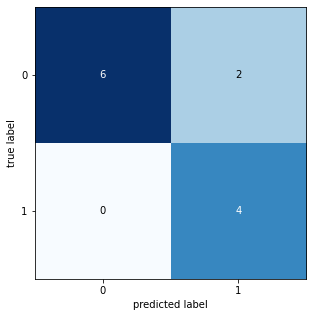

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



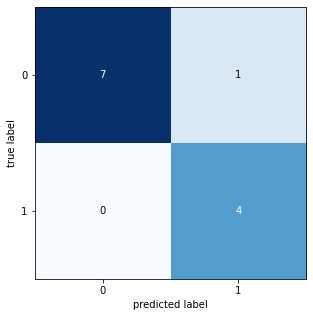

avg accuraccy Colon Cancer =  0.9025641025641026
avg F1_Score Colon Cancer =  0.8950174008997539
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9212121212121211
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  38.630809391000184
gene : [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

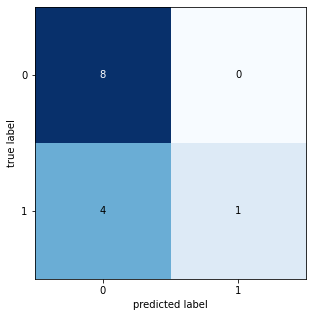

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



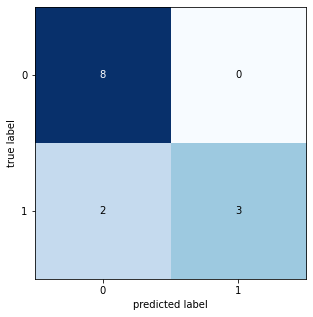

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.8333333333333334
F1_Score :  0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



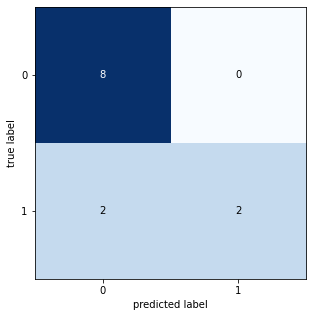

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



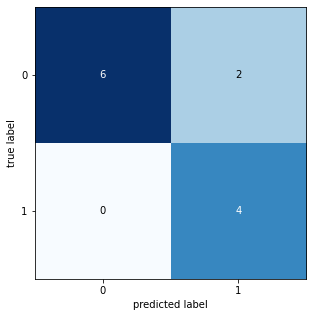

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



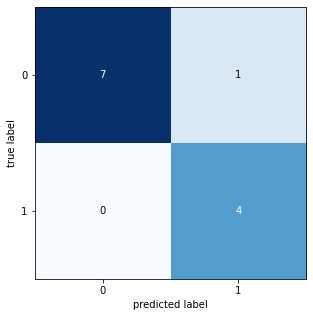

avg accuraccy Colon Cancer =  0.8243589743589744
avg F1_Score Colon Cancer =  0.7807142857142857
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.92461664300026
gene : [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

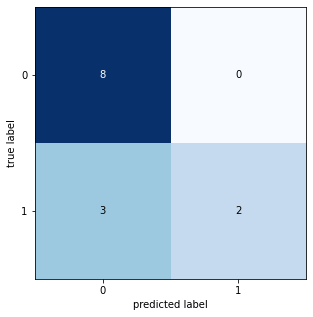

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



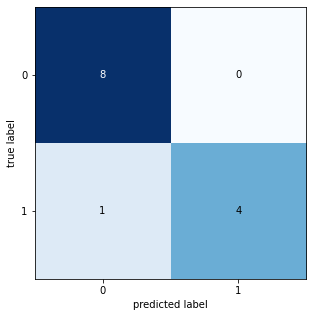

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



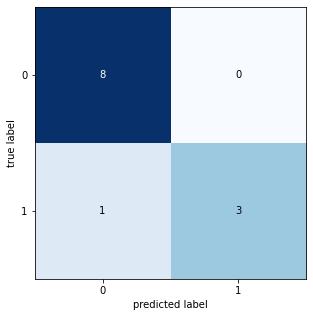

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



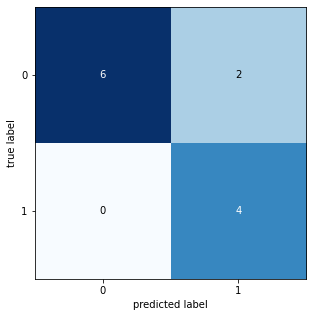

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



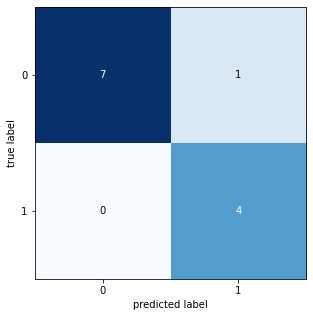

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.8521283601159763
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  37.05278678800005
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

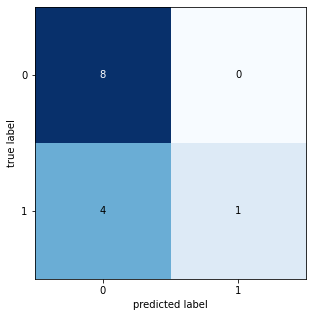

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



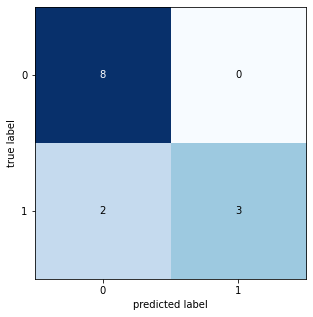

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



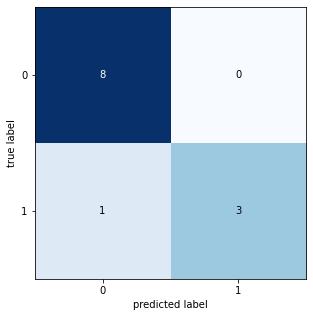

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



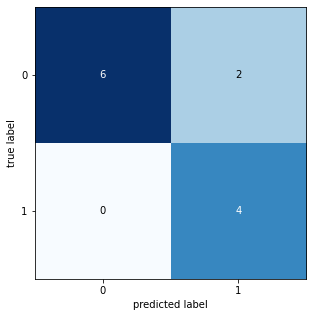

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



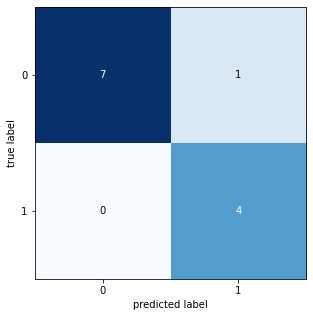

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8049906629318395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  40.37267733800036
gene : [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7

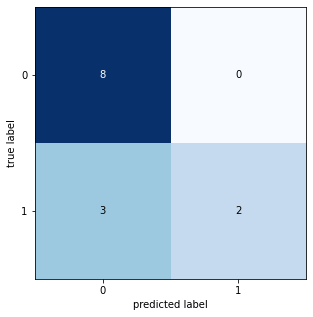

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



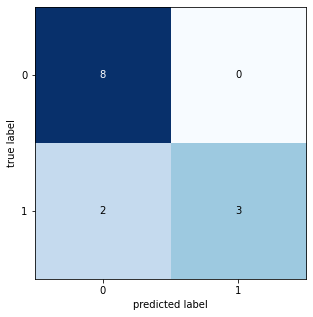

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



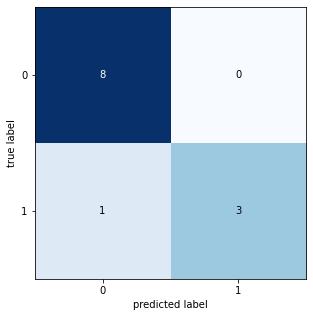

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



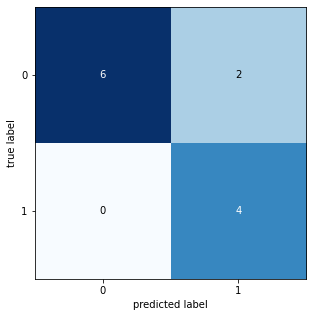

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



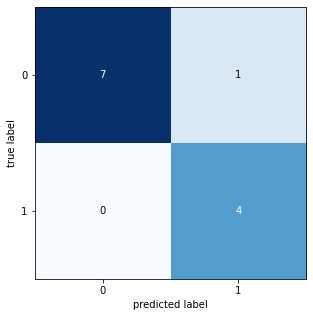

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  40.99752040699968
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

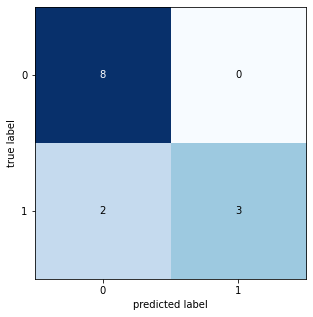

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



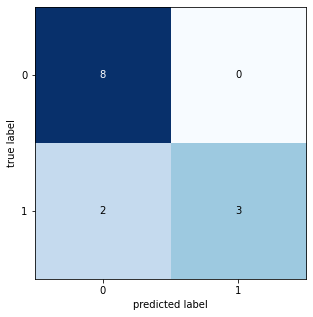

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



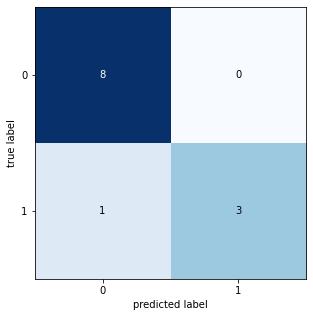

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



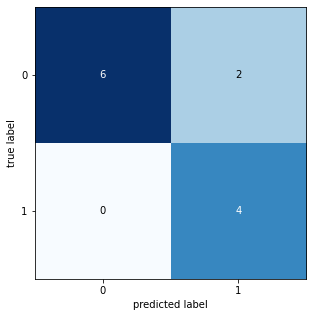

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



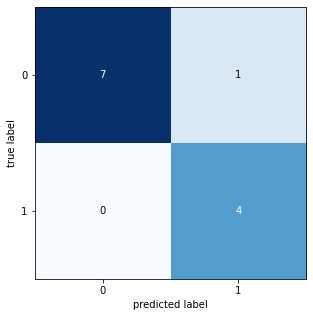

avg accuraccy Colon Cancer =  0.8717948717948719
avg F1_Score Colon Cancer =  0.855546218487395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8194444444444444
Running Time:  38.53727017099936
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
F-1 Score terbaik : 0.8950174008997539  || Akurasi terbaik : 0.9025641025641026  || jumlah fitur : 47

Generation : 2
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,

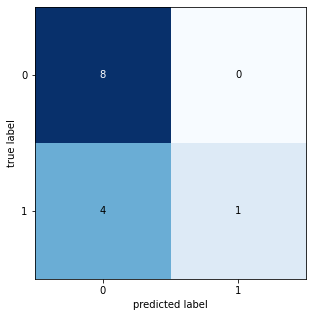

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8375000000000001
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13



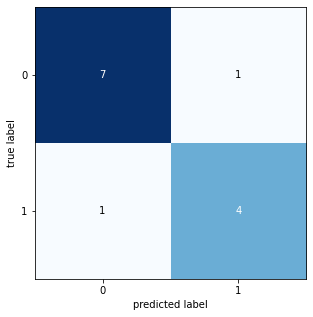

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



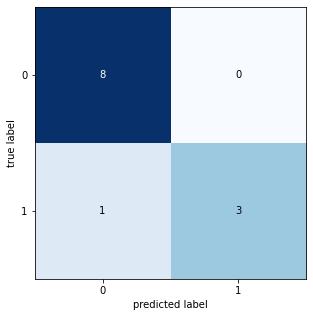

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



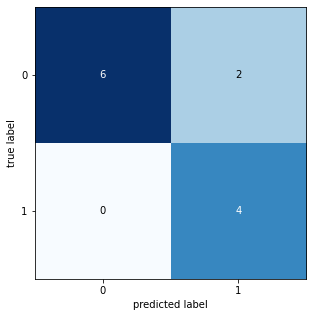

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



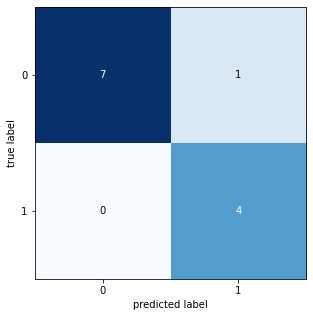

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8086017740429506
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.178288963998966
gene : [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

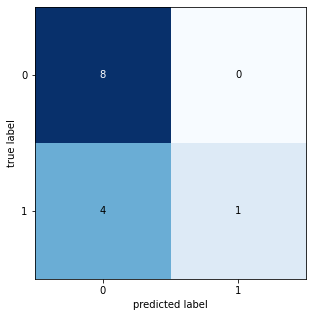

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



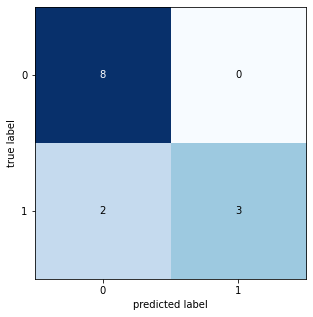

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.50      1.00      0.67         4

    accuracy                           0.67        12
   macro avg       0.75      0.75      0.67        12
weighted avg       0.83      0.67      0.67        12



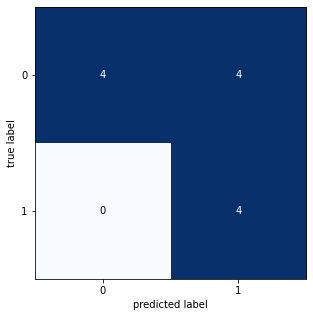

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



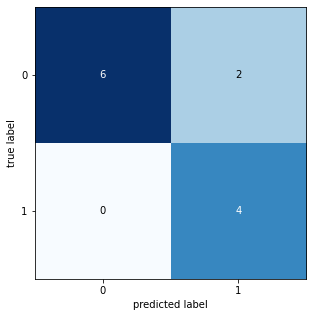

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



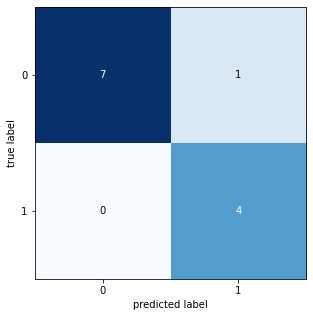

avg accuraccy Colon Cancer =  0.791025641025641
avg F1_Score Colon Cancer =  0.7584920634920636
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  38.117413977999604
gene : [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

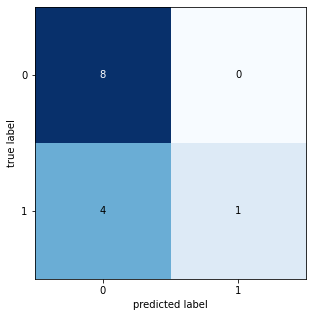

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



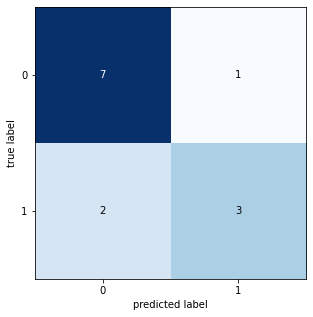

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



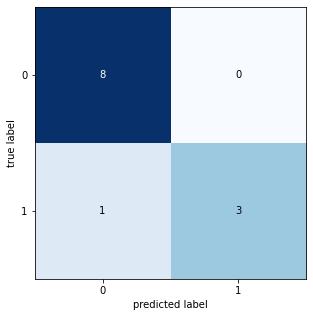

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.6666666666666666
F1_Score :  0.625
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.50      0.50      0.50         4

    accuracy                           0.67        12
   macro avg       0.62      0.62      0.62        12
weighted avg       0.67      0.67      0.67        12



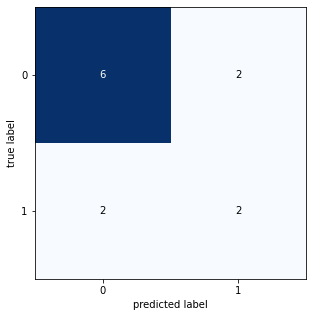

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



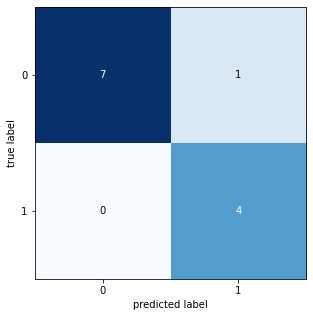

avg accuraccy Colon Cancer =  0.7923076923076923
avg F1_Score Colon Cancer =  0.7494070961718021
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  38.444928206999975
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

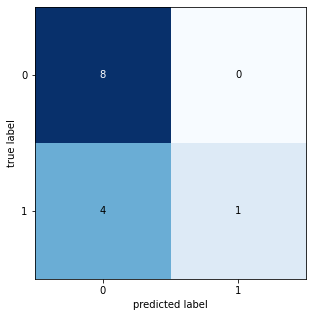

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



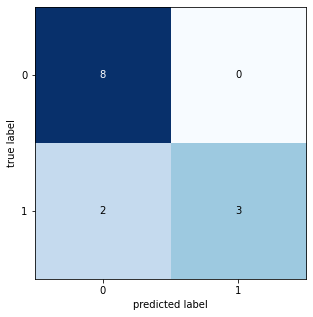

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



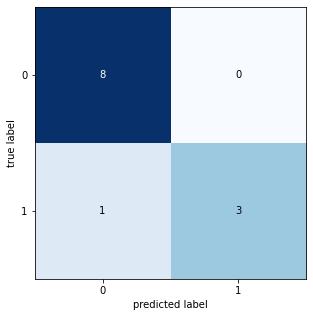

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



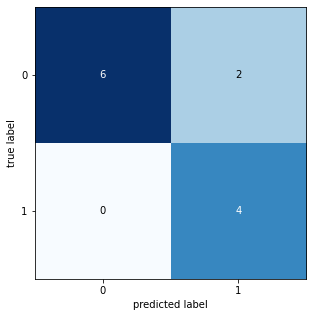

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



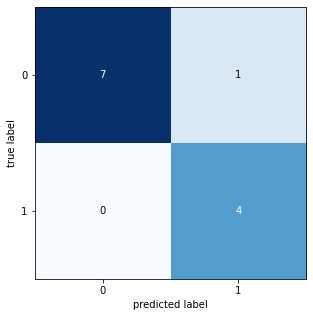

avg accuraccy Colon Cancer =  0.841025641025641
avg F1_Score Colon Cancer =  0.8049906629318395
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  37.75682006400166
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.6

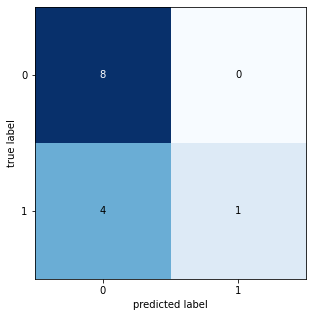

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



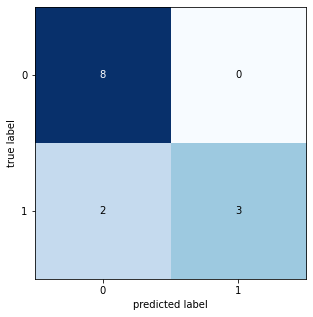

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.6666666666666666
F1_Score :  0.4
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



/home/jamessaldo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


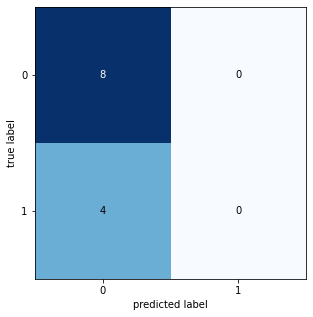

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



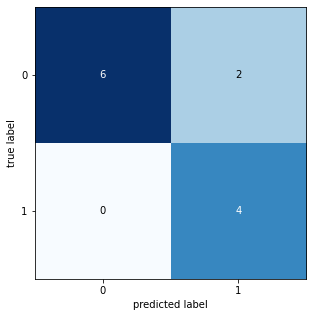

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



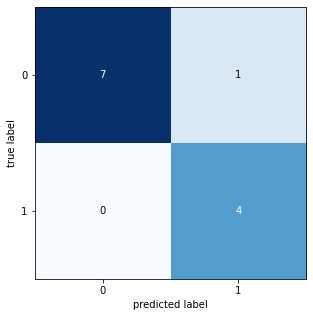

avg accuraccy Colon Cancer =  0.791025641025641
avg F1_Score Colon Cancer =  0.7051587301587302
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6666666666666666
min F1_Score Colon Cancer =  0.4
Running Time:  38.03094076299931
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.8461538461538461

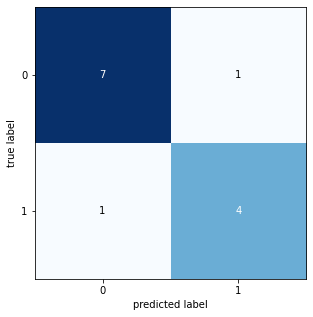

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7067669172932332
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.40      0.57         5

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13



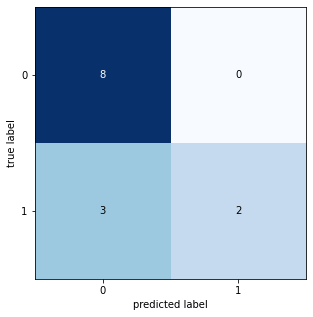

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



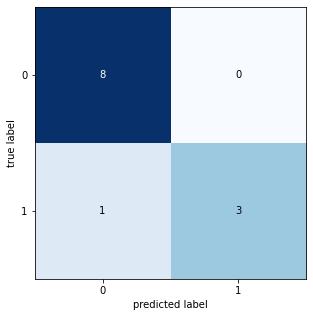

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



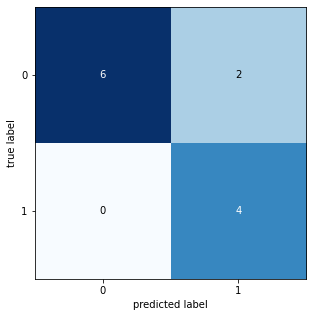

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.8333333333333334
F1_Score :  0.8125
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.75      0.75      0.75         4

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12



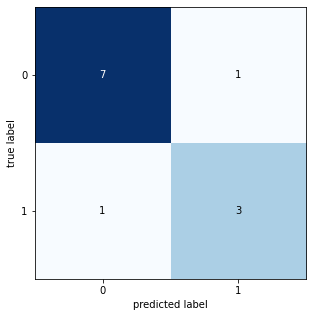

avg accuraccy Colon Cancer =  0.8397435897435898
avg F1_Score Colon Cancer =  0.8168996019460415
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.8991596638655461
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  39.10420297100063
gene : [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  1.

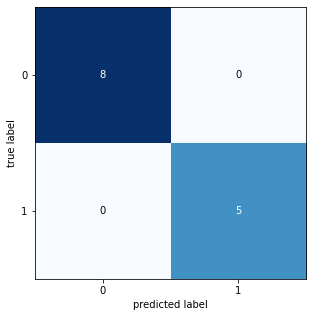

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



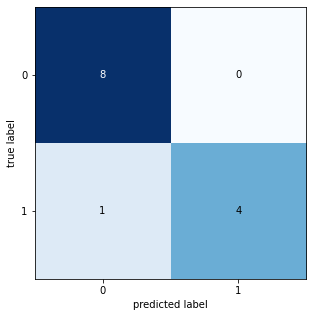

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



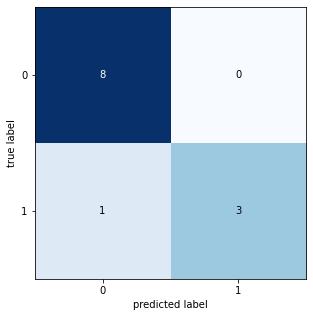

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



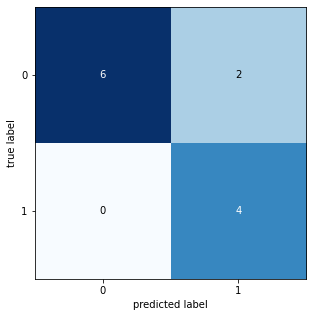

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



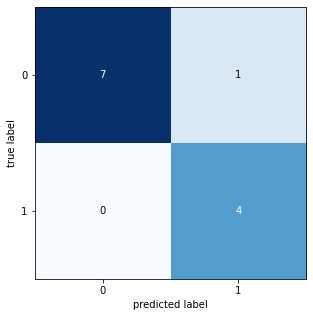

avg accuraccy Colon Cancer =  0.917948717948718
avg F1_Score Colon Cancer =  0.9107749766573295
max accuraccy Colon Cancer =  1.0
max F1_Score Colon Cancer =  1.0
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  37.508895682
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.7692307692307693
F1_Score :  0.70676

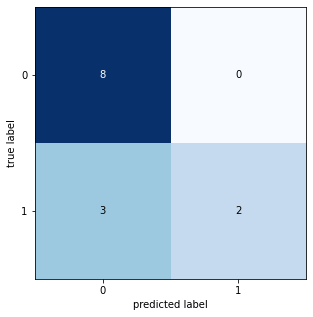

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.8461538461538461
F1_Score :  0.8194444444444444
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.60      0.75         5

    accuracy                           0.85        13
   macro avg       0.90      0.80      0.82        13
weighted avg       0.88      0.85      0.84        13



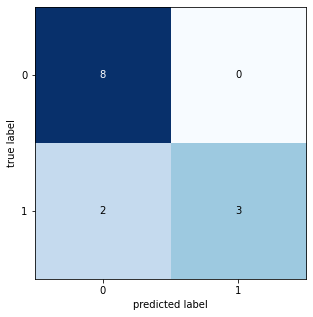

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



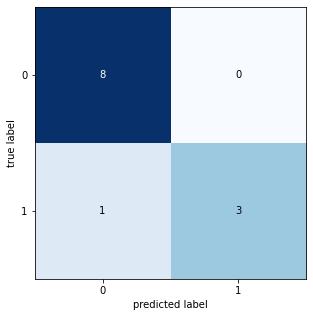

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



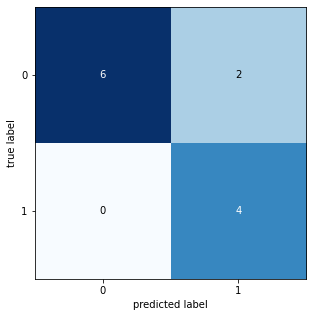

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



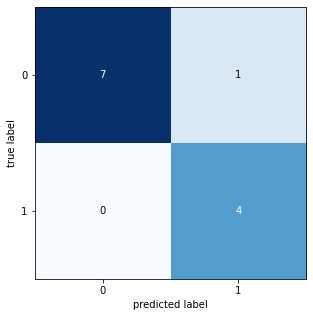

avg accuraccy Colon Cancer =  0.8564102564102564
avg F1_Score Colon Cancer =  0.8330107130571527
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.7692307692307693
min F1_Score Colon Cancer =  0.7067669172932332
Running Time:  36.425949872000274
gene : [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0

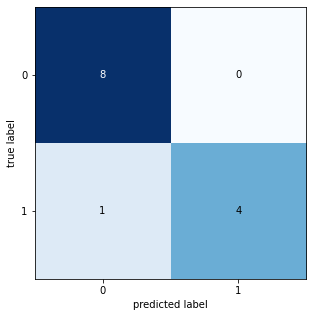

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.9230769230769231
F1_Score :  0.9150326797385622
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.80      0.89         5

    accuracy                           0.92        13
   macro avg       0.94      0.90      0.92        13
weighted avg       0.93      0.92      0.92        13



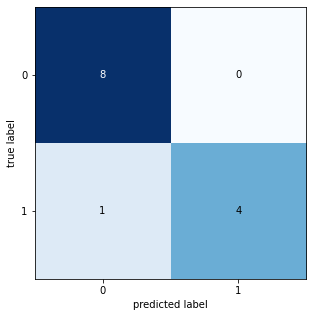

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



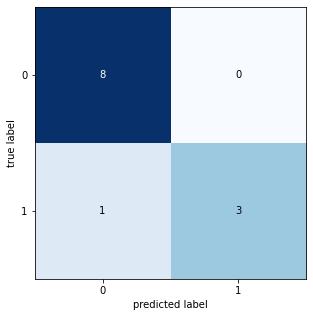

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



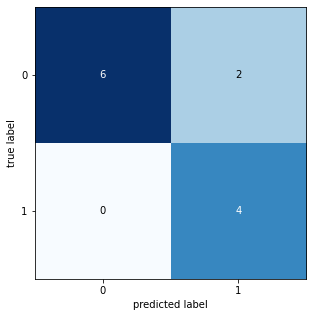

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



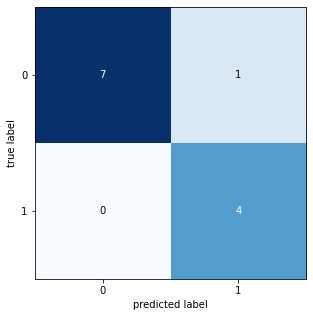

avg accuraccy Colon Cancer =  0.9025641025641026
avg F1_Score Colon Cancer =  0.893781512605042
max accuraccy Colon Cancer =  0.9230769230769231
max F1_Score Colon Cancer =  0.9150326797385622
min accuraccy Colon Cancer =  0.8333333333333334
min F1_Score Colon Cancer =  0.8285714285714285
Running Time:  38.489381965000575
gene : [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]
Train : [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 23 25 26 27 29 30 31 32
 33 34 36 37 38 39 40 41 43 44 45 46 48 49 50 51 52 53 54 55 57 58 59 60
 61] Test : [ 0  3 12 15 20 21 22 24 28 35 42 47 56]
Y_Train : [1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 0 0 1 1 0 0 0 1 0 1]
Y_Test : [0 1 0 1 0 1 0 0 0 0 1 1 0]
Akurasi :  0.

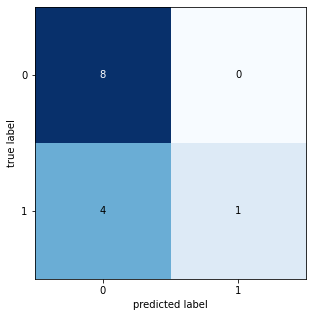

Train : [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16 17 19 20 21 22 24 25 26 27 28
 29 31 32 33 34 35 36 37 40 42 43 45 46 47 48 49 51 52 53 54 55 56 58 59
 61] Test : [ 8  9 10 18 23 30 38 39 41 44 50 57 60]
Y_Train : [0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 0 1 1 0 0 0 1 1]
Y_Test : [0 1 0 0 1 0 1 0 1 0 1 0 0]
Akurasi :  0.7692307692307693
F1_Score :  0.7450980392156863
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13



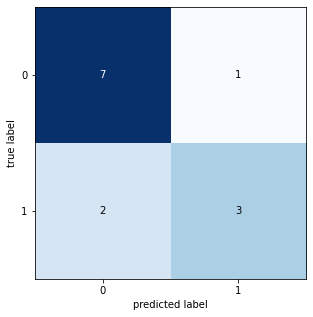

Train : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 27 28 30 31 35 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 55 56 57 58
 60 61] Test : [19 25 26 29 32 33 34 36 46 53 54 59]
Y_Train : [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 1 1 0 0 0 0 0 0 0 1]
Y_Test : [1 0 0 0 0 0 0 0 0 1 1 1]
Akurasi :  0.9166666666666666
F1_Score :  0.8991596638655461
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



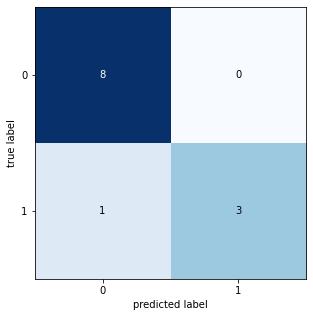

Train : [ 0  1  3  4  5  8  9 10 12 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50 53 54 56 57 58 59
 60 61] Test : [ 2  6  7 11 13 14 16 45 49 51 52 55]
Y_Train : [0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1]
Y_Test : [0 0 1 1 1 0 0 0 1 0 0 0]
Akurasi :  0.8333333333333334
F1_Score :  0.8285714285714285
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.67      1.00      0.80         4

    accuracy                           0.83        12
   macro avg       0.83      0.88      0.83        12
weighted avg       0.89      0.83      0.84        12



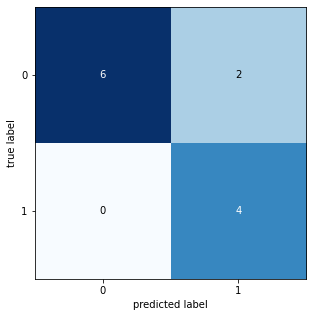

Train : [ 0  2  3  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 28
 29 30 32 33 34 35 36 38 39 41 42 44 45 46 47 49 50 51 52 53 54 55 56 57
 59 60] Test : [ 1  4  5 17 27 31 37 40 43 48 58 61]
Y_Train : [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 1 1 0 0 1 1 0 0 0 1 0]
Y_Test : [1 0 1 1 0 0 0 0 0 0 0 1]
Akurasi :  0.9166666666666666
F1_Score :  0.9111111111111112
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



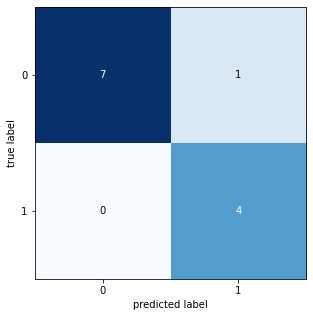

avg accuraccy Colon Cancer =  0.8256410256410257
avg F1_Score Colon Cancer =  0.7901213818860878
max accuraccy Colon Cancer =  0.9166666666666666
max F1_Score Colon Cancer =  0.9111111111111112
min accuraccy Colon Cancer =  0.6923076923076923
min F1_Score Colon Cancer =  0.5666666666666667
Running Time:  38.753592422999645
gen terbaik : [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
F-1 Score terbaik : 0.9107749766573295  || Akurasi terbaik : 0.917948717948718  || jumlah fitur : 42

Running Time:  1140.416440473


In [15]:
Colon_IG_GA = GeneticAlgorithm(Colon_IG, 4)